# Initialize things

In [1]:
# make the screen bigger!
from IPython.display import display, HTML
display(HTML(data=""" <style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 85%; }
    div#maintoolbar-container { width: 99%; } </style> """))


#### import modules
import numpy as np
import arcpy
import os
import sys
from arcpy.sa import *
import pandas as pd
#import gdal
from arcpy import env
import shutil
import numpy.ma as ma
import netCDF4 as nc
import subprocess
import re
import datetime
import matplotlib 
import matplotlib.pyplot as plt
import scipy
from scipy.stats import linregress
import scipy.optimize as opt

# Tired of pink boxes?
pd.options.mode.chained_assignment = None  # default='warn'

# this is a list of additional functions to load up, as to not clutter the script
# %run ../../Std_input/COMMON/plot_and_table_functions

# set properties
arcpy.env.overwriteOutput = True # make sure overwrite files is on
# projection definition 
sr_project = arcpy.SpatialReference(32702)   # Project dataset into WGS84
cel_size = 100     # in m 
Control_File_Name = 'Tutuila_cal_controlFile.ctl'


#### General coverages and paths. More, basic model setup.
GIS_FOLDER = os.path.join('..', '..', 'Raw_GIS_Data')
STD_INPUT_FOLDER = os.path.join('..', '..', 'Std_input')
# path to the grid bound
Grid_shp = os.path.join(GIS_FOLDER, 'grid_bound.shp')

if not os.path.exists(os.path.join('..', 'output')):
    os.makedirs(os.path.join('..', 'output'))

input_folder = os.path.join("..", "Dynamic_input") 


### Copy input data from the "original" model run
(the one using runoff to rainfall ratios)


In [2]:
''' NOTE this WILL NOT overwrite an old folder, for example, if the cell size is ever changed,
    the original model "SWB2_Tutuila_model-R2R_ratio_methodipynb" needs to be rerun, the old Dynamic_input
    folder needs to be deleted, and this cell run again '''


if not os.path.exists(os.path.join('..', 'Dynamic_input')):
    shutil.copytree(os.path.join(".." , 'Original_R2R_ratio_Model', 'input'), os.path.join('..', 'Dynamic_input'))

In [3]:
# Move in other standard input files and modify control file to the shape of the current run
# modify the control file grid for the given run   (note this uses dimensions from the rainfall adjustment grid in april)
with open(os.path.join(input_folder, 'RF_adj_grids', 'rfadj_apr.asc'), 'r') as dims_file:   # open an ASC file and get the dimenstions out of it 
    dimsfile1 = dims_file.read().splitlines(True)
    x_dim = float(re.findall('\d+', dimsfile1[0])[-1])    
    y_dim = float(re.findall('\d+', dimsfile1[1])[-1])

with open(os.path.join('.', Control_File_Name), 'r') as fin:   # open file 
    data = fin.read().splitlines(True)
with open(os.path.join('.', Control_File_Name), 'w') as fout:     # delete first line
    fout.writelines(data[1:])
new_first = 'GRID {} {} 515000. 8409000. {} '.format(x_dim, y_dim, cel_size)  # new first line 
with open(os.path.join('.', Control_File_Name), 'r+') as file:                # add in new first line and save file  
    file_data = file.read()
    file. seek(0, 0)
    file. write(new_first + '\n' + file_data)

# Simple RO : RF ratios file
shutil.copy2(os.path.join(GIS_FOLDER, 'Runofftorainfall2\\RO_Rf_ratios_real_monthly3_2000_2010.txt') ,os.path.join(input_folder)) # note this is from the simplified version with zone IDs starting at 1

# Rain Fragments file
shutil.copy2(os.path.join(STD_INPUT_FOLDER, "Fragments", 'Rainfall_fragments_2001.prn') ,os.path.join(input_folder))  

#  Fragments sequence file
shutil.copy2(os.path.join(STD_INPUT_FOLDER, "Fragments", 'Sequence_file_2002.prn') ,os.path.join(input_folder)) 


'..\\Dynamic_input\\Sequence_file_2002.prn'

In [4]:
def run_model(name, x_dim, y_dim):
    print(name)

    # need to run this before the 1st model run to re-fresh the direct net infiltration coverage to not include the MFR. 
    arcpy.Plus_3d(os.path.join(input_folder,  'Direct_infiltration',  "A_WL_Rast.asc"), os.path.join(input_folder,  'Direct_infiltration', "OSDS_inlf_in.asc"), os.path.join(input_folder,  'Direct_infiltration', "temprast"))
    arcpy.RasterToASCII_conversion(os.path.join(input_folder,  'Direct_infiltration', "temprast"), os.path.join(input_folder,  'Direct_infiltration', "Total_inlf_in.asc"))


    # RUN Da MODEL (with no MFR) 
    print("Run model 1, no MFR")
    os.chdir(os.path.join("..", "run"))
    # Executable and control file copies
    shutil.copy2(os.path.join("." , 'swb2.exe') ,os.path.join('..', 'output')) 
    shutil.copy2(os.path.join("." , Control_File_Name) ,os.path.join('..', 'output')) 

    os.chdir(os.path.join("..", "output"))
    subprocess.call('swb2.exe {}'.format(Control_File_Name), shell=True)
    os.chdir(os.path.join("..", "run"))

    ### Post process da files
    outspace = os.path.join('..', "output", 'post_prcessed_no_MFR')
    if not os.path.exists(outspace):
        os.makedirs(outspace)

    # Parameters
    Desired_files = ['actual_et',  'direct_net_infiltation', 'direct_soil_moisture',
                 'interception', 'net_infiltration', 'rainfall', 'runoff'] # 'delta_soil_storage',  'irrigation', 
    XLLCORNER =      515000.000
    YLLCORNER =      8409000.000
    CELLSIZE  =      cel_size

    # functions
    def create_file_reference( component_name ):
        '''
        This is a simple convenience function that will form a path and filename to a
        given water budget component
        '''
        # specify the prefix, path to SWB2 output, timeframe, and resolution
        #output_path = os.path.join(os.getcwd(), "output")
        #prefix      = '\\'
        
    # pull start and end dates from control file
        with open(os.path.join('.', Control_File_Name), 'r') as fin:   # open file 
            date_find = fin.read().splitlines(True)
        start_year = datetime.datetime.strptime(date_find[-2].split(" ")[1], "%m/%d/%Y").strftime("%Y-%m-%d")
        end_year =  datetime.datetime.strptime(date_find[-1].split(" ")[1], "%m/%d/%Y").strftime("%Y-%m-%d")

        ncol        = str(int(x_dim))
        nrow        = str(int(y_dim))
        return(  component_name + '__' + start_year + '_' 
              + end_year + '__' + nrow + '_by_' + ncol + '.nc' )

    # some other functions to post process stuff

    def ncdump(nc_fid):
        '''ncdump outputs dimensions, variables and their attribute information of netCDF4 files'''
        nc_attrs = nc_fid.ncattrs()
        nc_dims = [dim for dim in nc_fid.dimensions]  
        nc_vars = [var for var in nc_fid.variables] 
        return nc_attrs, nc_dims, nc_vars

    def writeArrayToArcGrid(arr,filename,xll,yll,cellsize,no_data_val):
        """ this takes a 2d numpy array and turns it into an .asc file """
        arr                = np.copy(arr)
        arr[np.isnan(arr)] = no_data_val
        headerstring       = bytes('NCOLS %d\nNROWS %d\nXLLCENTER %f\nYLLCENTER %f\nCELLSIZE %f\nNODATA_value %f\n' % 
            (arr.shape[1], arr.shape[0], xll, yll, cellsize, no_data_val), 'UTF-8')

        with open(filename,'wb') as fout:
            fout.write(headerstring)
            np.savetxt(fout,arr,'%5.2f')


    # post process the whole model domain
    os.chdir(os.path.join("..", 'output'))  # difficulty in making the path to the file so need to change into the output directory
    var = []; tot = []; nclist = []

    # Step 1: make list of files that you wish to process 
    for i in Desired_files:
        Da_file = create_file_reference(i)
        nclist.append(Da_file)

    # Step 2 average the daily dimension (len(t) is # of days in the run) to annual 
    for i, f in enumerate(nclist):
        nc_data = nc.Dataset(nclist[i])
        nc_attrs, nc_dims, nc_vars = ncdump(nc_data)
        nc_var = nc_vars[3]
        t = nc_data.variables['time'][:]
        y = nc_data.variables['y'][:]
        x = nc_data.variables['x'][:]
        nt = len(t)
        nrow = len(y)
        ncol = len(x)
        rd = np.zeros((nrow, ncol))  # create 0 array of the proper shape
        for day in range(nt):
            r_temp = nc_data.variables[str(nc_var)][day, :, :]
            r_filled = np.ma.filled(r_temp, fill_value=0)    # fills in missing values with 0s (i think) 
            rd = rd+r_filled                                 # sequentially add each day's value in each cell to the empty frame  
        r = rd/nt*365 # to create a one year average from all the years in model.  if want to add leap years add 0.25 

        # step 3: write each yearly average array to a .asc file
        keyname = Desired_files[i] 
        writeArrayToArcGrid(r, os.path.join(outspace, "{}_annual.asc".format(keyname)), XLLCORNER, YLLCORNER, CELLSIZE, -999)

        # Step 4: calculate total amounts of water in cubic meters per day and create statistics dataframe
        m3pd = ((cel_size**2)*r.sum()*.0254)/365 
        
        var.append(keyname) ; tot.append(m3pd)     # make lists to populate pandas dataframe

        nc_data.close()          # make sure to close the nc file so it doesnt stay open

    stat_frame = pd.DataFrame({'Variable' : var, 'total_[m3pd]': tot})    #in case you want the max and min#, "Max_[in]": mx, "Min_[in]":mn})
    stat_frame["total_[MGD]"] = stat_frame["total_[m3pd]"]/3785.41178       # put things in MGD if interested, 3785.41178 is number of gal in m3      
    Precip = list(stat_frame[stat_frame['Variable'] == 'rainfall']['total_[m3pd]'])[0]   # define the amount of calculated Precip
    Dir_net_inf = list(stat_frame[stat_frame['Variable'] == 'direct_net_infiltation']['total_[m3pd]'])[0]   # define the amount of calculated infiltration
    WB_ins = Precip + Dir_net_inf
    stat_frame['pct_of_pcip'] = stat_frame["total_[m3pd]"]/WB_ins
    stat_frame.to_csv(os.path.join(outspace, "stats_run7_{}m_cells.csv".format(cel_size)))

    # how does the model balance? 
    print("WATER BALANCE ratio: outs over ins water budget balanece =  {} % ".format(stat_frame['pct_of_pcip'].sum()-1))   # check water balance

    os.chdir(os.path.join("..", 'run'))  # then back out to the home directory

    # calculate statistics for individual watersheds
    # note, for some reason will not overwrite csvs need to clear them out or recode to make this issue not an issue
    #create workspace
    outspace_table = os.path.join('..', 'output', 'post_prcessed_no_MFR', "tables")
    if not os.path.exists(outspace_table):
        os.makedirs(outspace_table)
    sheds = (os.path.join(GIS_FOLDER, 'Watersheds\\Runoff_zones_sheds_WGS2S_clip.shp'))

    # process each raster layer into a table
    for i in (os.listdir(outspace)):
        if i.endswith('.asc'):
            outZSaT = ZonalStatisticsAsTable(sheds, "SHED_NAME", os.path.join(outspace, i), os.path.join(outspace_table, "temptab.dbf"))  # in arc format
            arcpy.TableToTable_conversion(outZSaT, outspace_table, "Table_{}_1.csv".format(i))                                            # take table out of stupid arc format and put into csv format 

    # this block takes each of the csvs, reads them and calculates water volumnes (m3/d) for each watershed
    templist = []
    for c in (os.listdir(os.path.join(outspace, "tables"))):
        if c.endswith('.csv'):
            data = pd.read_csv(os.path.join(outspace, "tables", c))
            keyname = c.split("Table_")[1].split("_annual")[0]                   # parameter being worked on
            data[keyname] = (data['MEAN']*.0254/365) * data['AREA'] 
            temp_frame = data[["SHED_NAME", keyname]]
            templist.append(temp_frame)

    summarry_frame1 = data[['SHED_NAME']]                                        # this is just sticking them all together into one dataframe
    for i in templist:
        summarry_frame1 = summarry_frame1.merge(i, on ='SHED_NAME', how='outer')


    # that was in actual volumns, now to convert each component into a fraction of the rainfall...
    templist2 = []
    summarry_frame2 = data[['SHED_NAME']]
    for i in summarry_frame1.columns[1:]:
        temp_frame = data[['SHED_NAME']] ; temp_frame[i.split("-")[0]] = summarry_frame1[i]/summarry_frame1['rainfall']
        templist2.append(temp_frame)

    summarry_frame3 = data[['SHED_NAME']]
    for i in templist2:
        summarry_frame3 = summarry_frame3.merge(i, on ='SHED_NAME', how='outer')

    summarry_frame_4000 = summarry_frame1.set_index('SHED_NAME')
    summarry_frame_4 = summarry_frame_4000.select_dtypes(exclude=['object'])*264.172/1000000   # convert to million gallons per day

    summarry_frame3.to_csv(os.path.join(outspace, "watershed_summary_stats_percentages.csv"))
    summarry_frame1.to_csv(os.path.join(outspace, "watershed_summary_stats_volume_m3pd.csv"))
    summarry_frame_4.to_csv(os.path.join(outspace, "watershed_summary_stats_volumes_MGD.csv"))


    ### MFR calculations      
    outspace = os.path.join('..', "output", 'post_prcessed_no_MFR')
    if not os.path.exists(outspace):
        os.makedirs(outspace)

    # caclulate how much runoff to dump into the MFR area
    outspace_table = os.path.join('..', 'output', 'MFR_calcs', "tables")
    if not os.path.exists(outspace_table):
        os.makedirs(outspace_table)

    Contributing_area_leo = (os.path.join(GIS_FOLDER, 'MFR\\Contributing_MRF_Areas_leone.shp'))
    Contributing_area_taf = (os.path.join(GIS_FOLDER, 'MFR\\Contributing_MRF_Areas_tafuna.shp'))

    outZSaT_leo = ZonalStatisticsAsTable(Contributing_area_leo, "SHED_NAME", os.path.join(outspace, "runoff_annual.asc"), os.path.join(outspace_table, "temptab_leo.dbf"))  # in arc format
    arcpy.TableToTable_conversion(outZSaT_leo, outspace_table, "runoff_MFR_leo.csv")                                            # take table out of stupid arc format and put into csv format 
    outZSaT_leo = ZonalStatisticsAsTable(Contributing_area_taf, "SHED_NAME", os.path.join(outspace, "runoff_annual.asc"), os.path.join(outspace_table, "temptab_taf.dbf"))  # in arc format
    arcpy.TableToTable_conversion(outZSaT_leo, outspace_table, "runoff_MFR_taf.csv") 

    data_leo = pd.read_csv(os.path.join(outspace_table, "runoff_MFR_leo.csv"))
    data_taf = pd.read_csv(os.path.join(outspace_table, "runoff_MFR_taf.csv"))

    data_leo["AreaRunoff_m3pd"] = (data_leo['MEAN']*.0254/365) * data_leo['AREA']    # this is how much runoff is in each MFR contributionzone
    data_taf["AreaRunoff_m3pd"] = (data_taf['MEAN']*.0254/365) * data_taf['AREA']    # this is how much runoff is in each MFR contributionzone
    tot_MFR_leo = sum(data_leo['AreaRunoff_m3pd'])
    tot_MFR_taf = sum(data_taf['AreaRunoff_m3pd'])

    # calculate the MFR area and prepare input files
    workspace = os.path.join(input_folder,  'MFR')
    if not os.path.exists(workspace):
        os.makedirs(workspace)

    arcpy.Project_management(os.path.join(GIS_FOLDER, 'MFR\\MFR_infiltration_area_leone.shp'),  os.path.join(workspace, 'MFR_infiltration_area_leone_projected.shp'), sr_project) 
    arcpy.AddField_management(os.path.join(workspace, 'MFR_infiltration_area_leone_projected.shp'), "MFR_inch", "DOUBLE")    # add Active cell unit field
    arcpy.AddGeometryAttributes_management(os.path.join(workspace, 'MFR_infiltration_area_leone_projected.shp'), "AREA")
    Total_MFR_area_leo = 0                                                                                                        # stupid block just to calculate the total area
    with arcpy.da.SearchCursor(os.path.join(workspace, 'MFR_infiltration_area_leone_projected.shp'), "POLY_AREA") as cursor:
        for row in cursor:
            Total_MFR_area_leo = Total_MFR_area_leo + row[0]

    arcpy.Project_management(os.path.join(GIS_FOLDER, 'MFR\\MFR_infiltration_area_tafuna.shp'),  os.path.join(workspace, 'MFR_infiltration_area_tafuna_projected.shp'), sr_project) 
    arcpy.AddField_management(os.path.join(workspace, 'MFR_infiltration_area_tafuna_projected.shp'), "MFR_inch", "DOUBLE")    # add Active cell unit field
    arcpy.AddGeometryAttributes_management(os.path.join(workspace, 'MFR_infiltration_area_tafuna_projected.shp'), "AREA")
    Total_MFR_area_taf = 0                                                                                                        # stupid block just to calculate the total area
    with arcpy.da.SearchCursor(os.path.join(workspace, 'MFR_infiltration_area_tafuna_projected.shp'), "POLY_AREA") as cursor:
        for row in cursor:
            Total_MFR_area_taf = Total_MFR_area_taf + row[0]

    Inches_of_MFR_across_leo = (tot_MFR_leo/Total_MFR_area_leo/0.0254) * 0.75   # note this 75% number if directly from Izuka 2007
    Inches_of_MFR_across_taf = (tot_MFR_taf/Total_MFR_area_taf/0.0254) * 0.75   # note this 75% number if directly from Izuka 2007

    arcpy.CalculateField_management(os.path.join(workspace, 'MFR_infiltration_area_leone_projected.shp'), "MFR_inch", "!MFR_inch! + {}".format(Inches_of_MFR_across_leo), "PYTHON3") # calculate the appropriate amount of infitration in inches spread over all MFR zone
    arcpy.CalculateField_management(os.path.join(workspace, 'MFR_infiltration_area_tafuna_projected.shp'), "MFR_inch", "!MFR_inch! + {}".format(Inches_of_MFR_across_taf), "PYTHON3") # calculate the appropriate amount of infitration in inches spread over all MFR zone

    arcpy.Erase_analysis(Grid_shp, os.path.join(workspace, 'MFR_infiltration_area_leone_projected.shp'),  os.path.join(workspace, 'MFR_infiltration_area_leone_bound.shp'))
    arcpy.Erase_analysis(Grid_shp, os.path.join(workspace, 'MFR_infiltration_area_tafuna_projected.shp'),  os.path.join(workspace, 'MFR_infiltration_area_tafuna_bound.shp'))

    arcpy.Merge_management([os.path.join(workspace, 'MFR_infiltration_area_leone_bound.shp'), os.path.join(workspace, 'MFR_infiltration_area_leone_projected.shp')], os.path.join(workspace, 'MFR_infiltration_area_leone_ready.shp'))
    arcpy.Merge_management([os.path.join(workspace, 'MFR_infiltration_area_tafuna_bound.shp'), os.path.join(workspace, 'MFR_infiltration_area_tafuna_projected.shp')], os.path.join(workspace, 'MFR_infiltration_area_tafuna_ready.shp'))

    arcpy.PolygonToRaster_conversion(os.path.join(workspace, 'MFR_infiltration_area_leone_ready.shp'), "MFR_inch", os.path.join(workspace, "MFR_Rast_L"), cell_assignment="MAXIMUM_AREA",  cellsize=cel_size)
    arcpy.PolygonToRaster_conversion(os.path.join(workspace, 'MFR_infiltration_area_tafuna_ready.shp'), "MFR_inch", os.path.join(workspace, "MFR_Rast_T"), cell_assignment="MAXIMUM_AREA",  cellsize=cel_size)

    arcpy.RasterToASCII_conversion(os.path.join(workspace, "MFR_Rast_L"), os.path.join(workspace, "MFR_Rast_L.asc"))
    arcpy.RasterToASCII_conversion(os.path.join(workspace, "MFR_Rast_T"), os.path.join(workspace, "MFR_Rast_T.asc"))

    arcpy.Delete_management(os.path.join(workspace, 'MFR_infiltration_area_leone_projected.shp'))
    arcpy.Delete_management(os.path.join(workspace, 'MFR_infiltration_area_tafuna_projected.shp'))
    arcpy.Delete_management(os.path.join(workspace, 'MFR_infiltration_area_leone_bound.shp'))
    arcpy.Delete_management(os.path.join(workspace, 'MFR_infiltration_area_tafuna_bound.shp'))
    arcpy.Delete_management(os.path.join(workspace, 'MFR_infiltration_area_leone_ready.shp'))
    arcpy.Delete_management(os.path.join(workspace, 'MFR_infiltration_area_tafuna_ready.shp'))
    arcpy.Delete_management(os.path.join(workspace, 'MFR_Rast_L'))
    arcpy.Delete_management(os.path.join(workspace, 'MFR_Rast_T'))

    # now combine the MFR raster into the other direct infiltration rasters
    arcpy.Plus_3d(os.path.join(input_folder,  'MFR', "MFR_Rast_L.asc"), os.path.join(input_folder,  'Direct_infiltration', "WLOSDrast"), os.path.join(input_folder,  'Direct_infiltration', "temprast2"))
    arcpy.Plus_3d(os.path.join(input_folder,  'MFR', "MFR_Rast_T.asc"), os.path.join(input_folder,  'Direct_infiltration', "temprast2"), os.path.join(input_folder,  'Direct_infiltration', "temprast3"))
    arcpy.RasterToASCII_conversion(os.path.join(input_folder,  'Direct_infiltration', "temprast3"), os.path.join(input_folder,  'Direct_infiltration', "Total_inlf_in.asc"))

    #print('MFR leo in MGD is {}'.format(tot_MFR_leo*264.172/1000000))
    #print('MFR taf in MGD is {}'.format(tot_MFR_taf*264.172/1000000))
    #print('MFR total in MGD is {}'.format((tot_MFR_leo+tot_MFR_taf)*264.172/1000000))
    print("Caclculating MFR")
    
    # Run da Model again, this time including the MFR
    print("Run model 2, with MFR")
    
    # Executable and control file copies
    shutil.copy2(os.path.join("." , 'swb2.exe') ,os.path.join('..', 'output')) 
    shutil.copy2(os.path.join("." , Control_File_Name) ,os.path.join('..', 'output')) 

    os.chdir(os.path.join("..", "output"))
    subprocess.call('swb2.exe {}'.format(Control_File_Name), shell=True)
    os.chdir(os.path.join("..", "run"))

    # Post process the files again, this time with the MFR added 
    outspace = os.path.join('..', "output", 'post_prcessed_with_MFR')
    if not os.path.exists(outspace):
        os.makedirs(outspace)

    # post process the whole model domain      
    os.chdir(os.path.join("..", 'output'))  # difficulty in making the path to the file so need to change into the output directory
    var = []; tot = []; nclist = []

    # Step 1: make list of files that you wish to process 
    for i in Desired_files:
        Da_file = create_file_reference(i)
        nclist.append(Da_file)

    # Step 2 average the daily dimension (len(t) is # of days in the run) to annual 
    for i, f in enumerate(nclist):
        nc_data = nc.Dataset(nclist[i])
        nc_attrs, nc_dims, nc_vars = ncdump(nc_data)
        nc_var = nc_vars[3]
        t = nc_data.variables['time'][:]
        y = nc_data.variables['y'][:]
        x = nc_data.variables['x'][:]
        nt = len(t)
        nrow = len(y)
        ncol = len(x)
        rd = np.zeros((nrow, ncol))  # create 0 array of the proper shape
        for day in range(nt):
            r_temp = nc_data.variables[str(nc_var)][day, :, :]
            r_filled = np.ma.filled(r_temp, fill_value=0)    # fills in missing values with 0s (i think) 
            rd = rd+r_filled                                 # sequentially add each day's value in each cell to the empty frame  
        r = rd/nt*365 # to create a one year average from all the years in model.  if want to add leap years add 0.25 

        # step 3: write each yearly average array to a .asc file
        keyname = Desired_files[i] 
        writeArrayToArcGrid(r, os.path.join(outspace, "{}_annual.asc".format(keyname)), XLLCORNER, YLLCORNER, CELLSIZE, -999)

        # Step 4: calculate total amounts of water in cubic meters per day and create statistics dataframe
        m3pd = ((cel_size**2)*r.sum()*.0254)/365 
        # print("{} total  {} [m3/d]".format(keyname, '%.1f' % m3pd))
        var.append(keyname) ; tot.append(m3pd)     # make lists to populate pandas dataframe

        nc_data.close()          # make sure to close the nc file so it doesnt stay open

    stat_frame = pd.DataFrame({'Variable' : var, 'total_[m3pd]': tot})    #in case you want the max and min#, "Max_[in]": mx, "Min_[in]":mn})
    stat_frame["total_[MGD]"] = stat_frame["total_[m3pd]"]/3785.41178       # put things in MGD if interested, 3785.41178 is number of gal in m3      
    Precip = list(stat_frame[stat_frame['Variable'] == 'rainfall']['total_[m3pd]'])[0]   # define the amount of calculated Precip
    Dir_net_inf = list(stat_frame[stat_frame['Variable'] == 'direct_net_infiltation']['total_[m3pd]'])[0]   # define the amount of calculated infiltration
    WB_ins = Precip + Dir_net_inf
    stat_frame['pct_of_pcip'] = stat_frame["total_[m3pd]"]/WB_ins
    stat_frame.to_csv(os.path.join(outspace, "stats_run7_{}m_cells.csv".format(cel_size)))

    # how does the model balance? 
    print("WATER BALANCE ratio: outs over ins water budget balanece =  {} % ".format(stat_frame['pct_of_pcip'].sum()-1))   # check water balance

    os.chdir(os.path.join("..", 'run'))  # then back out to the home directory

    # calculate statistics for individual watersheds
    # note, for some reason will not overwrite csvs need to clear them out or recode to make this issue not an issue
    #create workspace
    outspace_table = os.path.join('..', 'output', 'post_prcessed_with_MFR', "tables")
    if not os.path.exists(outspace_table):
        os.makedirs(outspace_table)
    sheds = (os.path.join(GIS_FOLDER, 'Watersheds\\Runoff_zones_sheds_WGS2S_clip.shp'))

    # process each raster layer into a table
    for i in (os.listdir(outspace)):
        if i.endswith('.asc'):
            outZSaT = ZonalStatisticsAsTable(sheds, "SHED_NAME", os.path.join(outspace, i), os.path.join(outspace_table, "temptab.dbf"))  # in arc format
            arcpy.TableToTable_conversion(outZSaT, outspace_table, "Table_{}_1.csv".format(i))                                            # take table out of stupid arc format and put into csv format 

    # this block takes each of the csvs, reads them and calculates water volumnes (m3/d) for each watershed
    templist = []
    for c in (os.listdir(os.path.join(outspace, "tables"))):
        if c.endswith('.csv'):
            data = pd.read_csv(os.path.join(outspace, "tables", c))
            keyname = c.split("Table_")[1].split("_annual")[0]                   # parameter being worked on
            data[keyname] = (data['MEAN']*.0254/365) * data['AREA'] 
            temp_frame = data[["SHED_NAME", keyname]]
            templist.append(temp_frame)

    summarry_frame1 = data[['SHED_NAME']]                                        # this is just sticking them all together into one dataframe
    for i in templist:
        summarry_frame1 = summarry_frame1.merge(i, on ='SHED_NAME', how='outer')


    # that was in actual volumns, now to convert each component into a fraction of the rainfall...
    templist2 = []
    summarry_frame2 = data[['SHED_NAME']]
    for i in summarry_frame1.columns[1:]:
        temp_frame = data[['SHED_NAME']] ; temp_frame[i.split("-")[0]] = summarry_frame1[i]/summarry_frame1['rainfall']
        templist2.append(temp_frame)

    summarry_frame3 = data[['SHED_NAME']]
    for i in templist2:
        summarry_frame3 = summarry_frame3.merge(i, on ='SHED_NAME', how='outer')

    summarry_frame_4000 = summarry_frame1.set_index('SHED_NAME')
    summarry_frame_4 = summarry_frame_4000.select_dtypes(exclude=['object'])*264.172/1000000   # convert to million gallons per day

    summarry_frame3.to_csv(os.path.join(outspace, "watershed_summary_stats_percentages.csv"))
    summarry_frame1.to_csv(os.path.join(outspace, "watershed_summary_stats_volume_m3pd.csv"))
    summarry_frame_4.to_csv(os.path.join(outspace, "watershed_summary_stats_volumes_MGD.csv"))
    
    
    
    Cal_Results = os.path.join('..', "output", 'Calibration_results')
    if not os.path.exists(Cal_Results):
        os.makedirs(Cal_Results)

    sheds = os.path.join("..", "..",  "Raw_GIS_Data", "Watersheds", "Calibration_watersheds",  "Measured_watersheds.shp")

    SWB_asc_file_path =    os.path.join("..","output", "post_prcessed_with_MFR")

    DatasetsToRun = ['net_infiltration_annual.asc', 'rainfall_annual.asc', 'runoff_annual.asc']  # 1 for calibration, 2 for sanity check, 3 for see how runoff changes

    templist = []
    for i in DatasetsToRun:
        outZSaT = ZonalStatisticsAsTable(sheds, "gage_name", os.path.join(SWB_asc_file_path, i), os.path.join(Cal_Results, "temptab.dbf"))  # in arc format
        arcpy.TableToTable_conversion(outZSaT, Cal_Results, "SWB_{}_MeasureSheds.csv".format(i)) 

    # this block takes the parameters of interests, reads them and calculates water volumnes (m3/d) for each watershed
        data = pd.read_csv(os.path.join(Cal_Results, "SWB_{}_MeasureSheds.csv".format(i)))
        keyname = i.split(".")[0] + "_m3pd"
        data[keyname] = (data['MEAN']*.0254/365) * data['AREA']   # Convert ave recharge in inches/yr to m3pd
        temp_frame = data[["gage_name", keyname]]
        templist.append(temp_frame)

    CN_Computerd_vals_frame = data[['gage_name']]                                        # this is just sticking them all together into one dataframe
    for i in templist:
        CN_Computerd_vals_frame = CN_Computerd_vals_frame.merge(i, on ='gage_name', how='outer')

        # Now summarry_frame['net_infiltration_annual_m3pd'] are your clibration values.    
    
    return CN_Computerd_vals_frame



# Function used for optimization

# function to create the new CN values, with the sensible boundaries
def changeo(x, shift):
    c = int(x*shift)
    if c > 99:
        newval = 99
    else:
        newval = c
    if newval < 25:
        newval2 = 25
    else:
        newval2 = newval
        
    return newval2

### Read in observed values of recharge from the original model. 

In [5]:
Observed_Vals = pd.read_csv(os.path.join("..", "Original_R2R_ratio_Model", 'Observed_R2R_type_recharge_cal_values.csv'), index_col=0)

LU code 400, factored by 0.75, trying CN set of [41 54 61 63] 
LU code 500, factored by 0.85695718, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.78150531, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8433525, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.14537165, trying CN set of [32 62 80 87] 
LU code 1700, factored by 0.92335715, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 72 76] 
LU code 2100, factored by 0.79536626, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091198014039962 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090077779668012 % 


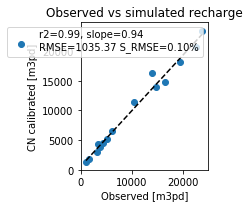


 RMSE is 1035.3730405955066
LU code 400, factored by 0.75, trying CN set of [41 54 61 63] 
LU code 500, factored by 0.85695718, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.78150531, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8433525, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.14537165, trying CN set of [32 62 80 87] 
LU code 1700, factored by 0.92335715, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 72 76] 
LU code 2100, factored by 0.79536626, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091198014039962 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090077779668012 % 


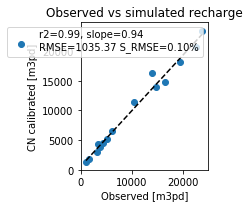


 RMSE is 1035.3730405955066
LU code 400, factored by 0.76, trying CN set of [41 54 62 64] 
LU code 500, factored by 0.85695718, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.78150531, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8433525, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.14537165, trying CN set of [32 62 80 87] 
LU code 1700, factored by 0.92335715, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 72 76] 
LU code 2100, factored by 0.79536626, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091371448975122 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090245846096693 % 


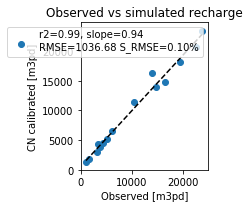


 RMSE is 1036.683188016298
LU code 400, factored by 0.75, trying CN set of [41 54 61 63] 
LU code 500, factored by 0.86695718, trying CN set of [38 56 66 71] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.78150531, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8433525, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.14537165, trying CN set of [32 62 80 87] 
LU code 1700, factored by 0.92335715, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 72 76] 
LU code 2100, factored by 0.79536626, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091324385849818 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090200774621163 % 


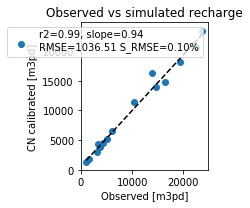


 RMSE is 1036.513249764082
LU code 400, factored by 0.75, trying CN set of [41 54 61 63] 
LU code 500, factored by 0.85695718, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.84802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.78150531, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8433525, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.14537165, trying CN set of [32 62 80 87] 
LU code 1700, factored by 0.92335715, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 72 76] 
LU code 2100, factored by 0.79536626, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091198014039962 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090077779668012 % 


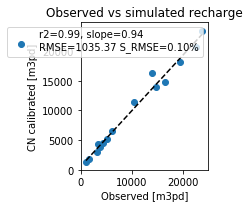


 RMSE is 1035.3730405955066
LU code 400, factored by 0.75, trying CN set of [41 54 61 63] 
LU code 500, factored by 0.85695718, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.79150531, trying CN set of [47 59 66 68] 
LU code 1000, factored by 0.8433525, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.14537165, trying CN set of [32 62 80 87] 
LU code 1700, factored by 0.92335715, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 72 76] 
LU code 2100, factored by 0.79536626, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091362614046417 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090239196553599 % 


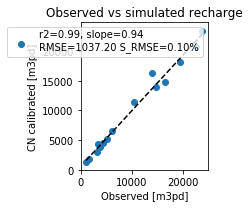


 RMSE is 1037.2020789552332
LU code 400, factored by 0.75, trying CN set of [41 54 61 63] 
LU code 500, factored by 0.85695718, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.78150531, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8533525, trying CN set of [69 75 78 80] 
LU code 1600, factored by 1.14537165, trying CN set of [32 62 80 87] 
LU code 1700, factored by 0.92335715, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 72 76] 
LU code 2100, factored by 0.79536626, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0092702827634437 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091563766223888 % 


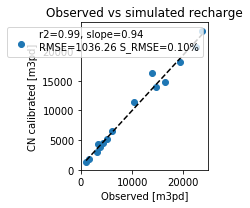


 RMSE is 1036.2649904693092
LU code 400, factored by 0.75, trying CN set of [41 54 61 63] 
LU code 500, factored by 0.85695718, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.78150531, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8433525, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.15537165, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.92335715, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 70 85 91] 
LU code 1500, factored by 0.89, trying CN set of [43 61 72 76] 
LU code 2100, factored by 0.79536626, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.009170375802071 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090568599856566 % 


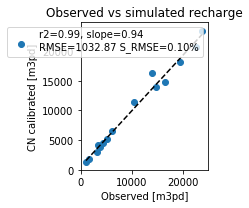


 RMSE is 1032.8720362463075
LU code 400, factored by 0.75, trying CN set of [41 54 61 63] 
LU code 500, factored by 0.85695718, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.78150531, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8433525, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.14537165, trying CN set of [32 62 80 87] 
LU code 1700, factored by 0.93335715, trying CN set of [33 56 69 73] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 62 72 77] 
LU code 2100, factored by 0.79536626, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091243469011482 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090122253056264 % 


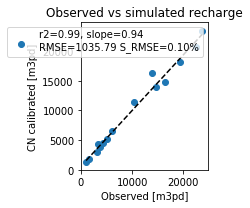


 RMSE is 1035.7911497862221
LU code 400, factored by 0.75, trying CN set of [41 54 61 63] 
LU code 500, factored by 0.85695718, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.78150531, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8433525, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.14537165, trying CN set of [32 62 80 87] 
LU code 1700, factored by 0.92335715, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.89, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 72 76] 
LU code 2100, factored by 0.79536626, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091198014039962 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090077779668012 % 


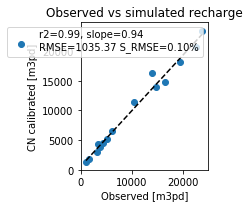


 RMSE is 1035.3730405955066
LU code 400, factored by 0.75, trying CN set of [41 54 61 63] 
LU code 500, factored by 0.85695718, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.78150531, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8433525, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.14537165, trying CN set of [32 62 80 87] 
LU code 1700, factored by 0.92335715, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.9, trying CN set of [43 61 72 76] 
LU code 2100, factored by 0.79536626, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091198014039962 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090077779668012 % 


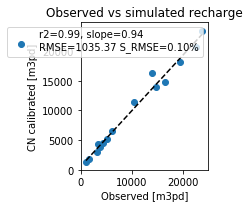


 RMSE is 1035.3730405955066
LU code 400, factored by 0.75, trying CN set of [41 54 61 63] 
LU code 500, factored by 0.85695718, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.78150531, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8433525, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.14537165, trying CN set of [32 62 80 87] 
LU code 1700, factored by 0.92335715, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 72 76] 
LU code 2100, factored by 0.80536626, trying CN set of [25 44 56 61] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.009121322774012 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.009009278716075 % 


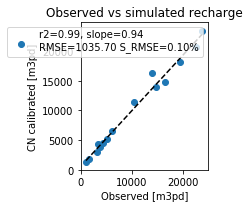


 RMSE is 1035.6996474330488
LU code 400, factored by 0.7499999940587252, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8569571748293635, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7815053017056512, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8433524959551733, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1453716613415894, trying CN set of [32 62 80 87] 
LU code 1700, factored by 0.9233571481039525, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 72 76] 
LU code 2100, factored by 0.7953662585188987, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.009099932497449 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0089883511736542 %

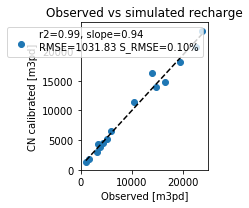


 RMSE is 1031.8335453484467
LU code 400, factored by 0.7499999940587252, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8569571748293635, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7815053017056512, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8433524959551733, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1453716613415894, trying CN set of [32 62 80 87] 
LU code 1700, factored by 0.9233571481039525, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 72 76] 
LU code 2100, factored by 0.7953662585188987, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.009099932497449 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0089883511736542 %

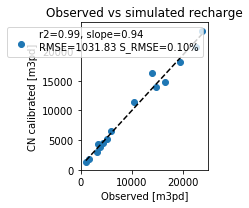


 RMSE is 1031.8335453484467
LU code 400, factored by 0.7599999940587252, trying CN set of [41 54 62 64] 
LU code 500, factored by 0.8569571748293635, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7815053017056512, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8433524959551733, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1453716613415894, trying CN set of [32 62 80 87] 
LU code 1700, factored by 0.9233571481039525, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 72 76] 
LU code 2100, factored by 0.7953662585188987, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091371448975122 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090245846096693 

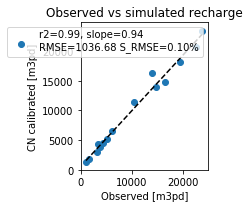


 RMSE is 1036.683188016298
LU code 400, factored by 0.7499999940587252, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8669571748293635, trying CN set of [38 56 66 71] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7815053017056512, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8433524959551733, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1453716613415894, trying CN set of [32 62 80 87] 
LU code 1700, factored by 0.9233571481039525, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 72 76] 
LU code 2100, factored by 0.7953662585188987, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091125696783405 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090006513573058 %

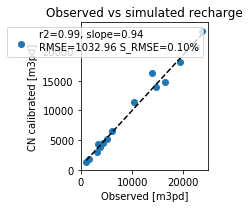


 RMSE is 1032.9615245818718
LU code 400, factored by 0.7499999940587252, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8569571748293635, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.84802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7815053017056512, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8433524959551733, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1453716613415894, trying CN set of [32 62 80 87] 
LU code 1700, factored by 0.9233571481039525, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 72 76] 
LU code 2100, factored by 0.7953662585188987, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.009099932497449 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0089883511736542 %

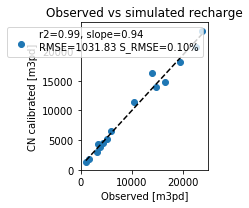


 RMSE is 1031.8335453484467
LU code 400, factored by 0.7499999940587252, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8569571748293635, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7915053017056513, trying CN set of [47 59 66 68] 
LU code 1000, factored by 0.8433524959551733, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1453716613415894, trying CN set of [32 62 80 87] 
LU code 1700, factored by 0.9233571481039525, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 72 76] 
LU code 2100, factored by 0.7953662585188987, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.00911639249653 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090044935172644 % 

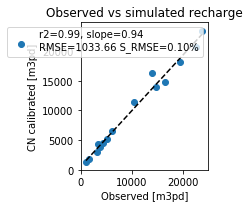


 RMSE is 1033.6610500484164
LU code 400, factored by 0.7499999940587252, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8569571748293635, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7815053017056512, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8533524959551733, trying CN set of [69 75 78 80] 
LU code 1600, factored by 1.1453716613415894, trying CN set of [32 62 80 87] 
LU code 1700, factored by 0.9233571481039525, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 72 76] 
LU code 2100, factored by 0.7953662585188987, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0092504138563556 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.009136953157499 %

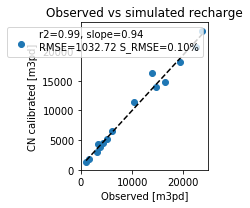


 RMSE is 1032.7161913868583
LU code 400, factored by 0.7499999940587252, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8569571748293635, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7815053017056512, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8433524959551733, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1553716613415894, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9233571481039525, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 70 85 91] 
LU code 1500, factored by 0.89, trying CN set of [43 61 72 76] 
LU code 2100, factored by 0.7953662585188987, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091504530768303 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090373830975605 

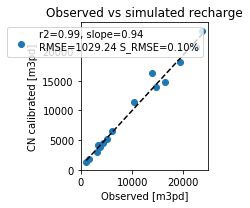


 RMSE is 1029.2363595329668
LU code 400, factored by 0.7499999940587252, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8569571748293635, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7815053017056512, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8433524959551733, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1453716613415894, trying CN set of [32 62 80 87] 
LU code 1700, factored by 0.9333571481039525, trying CN set of [33 56 69 73] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 62 72 77] 
LU code 2100, factored by 0.7953662585188987, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091044779925977 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.00899279876523 % 

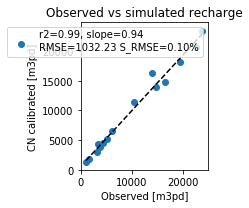


 RMSE is 1032.2262352170249
LU code 400, factored by 0.7499999940587252, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8569571748293635, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7815053017056512, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8433524959551733, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1453716613415894, trying CN set of [32 62 80 87] 
LU code 1700, factored by 0.9233571481039525, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.89, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 72 76] 
LU code 2100, factored by 0.7953662585188987, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.009099932497449 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0089883511736542 %

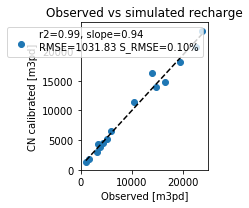


 RMSE is 1031.8335453484467
LU code 400, factored by 0.7499999940587252, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8569571748293635, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7815053017056512, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8433524959551733, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1453716613415894, trying CN set of [32 62 80 87] 
LU code 1700, factored by 0.9233571481039525, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.9, trying CN set of [43 61 72 76] 
LU code 2100, factored by 0.7953662585188987, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.009099932497449 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0089883511736542 % 

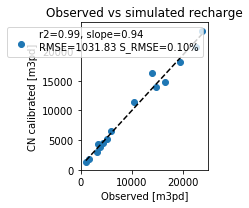


 RMSE is 1031.8335453484467
LU code 400, factored by 0.7499999940587252, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8569571748293635, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7815053017056512, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8433524959551733, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1453716613415894, trying CN set of [32 62 80 87] 
LU code 1700, factored by 0.9233571481039525, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 72 76] 
LU code 2100, factored by 0.8053662585188988, trying CN set of [25 44 56 61] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091014538674652 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0089898520141443 

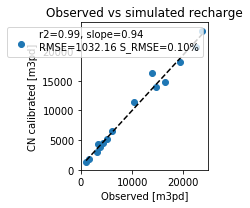


 RMSE is 1032.1608378330732
LU code 400, factored by 0.7, trying CN set of [38 50 57 59] 
LU code 500, factored by 0.8134426429913787, trying CN set of [35 52 62 66] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7117025408344531, trying CN set of [42 53 59 61] 
LU code 1000, factored by 0.8093124423832833, trying CN set of [65 71 74 76] 
LU code 1600, factored by 1.2408190900937484, trying CN set of [34 68 86 94] 
LU code 1700, factored by 0.907400579614088, trying CN set of [32 54 67 71] 
LU code 1400, factored by 0.88, trying CN set of [45 75 91 98] 
LU code 1500, factored by 0.89, trying CN set of [42 60 70 75] 
LU code 2100, factored by 0.7829017528628985, trying CN set of [25 43 54 59] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.014397635114988 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0141806480747966 % 


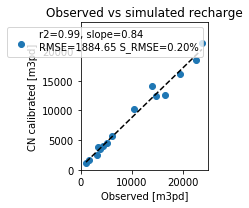


 RMSE is 1884.647780388991
LU code 400, factored by 0.7, trying CN set of [38 50 57 59] 
LU code 500, factored by 0.8134426429913787, trying CN set of [35 52 62 66] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7117025408344531, trying CN set of [42 53 59 61] 
LU code 1000, factored by 0.8093124423832833, trying CN set of [65 71 74 76] 
LU code 1600, factored by 1.2408190900937484, trying CN set of [34 68 86 94] 
LU code 1700, factored by 0.907400579614088, trying CN set of [32 54 67 71] 
LU code 1400, factored by 0.88, trying CN set of [45 75 91 98] 
LU code 1500, factored by 0.89, trying CN set of [42 60 70 75] 
LU code 2100, factored by 0.7829017528628985, trying CN set of [25 43 54 59] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.014397635114988 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0141806480747966 % 


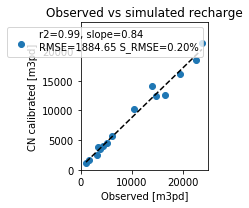


 RMSE is 1884.647780388991
LU code 400, factored by 0.71, trying CN set of [39 51 58 60] 
LU code 500, factored by 0.8134426429913787, trying CN set of [35 52 62 66] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7117025408344531, trying CN set of [42 53 59 61] 
LU code 1000, factored by 0.8093124423832833, trying CN set of [65 71 74 76] 
LU code 1600, factored by 1.2408190900937484, trying CN set of [34 68 86 94] 
LU code 1700, factored by 0.907400579614088, trying CN set of [32 54 67 71] 
LU code 1400, factored by 0.88, trying CN set of [45 75 91 98] 
LU code 1500, factored by 0.89, trying CN set of [42 60 70 75] 
LU code 2100, factored by 0.7829017528628985, trying CN set of [25 43 54 59] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0144311365795722 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0142129161493325 % 


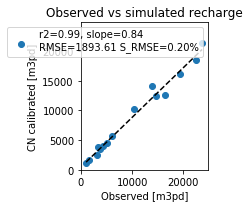


 RMSE is 1893.6078411568974
LU code 400, factored by 0.7, trying CN set of [38 50 57 59] 
LU code 500, factored by 0.8234426429913787, trying CN set of [36 53 63 67] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7117025408344531, trying CN set of [42 53 59 61] 
LU code 1000, factored by 0.8093124423832833, trying CN set of [65 71 74 76] 
LU code 1600, factored by 1.2408190900937484, trying CN set of [34 68 86 94] 
LU code 1700, factored by 0.907400579614088, trying CN set of [32 54 67 71] 
LU code 1400, factored by 0.88, trying CN set of [45 75 91 98] 
LU code 1500, factored by 0.89, trying CN set of [42 60 70 75] 
LU code 2100, factored by 0.7829017528628985, trying CN set of [25 43 54 59] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0144086590192498 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.014191247744261 % 


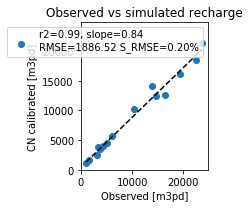


 RMSE is 1886.519007088141
LU code 400, factored by 0.7, trying CN set of [38 50 57 59] 
LU code 500, factored by 0.8134426429913787, trying CN set of [35 52 62 66] 
LU code 700, factored by 0.84802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7117025408344531, trying CN set of [42 53 59 61] 
LU code 1000, factored by 0.8093124423832833, trying CN set of [65 71 74 76] 
LU code 1600, factored by 1.2408190900937484, trying CN set of [34 68 86 94] 
LU code 1700, factored by 0.907400579614088, trying CN set of [32 54 67 71] 
LU code 1400, factored by 0.88, trying CN set of [45 75 91 98] 
LU code 1500, factored by 0.89, trying CN set of [42 60 70 75] 
LU code 2100, factored by 0.7829017528628985, trying CN set of [25 43 54 59] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.014397635114988 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0141806480747966 % 


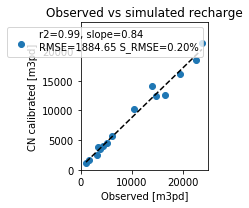


 RMSE is 1884.647780388991
LU code 400, factored by 0.7, trying CN set of [38 50 57 59] 
LU code 500, factored by 0.8134426429913787, trying CN set of [35 52 62 66] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7217025408344531, trying CN set of [43 54 60 62] 
LU code 1000, factored by 0.8093124423832833, trying CN set of [65 71 74 76] 
LU code 1600, factored by 1.2408190900937484, trying CN set of [34 68 86 94] 
LU code 1700, factored by 0.907400579614088, trying CN set of [32 54 67 71] 
LU code 1400, factored by 0.88, trying CN set of [45 75 91 98] 
LU code 1500, factored by 0.89, trying CN set of [42 60 70 75] 
LU code 2100, factored by 0.7829017528628985, trying CN set of [25 43 54 59] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.014410896536893 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0141935615068345 % 


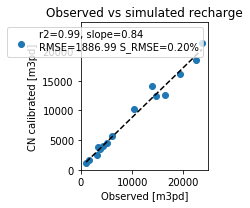


 RMSE is 1886.9888771976384
LU code 400, factored by 0.7, trying CN set of [38 50 57 59] 
LU code 500, factored by 0.8134426429913787, trying CN set of [35 52 62 66] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7117025408344531, trying CN set of [42 53 59 61] 
LU code 1000, factored by 0.8193124423832833, trying CN set of [66 72 75 77] 
LU code 1600, factored by 1.2408190900937484, trying CN set of [34 68 86 94] 
LU code 1700, factored by 0.907400579614088, trying CN set of [32 54 67 71] 
LU code 1400, factored by 0.88, trying CN set of [45 75 91 98] 
LU code 1500, factored by 0.89, trying CN set of [42 60 70 75] 
LU code 2100, factored by 0.7829017528628985, trying CN set of [25 43 54 59] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0145275642679796 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.014308572542106 % 


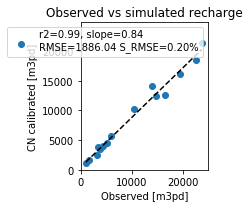


 RMSE is 1886.0420090435437
LU code 400, factored by 0.7, trying CN set of [38 50 57 59] 
LU code 500, factored by 0.8134426429913787, trying CN set of [35 52 62 66] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7117025408344531, trying CN set of [42 53 59 61] 
LU code 1000, factored by 0.8093124423832833, trying CN set of [65 71 74 76] 
LU code 1600, factored by 1.2508190900937484, trying CN set of [35 68 87 95] 
LU code 1700, factored by 0.907400579614088, trying CN set of [32 54 67 71] 
LU code 1400, factored by 0.88, trying CN set of [46 76 92 98] 
LU code 1500, factored by 0.89, trying CN set of [42 60 70 75] 
LU code 2100, factored by 0.7829017528628985, trying CN set of [25 43 54 59] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0155939453140088 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0153505252333472 % 


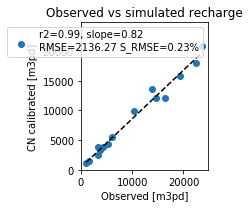


 RMSE is 2136.2721890257385
LU code 400, factored by 0.7, trying CN set of [38 50 57 59] 
LU code 500, factored by 0.8134426429913787, trying CN set of [35 52 62 66] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7117025408344531, trying CN set of [42 53 59 61] 
LU code 1000, factored by 0.8093124423832833, trying CN set of [65 71 74 76] 
LU code 1600, factored by 1.2408190900937484, trying CN set of [34 68 86 94] 
LU code 1700, factored by 0.917400579614088, trying CN set of [33 55 67 72] 
LU code 1400, factored by 0.88, trying CN set of [45 75 91 98] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7829017528628985, trying CN set of [25 43 54 59] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0144075546553304 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0141903727855137 % 


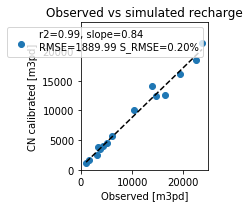


 RMSE is 1889.9881835723816
LU code 400, factored by 0.7, trying CN set of [38 50 57 59] 
LU code 500, factored by 0.8134426429913787, trying CN set of [35 52 62 66] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7117025408344531, trying CN set of [42 53 59 61] 
LU code 1000, factored by 0.8093124423832833, trying CN set of [65 71 74 76] 
LU code 1600, factored by 1.2408190900937484, trying CN set of [34 68 86 94] 
LU code 1700, factored by 0.907400579614088, trying CN set of [32 54 67 71] 
LU code 1400, factored by 0.89, trying CN set of [45 75 91 98] 
LU code 1500, factored by 0.89, trying CN set of [42 60 70 75] 
LU code 2100, factored by 0.7829017528628985, trying CN set of [25 43 54 59] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.014397635114988 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0141806480747966 % 


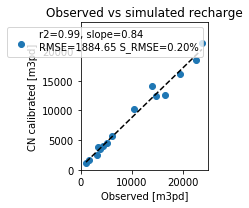


 RMSE is 1884.647780388991
LU code 400, factored by 0.7, trying CN set of [38 50 57 59] 
LU code 500, factored by 0.8134426429913787, trying CN set of [35 52 62 66] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7117025408344531, trying CN set of [42 53 59 61] 
LU code 1000, factored by 0.8093124423832833, trying CN set of [65 71 74 76] 
LU code 1600, factored by 1.2408190900937484, trying CN set of [34 68 86 94] 
LU code 1700, factored by 0.907400579614088, trying CN set of [32 54 67 71] 
LU code 1400, factored by 0.88, trying CN set of [45 75 91 98] 
LU code 1500, factored by 0.9, trying CN set of [42 60 70 75] 
LU code 2100, factored by 0.7829017528628985, trying CN set of [25 43 54 59] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.014397635114988 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0141806480747966 % 


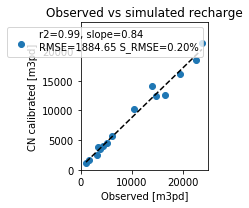


 RMSE is 1884.647780388991
LU code 400, factored by 0.7, trying CN set of [38 50 57 59] 
LU code 500, factored by 0.8134426429913787, trying CN set of [35 52 62 66] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7117025408344531, trying CN set of [42 53 59 61] 
LU code 1000, factored by 0.8093124423832833, trying CN set of [65 71 74 76] 
LU code 1600, factored by 1.2408190900937484, trying CN set of [34 68 86 94] 
LU code 1700, factored by 0.907400579614088, trying CN set of [32 54 67 71] 
LU code 1400, factored by 0.88, trying CN set of [45 75 91 98] 
LU code 1500, factored by 0.89, trying CN set of [42 60 70 75] 
LU code 2100, factored by 0.7929017528628985, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0143991118199196 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0141821025242868 % 


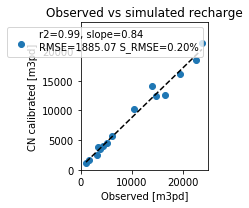


 RMSE is 1885.0737687361552
LU code 400, factored by 0.725, trying CN set of [39 52 59 61] 
LU code 500, factored by 0.8351999114956894, trying CN set of [36 54 64 68] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7466039254172265, trying CN set of [44 55 62 64] 
LU code 1000, factored by 0.8263324711916415, trying CN set of [66 72 76 77] 
LU code 1600, factored by 1.193095370046874, trying CN set of [33 65 83 90] 
LU code 1700, factored by 0.915378864807044, trying CN set of [32 54 67 72] 
LU code 1400, factored by 0.88, trying CN set of [44 72 88 94] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 75] 
LU code 2100, factored by 0.7891340064314493, trying CN set of [25 43 55 59] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.011415016108577 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0112603059512204 % 


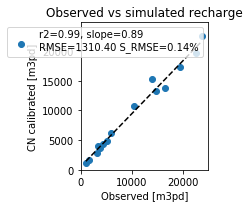


 RMSE is 1310.4036184336694
LU code 400, factored by 0.725, trying CN set of [39 52 59 61] 
LU code 500, factored by 0.8351999114956894, trying CN set of [36 54 64 68] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7466039254172265, trying CN set of [44 55 62 64] 
LU code 1000, factored by 0.8263324711916415, trying CN set of [66 72 76 77] 
LU code 1600, factored by 1.193095370046874, trying CN set of [33 65 83 90] 
LU code 1700, factored by 0.915378864807044, trying CN set of [32 54 67 72] 
LU code 1400, factored by 0.88, trying CN set of [44 72 88 94] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 75] 
LU code 2100, factored by 0.7891340064314493, trying CN set of [25 43 55 59] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.011415016108577 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0112603059512204 % 


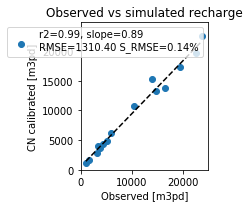


 RMSE is 1310.4036184336694
LU code 400, factored by 0.735, trying CN set of [40 52 60 62] 
LU code 500, factored by 0.8351999114956894, trying CN set of [36 54 64 68] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7466039254172265, trying CN set of [44 55 62 64] 
LU code 1000, factored by 0.8263324711916415, trying CN set of [66 72 76 77] 
LU code 1600, factored by 1.193095370046874, trying CN set of [33 65 83 90] 
LU code 1700, factored by 0.915378864807044, trying CN set of [32 54 67 72] 
LU code 1400, factored by 0.88, trying CN set of [44 72 88 94] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 75] 
LU code 2100, factored by 0.7891340064314493, trying CN set of [25 43 55 59] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0114315179582745 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.01127620853716 % 


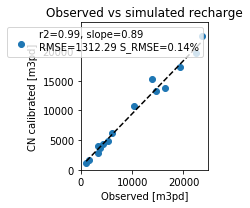


 RMSE is 1312.2879250779488
LU code 400, factored by 0.725, trying CN set of [39 52 59 61] 
LU code 500, factored by 0.8451999114956894, trying CN set of [37 54 65 69] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7466039254172265, trying CN set of [44 55 62 64] 
LU code 1000, factored by 0.8263324711916415, trying CN set of [66 72 76 77] 
LU code 1600, factored by 1.193095370046874, trying CN set of [33 65 83 90] 
LU code 1700, factored by 0.915378864807044, trying CN set of [32 54 67 72] 
LU code 1400, factored by 0.88, trying CN set of [44 72 88 94] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 75] 
LU code 2100, factored by 0.7891340064314493, trying CN set of [25 43 55 59] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0114222001530542 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0112672266658653 % 


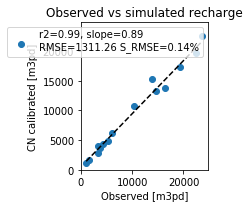


 RMSE is 1311.2595573397139
LU code 400, factored by 0.725, trying CN set of [39 52 59 61] 
LU code 500, factored by 0.8351999114956894, trying CN set of [36 54 64 68] 
LU code 700, factored by 0.84802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7466039254172265, trying CN set of [44 55 62 64] 
LU code 1000, factored by 0.8263324711916415, trying CN set of [66 72 76 77] 
LU code 1600, factored by 1.193095370046874, trying CN set of [33 65 83 90] 
LU code 1700, factored by 0.915378864807044, trying CN set of [32 54 67 72] 
LU code 1400, factored by 0.88, trying CN set of [44 72 88 94] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 75] 
LU code 2100, factored by 0.7891340064314493, trying CN set of [25 43 55 59] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.011415016108577 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0112603059512204 % 


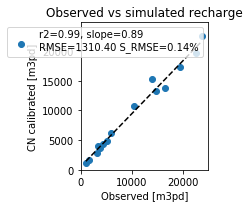


 RMSE is 1310.4036184336694
LU code 400, factored by 0.725, trying CN set of [39 52 59 61] 
LU code 500, factored by 0.8351999114956894, trying CN set of [36 54 64 68] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7566039254172265, trying CN set of [45 56 63 65] 
LU code 1000, factored by 0.8263324711916415, trying CN set of [66 72 76 77] 
LU code 1600, factored by 1.193095370046874, trying CN set of [33 65 83 90] 
LU code 1700, factored by 0.915378864807044, trying CN set of [32 54 67 72] 
LU code 1400, factored by 0.88, trying CN set of [44 72 88 94] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 75] 
LU code 2100, factored by 0.7891340064314493, trying CN set of [25 43 55 59] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0114296433375958 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0112746047740737 % 


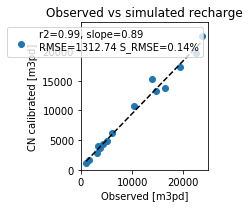


 RMSE is 1312.737210400445
LU code 400, factored by 0.725, trying CN set of [39 52 59 61] 
LU code 500, factored by 0.8351999114956894, trying CN set of [36 54 64 68] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7466039254172265, trying CN set of [44 55 62 64] 
LU code 1000, factored by 0.8363324711916416, trying CN set of [67 73 76 78] 
LU code 1600, factored by 1.193095370046874, trying CN set of [33 65 83 90] 
LU code 1700, factored by 0.915378864807044, trying CN set of [32 54 67 72] 
LU code 1400, factored by 0.88, trying CN set of [44 72 88 94] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 75] 
LU code 2100, factored by 0.7891340064314493, trying CN set of [25 43 55 59] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0115258958189397 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.01136967344392 % 


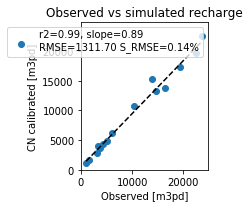


 RMSE is 1311.7029416204073
LU code 400, factored by 0.725, trying CN set of [39 52 59 61] 
LU code 500, factored by 0.8351999114956894, trying CN set of [36 54 64 68] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7466039254172265, trying CN set of [44 55 62 64] 
LU code 1000, factored by 0.8263324711916415, trying CN set of [66 72 76 77] 
LU code 1600, factored by 1.203095370046874, trying CN set of [33 66 84 91] 
LU code 1700, factored by 0.915378864807044, trying CN set of [32 54 67 72] 
LU code 1400, factored by 0.88, trying CN set of [44 73 89 95] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 75] 
LU code 2100, factored by 0.7891340064314493, trying CN set of [25 43 55 59] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0124269866980486 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0122519652202064 % 


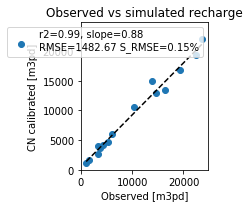


 RMSE is 1482.6661769511163
LU code 400, factored by 0.725, trying CN set of [39 52 59 61] 
LU code 500, factored by 0.8351999114956894, trying CN set of [36 54 64 68] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7466039254172265, trying CN set of [44 55 62 64] 
LU code 1000, factored by 0.8263324711916415, trying CN set of [66 72 76 77] 
LU code 1600, factored by 1.193095370046874, trying CN set of [33 65 83 90] 
LU code 1700, factored by 0.925378864807044, trying CN set of [33 55 68 73] 
LU code 1400, factored by 0.88, trying CN set of [44 72 88 94] 
LU code 1500, factored by 0.89, trying CN set of [43 62 72 76] 
LU code 2100, factored by 0.7891340064314493, trying CN set of [25 43 55 59] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0114274312029758 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0112724961863884 % 


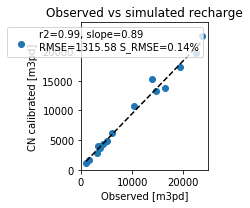


 RMSE is 1315.582945191935
LU code 400, factored by 0.725, trying CN set of [39 52 59 61] 
LU code 500, factored by 0.8351999114956894, trying CN set of [36 54 64 68] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7466039254172265, trying CN set of [44 55 62 64] 
LU code 1000, factored by 0.8263324711916415, trying CN set of [66 72 76 77] 
LU code 1600, factored by 1.193095370046874, trying CN set of [33 65 83 90] 
LU code 1700, factored by 0.915378864807044, trying CN set of [32 54 67 72] 
LU code 1400, factored by 0.89, trying CN set of [44 72 88 94] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 75] 
LU code 2100, factored by 0.7891340064314493, trying CN set of [25 43 55 59] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.011415016108577 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0112603059512204 % 


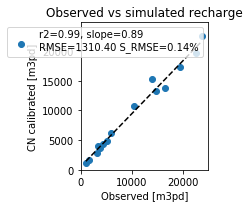


 RMSE is 1310.4036184336694
LU code 400, factored by 0.725, trying CN set of [39 52 59 61] 
LU code 500, factored by 0.8351999114956894, trying CN set of [36 54 64 68] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7466039254172265, trying CN set of [44 55 62 64] 
LU code 1000, factored by 0.8263324711916415, trying CN set of [66 72 76 77] 
LU code 1600, factored by 1.193095370046874, trying CN set of [33 65 83 90] 
LU code 1700, factored by 0.915378864807044, trying CN set of [32 54 67 72] 
LU code 1400, factored by 0.88, trying CN set of [44 72 88 94] 
LU code 1500, factored by 0.9, trying CN set of [43 61 71 75] 
LU code 2100, factored by 0.7891340064314493, trying CN set of [25 43 55 59] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.011415016108577 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0112603059512204 % 


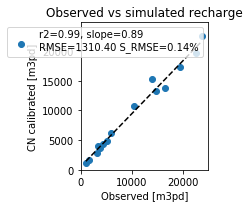


 RMSE is 1310.4036184336694
LU code 400, factored by 0.725, trying CN set of [39 52 59 61] 
LU code 500, factored by 0.8351999114956894, trying CN set of [36 54 64 68] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7466039254172265, trying CN set of [44 55 62 64] 
LU code 1000, factored by 0.8263324711916415, trying CN set of [66 72 76 77] 
LU code 1600, factored by 1.193095370046874, trying CN set of [33 65 83 90] 
LU code 1700, factored by 0.915378864807044, trying CN set of [32 54 67 72] 
LU code 1400, factored by 0.88, trying CN set of [44 72 88 94] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 75] 
LU code 2100, factored by 0.7991340064314493, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.011415016108577 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0112603059512204 % 


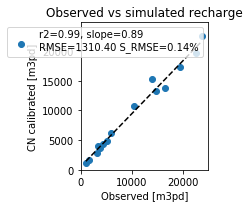


 RMSE is 1310.4036184336694
LU code 400, factored by 0.7374999999999999, trying CN set of [40 53 60 62] 
LU code 500, factored by 0.8460785457478446, trying CN set of [37 54 65 69] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7640546177086133, trying CN set of [45 57 64 66] 
LU code 1000, factored by 0.8348424855958207, trying CN set of [67 73 76 78] 
LU code 1600, factored by 1.169233510023437, trying CN set of [32 64 81 88] 
LU code 1700, factored by 0.919368007403522, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [43 71 86 92] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7922501332157247, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0098037083734015 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0096786471691002 % 

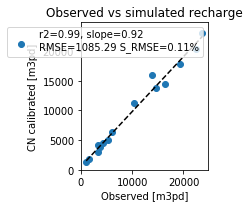


 RMSE is 1085.2927235114244
LU code 400, factored by 0.7374999999999999, trying CN set of [40 53 60 62] 
LU code 500, factored by 0.8460785457478446, trying CN set of [37 54 65 69] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7640546177086133, trying CN set of [45 57 64 66] 
LU code 1000, factored by 0.8348424855958207, trying CN set of [67 73 76 78] 
LU code 1600, factored by 1.169233510023437, trying CN set of [32 64 81 88] 
LU code 1700, factored by 0.919368007403522, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [43 71 86 92] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7922501332157247, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0098037083734015 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0096786471691002 % 

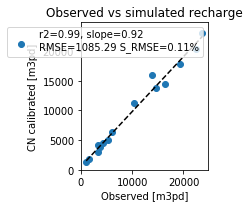


 RMSE is 1085.2927235114244
LU code 400, factored by 0.7474999999999999, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8460785457478446, trying CN set of [37 54 65 69] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7640546177086133, trying CN set of [45 57 64 66] 
LU code 1000, factored by 0.8348424855958207, trying CN set of [67 73 76 78] 
LU code 1600, factored by 1.169233510023437, trying CN set of [32 64 81 88] 
LU code 1700, factored by 0.919368007403522, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [43 71 86 92] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7922501332157247, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0098209441873802 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0096953292868025 % 

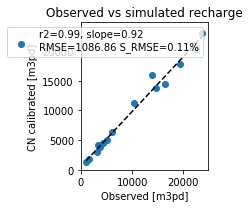


 RMSE is 1086.8635353665911
LU code 400, factored by 0.7374999999999999, trying CN set of [40 53 60 62] 
LU code 500, factored by 0.8560785457478446, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7640546177086133, trying CN set of [45 57 64 66] 
LU code 1000, factored by 0.8348424855958207, trying CN set of [67 73 76 78] 
LU code 1600, factored by 1.169233510023437, trying CN set of [32 64 81 88] 
LU code 1700, factored by 0.919368007403522, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [43 71 86 92] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7922501332157247, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.009809811317063 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.009684625893827 % 


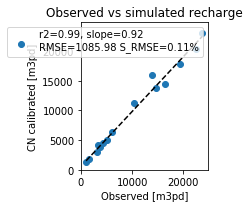


 RMSE is 1085.9803528957448
LU code 400, factored by 0.7374999999999999, trying CN set of [40 53 60 62] 
LU code 500, factored by 0.8460785457478446, trying CN set of [37 54 65 69] 
LU code 700, factored by 0.84802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7640546177086133, trying CN set of [45 57 64 66] 
LU code 1000, factored by 0.8348424855958207, trying CN set of [67 73 76 78] 
LU code 1600, factored by 1.169233510023437, trying CN set of [32 64 81 88] 
LU code 1700, factored by 0.919368007403522, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [43 71 86 92] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7922501332157247, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0098037083734015 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0096786471691002 % 

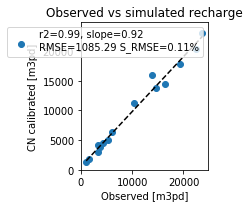


 RMSE is 1085.2927235114244
LU code 400, factored by 0.7374999999999999, trying CN set of [40 53 60 62] 
LU code 500, factored by 0.8460785457478446, trying CN set of [37 54 65 69] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7740546177086133, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8348424855958207, trying CN set of [67 73 76 78] 
LU code 1600, factored by 1.169233510023437, trying CN set of [32 64 81 88] 
LU code 1700, factored by 0.919368007403522, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [43 71 86 92] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7922501332157247, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0098194943462753 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.009694111675612 % 


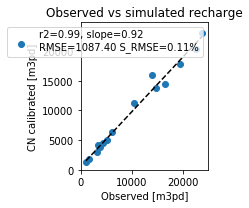


 RMSE is 1087.4024105166457
LU code 400, factored by 0.7374999999999999, trying CN set of [40 53 60 62] 
LU code 500, factored by 0.8460785457478446, trying CN set of [37 54 65 69] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7640546177086133, trying CN set of [45 57 64 66] 
LU code 1000, factored by 0.8448424855958208, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.169233510023437, trying CN set of [32 64 81 88] 
LU code 1700, factored by 0.919368007403522, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [43 71 86 92] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7922501332157247, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0099467455687225 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0098198249882877 % 

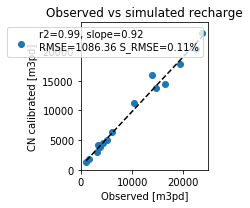


 RMSE is 1086.3644230490956
LU code 400, factored by 0.7374999999999999, trying CN set of [40 53 60 62] 
LU code 500, factored by 0.8460785457478446, trying CN set of [37 54 65 69] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7640546177086133, trying CN set of [45 57 64 66] 
LU code 1000, factored by 0.8348424855958207, trying CN set of [67 73 76 78] 
LU code 1600, factored by 1.179233510023437, trying CN set of [33 64 82 89] 
LU code 1700, factored by 0.919368007403522, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [43 71 87 93] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7922501332157247, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0106539318230805 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0105138654507049 % 

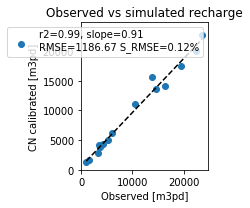


 RMSE is 1186.6711301169162
LU code 400, factored by 0.7374999999999999, trying CN set of [40 53 60 62] 
LU code 500, factored by 0.8460785457478446, trying CN set of [37 54 65 69] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7640546177086133, trying CN set of [45 57 64 66] 
LU code 1000, factored by 0.8348424855958207, trying CN set of [67 73 76 78] 
LU code 1600, factored by 1.169233510023437, trying CN set of [32 64 81 88] 
LU code 1700, factored by 0.929368007403522, trying CN set of [33 55 68 73] 
LU code 1400, factored by 0.88, trying CN set of [43 71 86 92] 
LU code 1500, factored by 0.89, trying CN set of [43 62 72 77] 
LU code 2100, factored by 0.7922501332157247, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.009811751103686 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0096865825726242 % 


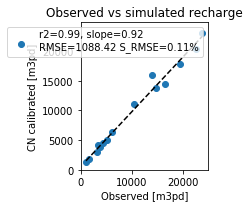


 RMSE is 1088.416242889184
LU code 400, factored by 0.7374999999999999, trying CN set of [40 53 60 62] 
LU code 500, factored by 0.8460785457478446, trying CN set of [37 54 65 69] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7640546177086133, trying CN set of [45 57 64 66] 
LU code 1000, factored by 0.8348424855958207, trying CN set of [67 73 76 78] 
LU code 1600, factored by 1.169233510023437, trying CN set of [32 64 81 88] 
LU code 1700, factored by 0.919368007403522, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.89, trying CN set of [43 71 86 92] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7922501332157247, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0098037083734015 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0096786471691002 % 


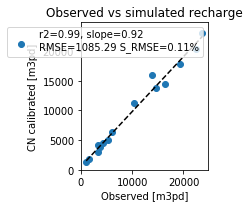


 RMSE is 1085.2927235114244
LU code 400, factored by 0.7374999999999999, trying CN set of [40 53 60 62] 
LU code 500, factored by 0.8460785457478446, trying CN set of [37 54 65 69] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7640546177086133, trying CN set of [45 57 64 66] 
LU code 1000, factored by 0.8348424855958207, trying CN set of [67 73 76 78] 
LU code 1600, factored by 1.169233510023437, trying CN set of [32 64 81 88] 
LU code 1700, factored by 0.919368007403522, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [43 71 86 92] 
LU code 1500, factored by 0.9, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7922501332157247, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0098037083734015 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0096786471691002 % 


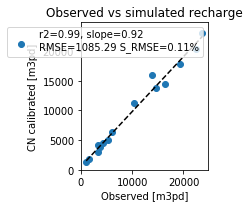


 RMSE is 1085.2927235114244
LU code 400, factored by 0.7374999999999999, trying CN set of [40 53 60 62] 
LU code 500, factored by 0.8460785457478446, trying CN set of [37 54 65 69] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7640546177086133, trying CN set of [45 57 64 66] 
LU code 1000, factored by 0.8348424855958207, trying CN set of [67 73 76 78] 
LU code 1600, factored by 1.169233510023437, trying CN set of [32 64 81 88] 
LU code 1700, factored by 0.919368007403522, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [43 71 86 92] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.8022501332157247, trying CN set of [25 44 56 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0098052297437685 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.009680147285616 % 


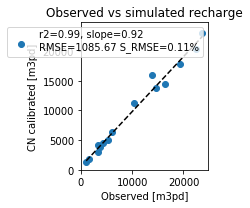


 RMSE is 1085.6681803307179
LU code 400, factored by 0.7437499999999999, trying CN set of [40 53 60 63] 
LU code 500, factored by 0.8515178628739223, trying CN set of [37 55 65 69] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7727799638543067, trying CN set of [46 57 64 67] 
LU code 1000, factored by 0.8390974927979103, trying CN set of [67 73 77 78] 
LU code 1600, factored by 1.1573025800117185, trying CN set of [32 63 81 87] 
LU code 1700, factored by 0.921362578701761, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 70 85 91] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7938081966078623, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0097757994860679 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0096519910272441 %

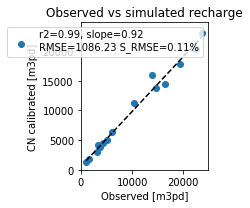


 RMSE is 1086.230230812917
LU code 400, factored by 0.7437499999999999, trying CN set of [40 53 60 63] 
LU code 500, factored by 0.8515178628739223, trying CN set of [37 55 65 69] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7727799638543067, trying CN set of [46 57 64 67] 
LU code 1000, factored by 0.8390974927979103, trying CN set of [67 73 77 78] 
LU code 1600, factored by 1.1573025800117185, trying CN set of [32 63 81 87] 
LU code 1700, factored by 0.921362578701761, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 70 85 91] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7938081966078623, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0097757994860679 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0096519910272441 % 

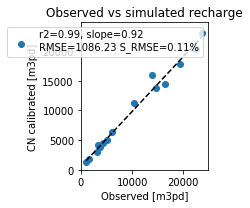


 RMSE is 1086.230230812917
LU code 400, factored by 0.7537499999999999, trying CN set of [41 54 61 64] 
LU code 500, factored by 0.8515178628739223, trying CN set of [37 55 65 69] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7727799638543067, trying CN set of [46 57 64 67] 
LU code 1000, factored by 0.8390974927979103, trying CN set of [67 73 77 78] 
LU code 1600, factored by 1.1573025800117185, trying CN set of [32 63 81 87] 
LU code 1700, factored by 0.921362578701761, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 70 85 91] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7938081966078623, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.009813076246696 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0096882486566057 % 


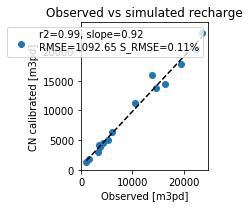


 RMSE is 1092.6474908658242
LU code 400, factored by 0.7437499999999999, trying CN set of [40 53 60 63] 
LU code 500, factored by 0.8615178628739223, trying CN set of [37 55 66 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7727799638543067, trying CN set of [46 57 64 67] 
LU code 1000, factored by 0.8390974927979103, trying CN set of [67 73 77 78] 
LU code 1600, factored by 1.1573025800117185, trying CN set of [32 63 81 87] 
LU code 1700, factored by 0.921362578701761, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 70 85 91] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7938081966078623, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0097832802099966 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0096592293311373 %

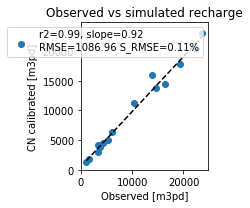


 RMSE is 1086.9574002661718
LU code 400, factored by 0.7437499999999999, trying CN set of [40 53 60 63] 
LU code 500, factored by 0.8515178628739223, trying CN set of [37 55 65 69] 
LU code 700, factored by 0.84802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7727799638543067, trying CN set of [46 57 64 67] 
LU code 1000, factored by 0.8390974927979103, trying CN set of [67 73 77 78] 
LU code 1600, factored by 1.1573025800117185, trying CN set of [32 63 81 87] 
LU code 1700, factored by 0.921362578701761, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 70 85 91] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7938081966078623, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0097757994860679 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0096519910272441 %

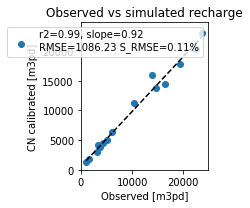


 RMSE is 1086.230230812917
LU code 400, factored by 0.7437499999999999, trying CN set of [40 53 60 63] 
LU code 500, factored by 0.8515178628739223, trying CN set of [37 55 65 69] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7827799638543067, trying CN set of [46 58 65 68] 
LU code 1000, factored by 0.8390974927979103, trying CN set of [67 73 77 78] 
LU code 1600, factored by 1.1573025800117185, trying CN set of [32 63 81 87] 
LU code 1700, factored by 0.921362578701761, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 70 85 91] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7938081966078623, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0097905939268546 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0096664782875067 % 

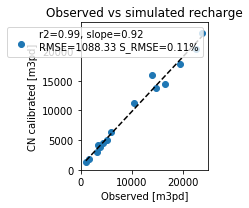


 RMSE is 1088.3286980340235
LU code 400, factored by 0.7437499999999999, trying CN set of [40 53 60 63] 
LU code 500, factored by 0.8515178628739223, trying CN set of [37 55 65 69] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7727799638543067, trying CN set of [46 57 64 67] 
LU code 1000, factored by 0.8490974927979104, trying CN set of [68 74 78 79] 
LU code 1600, factored by 1.1573025800117185, trying CN set of [32 63 81 87] 
LU code 1700, factored by 0.921362578701761, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 70 85 91] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7938081966078623, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0099203923262552 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0097947169797719 %

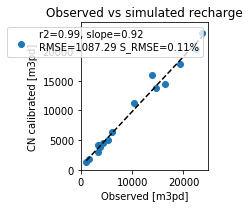


 RMSE is 1087.2938723941422
LU code 400, factored by 0.7437499999999999, trying CN set of [40 53 60 63] 
LU code 500, factored by 0.8515178628739223, trying CN set of [37 55 65 69] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7727799638543067, trying CN set of [46 57 64 67] 
LU code 1000, factored by 0.8390974927979103, trying CN set of [67 73 77 78] 
LU code 1600, factored by 1.1673025800117185, trying CN set of [32 64 81 88] 
LU code 1700, factored by 0.921362578701761, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [43 71 86 92] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7938081966078623, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0098398975594516 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0097143021222403 %

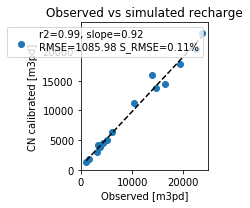


 RMSE is 1085.9786634045327
LU code 400, factored by 0.7437499999999999, trying CN set of [40 53 60 63] 
LU code 500, factored by 0.8515178628739223, trying CN set of [37 55 65 69] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7727799638543067, trying CN set of [46 57 64 67] 
LU code 1000, factored by 0.8390974927979103, trying CN set of [67 73 77 78] 
LU code 1600, factored by 1.1573025800117185, trying CN set of [32 63 81 87] 
LU code 1700, factored by 0.931362578701761, trying CN set of [33 55 68 73] 
LU code 1400, factored by 0.88, trying CN set of [42 70 85 91] 
LU code 1500, factored by 0.89, trying CN set of [43 62 72 77] 
LU code 2100, factored by 0.7938081966078623, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0097838422163523 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0096599271170152 %

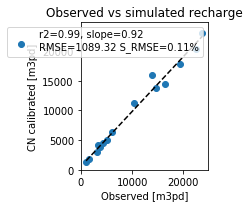


 RMSE is 1089.3174739756116
LU code 400, factored by 0.7437499999999999, trying CN set of [40 53 60 63] 
LU code 500, factored by 0.8515178628739223, trying CN set of [37 55 65 69] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7727799638543067, trying CN set of [46 57 64 67] 
LU code 1000, factored by 0.8390974927979103, trying CN set of [67 73 77 78] 
LU code 1600, factored by 1.1573025800117185, trying CN set of [32 63 81 87] 
LU code 1700, factored by 0.921362578701761, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.89, trying CN set of [42 70 85 91] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7938081966078623, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0097757994860679 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0096519910272441 %

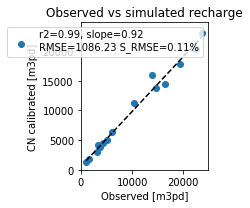


 RMSE is 1086.230230812917
LU code 400, factored by 0.7437499999999999, trying CN set of [40 53 60 63] 
LU code 500, factored by 0.8515178628739223, trying CN set of [37 55 65 69] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7727799638543067, trying CN set of [46 57 64 67] 
LU code 1000, factored by 0.8390974927979103, trying CN set of [67 73 77 78] 
LU code 1600, factored by 1.1573025800117185, trying CN set of [32 63 81 87] 
LU code 1700, factored by 0.921362578701761, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 70 85 91] 
LU code 1500, factored by 0.9, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7938081966078623, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0097757994860679 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0096519910272441 % 


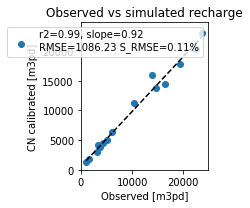


 RMSE is 1086.230230812917
LU code 400, factored by 0.7437499999999999, trying CN set of [40 53 60 63] 
LU code 500, factored by 0.8515178628739223, trying CN set of [37 55 65 69] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7727799638543067, trying CN set of [46 57 64 67] 
LU code 1000, factored by 0.8390974927979103, trying CN set of [67 73 77 78] 
LU code 1600, factored by 1.1573025800117185, trying CN set of [32 63 81 87] 
LU code 1700, factored by 0.921362578701761, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 70 85 91] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.8038081966078623, trying CN set of [25 44 56 61] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0097773208564353 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0096534912446447 % 

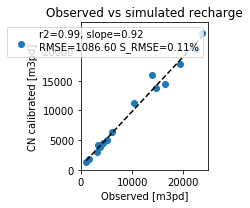


 RMSE is 1086.6047023154838
LU code 400, factored by 0.746875, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8542375214369612, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7771426369271534, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8412249963989552, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1513371150058593, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9223598643508805, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 70 85 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7945872283039311, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091424103484035 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090294442464214 % 


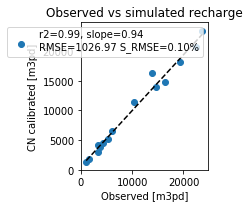


 RMSE is 1026.97413997257
LU code 400, factored by 0.746875, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8542375214369612, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7771426369271534, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8412249963989552, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1513371150058593, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9223598643508805, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 70 85 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7945872283039311, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091424103484035 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090294442464214 % 


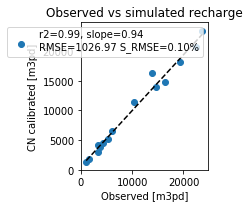


 RMSE is 1026.97413997257
LU code 400, factored by 0.756875, trying CN set of [41 54 62 64] 
LU code 500, factored by 0.8542375214369612, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7771426369271534, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8412249963989552, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1513371150058593, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9223598643508805, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 70 85 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7945872283039311, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091796765681127 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090657249961246 % 


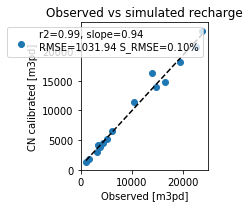


 RMSE is 1031.9408340724335
LU code 400, factored by 0.746875, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8642375214369612, trying CN set of [38 56 66 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7771426369271534, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8412249963989552, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1513371150058593, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9223598643508805, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 70 85 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7945872283039311, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.009153708591731 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090404199558427 % 


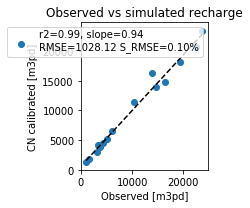


 RMSE is 1028.1186089484156
LU code 400, factored by 0.746875, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8542375214369612, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.84802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7771426369271534, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8412249963989552, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1513371150058593, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9223598643508805, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 70 85 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7945872283039311, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091424103484035 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090294442464214 % 


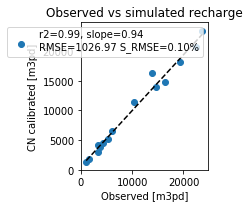


 RMSE is 1026.97413997257
LU code 400, factored by 0.746875, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8542375214369612, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7871426369271534, trying CN set of [47 59 66 68] 
LU code 1000, factored by 0.8412249963989552, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1513371150058593, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9223598643508805, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 70 85 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7945872283039311, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091588703489656 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090455844979265 % 


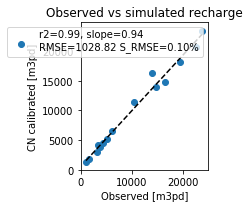


 RMSE is 1028.8177754167255
LU code 400, factored by 0.746875, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8542375214369612, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7771426369271534, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8512249963989552, trying CN set of [68 74 78 80] 
LU code 1600, factored by 1.1513371150058593, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9223598643508805, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 70 85 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7945872283039311, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091747826415989 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090613912881756 % 


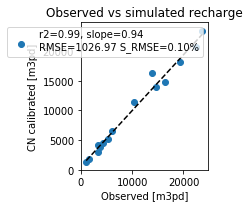


 RMSE is 1026.97413997257
LU code 400, factored by 0.746875, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8542375214369612, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7771426369271534, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8412249963989552, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1613371150058593, trying CN set of [32 63 81 88] 
LU code 1700, factored by 0.9223598643508805, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 70 85 91] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7945872283039311, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0099326112697775 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0098063491753924 % 


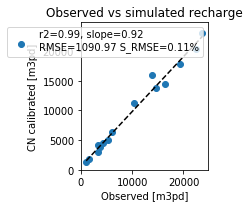


 RMSE is 1090.9708443111376
LU code 400, factored by 0.746875, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8542375214369612, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7771426369271534, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8412249963989552, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1513371150058593, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9323598643508805, trying CN set of [33 55 68 73] 
LU code 1400, factored by 0.88, trying CN set of [42 70 85 90] 
LU code 1500, factored by 0.89, trying CN set of [43 62 72 77] 
LU code 2100, factored by 0.7945872283039311, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.009150453079335 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.009037383100034 % 


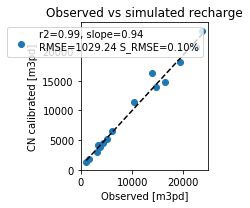


 RMSE is 1029.2363595329668
LU code 400, factored by 0.746875, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8542375214369612, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7771426369271534, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8412249963989552, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1513371150058593, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9223598643508805, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.89, trying CN set of [42 70 85 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7945872283039311, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091424103484035 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090294442464214 % 


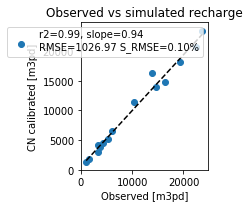


 RMSE is 1026.97413997257
LU code 400, factored by 0.746875, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8542375214369612, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7771426369271534, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8412249963989552, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1513371150058593, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9223598643508805, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 70 85 90] 
LU code 1500, factored by 0.9, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7945872283039311, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091424103484035 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090294442464214 % 


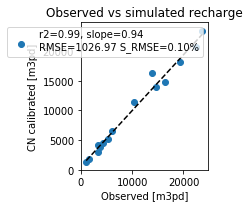


 RMSE is 1026.97413997257
LU code 400, factored by 0.746875, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8542375214369612, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7771426369271534, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8412249963989552, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1513371150058593, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9223598643508805, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 70 85 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.8045872283039311, trying CN set of [25 44 56 61] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091439317182163 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090309450060269 % 


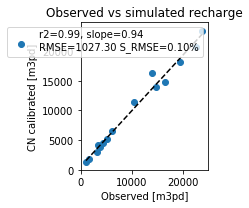


 RMSE is 1027.2997001246852
LU code 400, factored by 0.7484375, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8555973507184805, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7793239734635766, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8422887481994775, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1483543825029296, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9228585071754403, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 70 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7949767441519656, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091326333110624 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090199043680945 % 


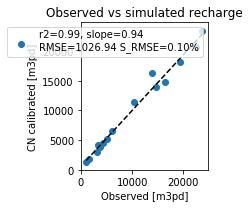


 RMSE is 1026.936482593237
LU code 400, factored by 0.7484375, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8555973507184805, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7793239734635766, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8422887481994775, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1483543825029296, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9228585071754403, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 70 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7949767441519656, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091326333110624 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090199043680945 % 


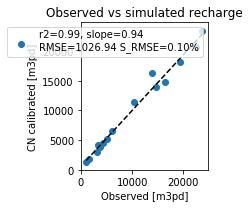


 RMSE is 1026.936482593237
LU code 400, factored by 0.7584375, trying CN set of [41 54 62 64] 
LU code 500, factored by 0.8555973507184805, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7793239734635766, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8422887481994775, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1483543825029296, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9228585071754403, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 70 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7949767441519656, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.009169899530172 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090561860563119 % 


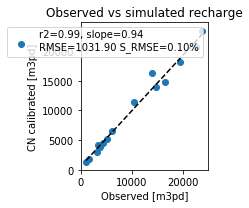


 RMSE is 1031.8950924188832
LU code 400, factored by 0.7484375, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8655973507184805, trying CN set of [38 56 66 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7793239734635766, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8422887481994775, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1483543825029296, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9228585071754403, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 70 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7949767441519656, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.00914393155439 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090308803887154 % 


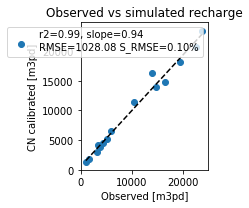


 RMSE is 1028.0806201476018
LU code 400, factored by 0.7484375, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8555973507184805, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.84802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7793239734635766, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8422887481994775, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1483543825029296, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9228585071754403, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 70 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7949767441519656, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091326333110624 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090199043680945 % 


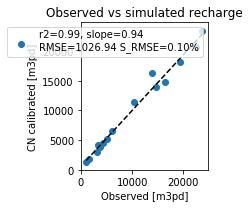


 RMSE is 1026.936482593237
LU code 400, factored by 0.7484375, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8555973507184805, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7893239734635766, trying CN set of [47 59 66 68] 
LU code 1000, factored by 0.8422887481994775, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1483543825029296, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9228585071754403, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 70 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7949767441519656, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.009149093311624 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090360449919609 % 


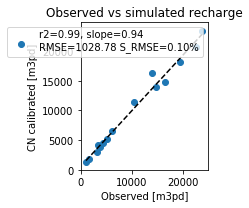


 RMSE is 1028.7801855216642
LU code 400, factored by 0.7484375, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8555973507184805, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7793239734635766, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8522887481994775, trying CN set of [69 75 78 80] 
LU code 1600, factored by 1.1483543825029296, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9228585071754403, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 70 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7949767441519656, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0092831146699686 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.009168494011773 % 


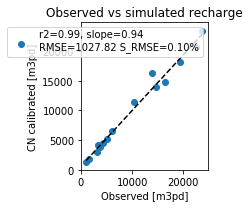


 RMSE is 1027.8187116884064
LU code 400, factored by 0.7484375, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8555973507184805, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7793239734635766, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8422887481994775, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1583543825029297, trying CN set of [32 63 81 88] 
LU code 1700, factored by 0.9228585071754403, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 70 85 91] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7949767441519656, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0099326112697775 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0098063491753924 % 


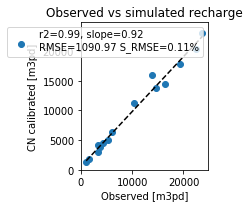


 RMSE is 1090.9708443111376
LU code 400, factored by 0.7484375, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8555973507184805, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7793239734635766, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8422887481994775, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1483543825029296, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9328585071754403, trying CN set of [33 55 69 73] 
LU code 1400, factored by 0.88, trying CN set of [42 70 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 62 72 77] 
LU code 2100, factored by 0.7949767441519656, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.009142979281616 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090300982709888 % 


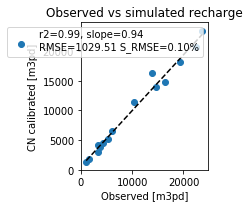


 RMSE is 1029.5073315453042
LU code 400, factored by 0.7484375, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8555973507184805, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7793239734635766, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8422887481994775, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1483543825029296, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9228585071754403, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.89, trying CN set of [42 70 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7949767441519656, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091326333110624 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090199043680945 % 


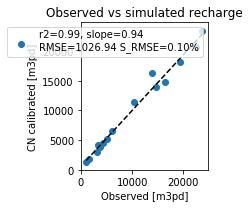


 RMSE is 1026.936482593237
LU code 400, factored by 0.7484375, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8555973507184805, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7793239734635766, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8422887481994775, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1483543825029296, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9228585071754403, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 70 84 90] 
LU code 1500, factored by 0.9, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7949767441519656, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091326333110624 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090199043680945 % 


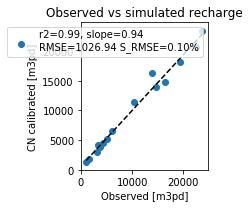


 RMSE is 1026.936482593237
LU code 400, factored by 0.7484375, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8555973507184805, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7793239734635766, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8422887481994775, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1483543825029296, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9228585071754403, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 70 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.8049767441519656, trying CN set of [25 44 56 61] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091341546808756 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090214051566426 % 


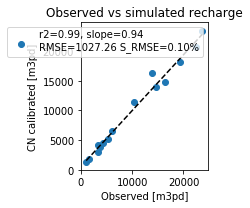


 RMSE is 1027.2620546797386
LU code 400, factored by 0.74921875, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8562772653592403, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7804146417317883, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8428206240997388, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1468630162514648, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9231078285877201, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 72 76] 
LU code 2100, factored by 0.7951715020759828, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091393288772226 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090265304181663 % 


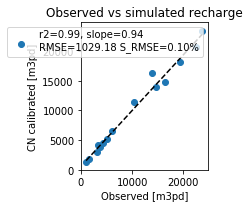


 RMSE is 1029.1828846113156
LU code 400, factored by 0.74921875, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8562772653592403, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7804146417317883, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8428206240997388, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1468630162514648, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9231078285877201, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 72 76] 
LU code 2100, factored by 0.7951715020759828, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091393288772226 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090265304181663 % 


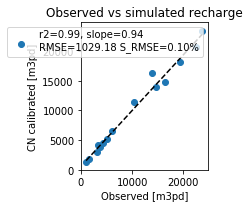


 RMSE is 1029.1828846113156
LU code 400, factored by 0.75921875, trying CN set of [41 54 62 64] 
LU code 500, factored by 0.8562772653592403, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7804146417317883, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8428206240997388, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1468630162514648, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9231078285877201, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 72 76] 
LU code 2100, factored by 0.7951715020759828, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091765950958753 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.00906281185229 % 


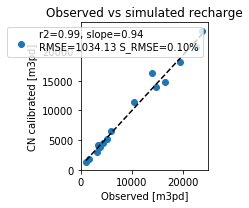


 RMSE is 1034.1348841749837
LU code 400, factored by 0.74921875, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8662772653592403, trying CN set of [38 56 66 71] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7804146417317883, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8428206240997388, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1468630162514648, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9231078285877201, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 72 76] 
LU code 2100, factored by 0.7951715020759828, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.009151966059111 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090388287439223 % 


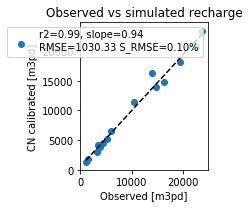


 RMSE is 1030.3306741647873
LU code 400, factored by 0.74921875, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8562772653592403, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.84802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7804146417317883, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8428206240997388, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1468630162514648, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9231078285877201, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 72 76] 
LU code 2100, factored by 0.7951715020759828, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091393288772226 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090265304181663 % 


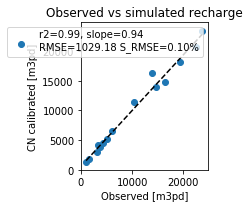


 RMSE is 1029.1828846113156
LU code 400, factored by 0.74921875, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8562772653592403, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7904146417317883, trying CN set of [47 59 66 68] 
LU code 1000, factored by 0.8428206240997388, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1468630162514648, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9231078285877201, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 72 76] 
LU code 2100, factored by 0.7951715020759828, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091557888772211 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090426709207527 % 


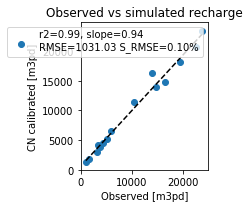


 RMSE is 1031.0307264765381
LU code 400, factored by 0.74921875, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8562772653592403, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7804146417317883, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8528206240997388, trying CN set of [69 75 78 80] 
LU code 1600, factored by 1.1468630162514648, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9231078285877201, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 72 76] 
LU code 2100, factored by 0.7951715020759828, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0092898102361287 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091751202306583 % 


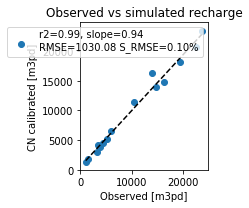


 RMSE is 1030.0757561920916
LU code 400, factored by 0.74921875, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8562772653592403, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7804146417317883, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8428206240997388, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1568630162514648, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9231078285877201, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 70 85 91] 
LU code 1500, factored by 0.89, trying CN set of [43 61 72 76] 
LU code 2100, factored by 0.7951715020759828, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091504530768303 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090373830975605 % 


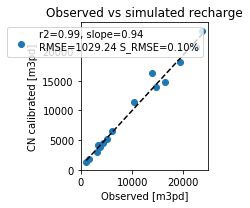


 RMSE is 1029.2363595329668
LU code 400, factored by 0.74921875, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8562772653592403, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7804146417317883, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8428206240997388, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1468630162514648, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9331078285877201, trying CN set of [33 55 69 73] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 62 72 77] 
LU code 2100, factored by 0.7951715020759828, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091416321197846 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090287853291455 % 


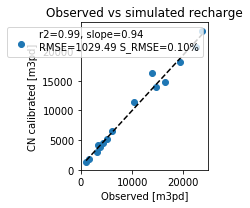


 RMSE is 1029.491078798967
LU code 400, factored by 0.74921875, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8562772653592403, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7804146417317883, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8428206240997388, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1468630162514648, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9231078285877201, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.89, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 72 76] 
LU code 2100, factored by 0.7951715020759828, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091393288772226 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090265304181663 % 


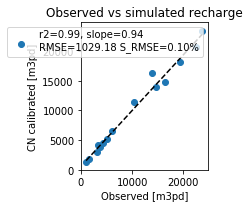


 RMSE is 1029.1828846113156
LU code 400, factored by 0.74921875, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8562772653592403, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7804146417317883, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8428206240997388, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1468630162514648, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9231078285877201, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.9, trying CN set of [43 61 72 76] 
LU code 2100, factored by 0.7951715020759828, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091393288772226 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090265304181663 % 


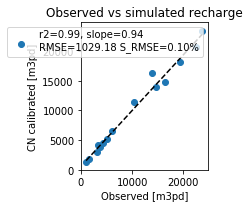


 RMSE is 1029.1828846113156
LU code 400, factored by 0.74921875, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8562772653592403, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7804146417317883, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8428206240997388, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1468630162514648, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9231078285877201, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 72 76] 
LU code 2100, factored by 0.8051715020759828, trying CN set of [25 44 56 61] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091408502472383 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.009028031147932 % 


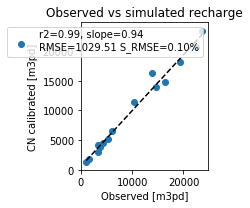


 RMSE is 1029.5118372521486
LU code 400, factored by 0.748828125, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8559373080388604, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7798693075976826, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8425546861496082, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1476086993771972, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9229831678815802, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 70 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7950741231139742, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091326333110624 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090199043680945 % 


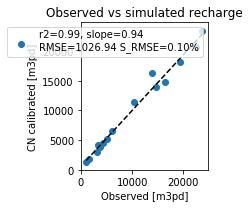


 RMSE is 1026.936482593237
LU code 400, factored by 0.748828125, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8559373080388604, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7798693075976826, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8425546861496082, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1476086993771972, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9229831678815802, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 70 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7950741231139742, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091326333110624 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090199043680945 % 


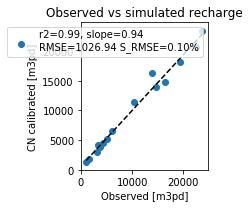


 RMSE is 1026.936482593237
LU code 400, factored by 0.758828125, trying CN set of [41 54 62 64] 
LU code 500, factored by 0.8559373080388604, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7798693075976826, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8425546861496082, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1476086993771972, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9229831678815802, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 70 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7950741231139742, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.009169899530172 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090561860563119 % 


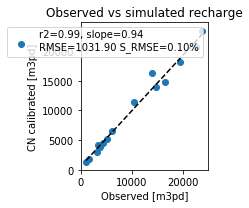


 RMSE is 1031.8950924188832
LU code 400, factored by 0.748828125, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8659373080388604, trying CN set of [38 56 66 71] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7798693075976826, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8425546861496082, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1476086993771972, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9229831678815802, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 70 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7950741231139742, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.009145270493598 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090322027739318 % 


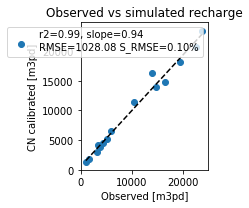


 RMSE is 1028.0806201476018
LU code 400, factored by 0.748828125, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8559373080388604, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.84802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7798693075976826, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8425546861496082, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1476086993771972, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9229831678815802, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 70 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7950741231139742, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091326333110624 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090199043680945 % 


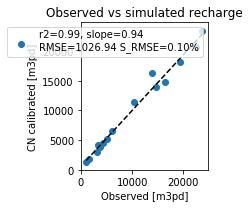


 RMSE is 1026.936482593237
LU code 400, factored by 0.748828125, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8559373080388604, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7898693075976826, trying CN set of [47 59 66 68] 
LU code 1000, factored by 0.8425546861496082, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1476086993771972, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9229831678815802, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 70 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7950741231139742, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.009149093311624 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090360449919609 % 


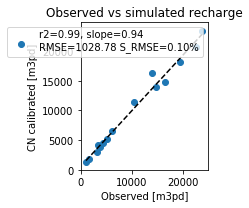


 RMSE is 1028.7801855216642
LU code 400, factored by 0.748828125, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8559373080388604, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7798693075976826, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8525546861496082, trying CN set of [69 75 78 80] 
LU code 1600, factored by 1.1476086993771972, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9229831678815802, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 70 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7950741231139742, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0092831146699686 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.009168494011773 % 


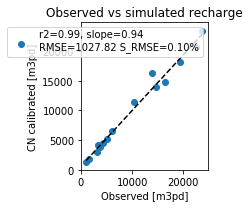


 RMSE is 1027.8187116884064
LU code 400, factored by 0.748828125, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8559373080388604, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7798693075976826, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8425546861496082, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1576086993771972, trying CN set of [32 63 81 87] 
LU code 1700, factored by 0.9229831678815802, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 70 85 91] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7950741231139742, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0099217837216576 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.009795659265642 % 


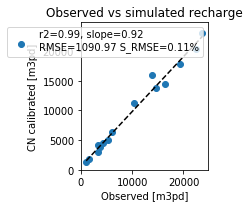


 RMSE is 1090.9708443111376
LU code 400, factored by 0.748828125, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8559373080388604, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7798693075976826, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8425546861496082, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1476086993771972, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9329831678815802, trying CN set of [33 55 69 73] 
LU code 1400, factored by 0.88, trying CN set of [42 70 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 62 72 77] 
LU code 2100, factored by 0.7950741231139742, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.009142979281616 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090300982709888 % 


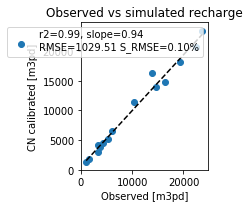


 RMSE is 1029.5073315453042
LU code 400, factored by 0.748828125, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8559373080388604, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7798693075976826, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8425546861496082, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1476086993771972, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9229831678815802, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.89, trying CN set of [42 70 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7950741231139742, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091326333110624 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090199043680945 % 


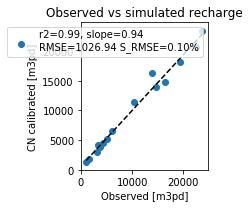


 RMSE is 1026.936482593237
LU code 400, factored by 0.748828125, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8559373080388604, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7798693075976826, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8425546861496082, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1476086993771972, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9229831678815802, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 70 84 90] 
LU code 1500, factored by 0.9, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7950741231139742, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091326333110624 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090199043680945 % 


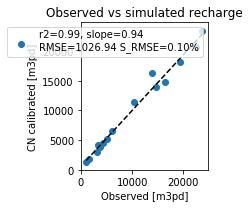


 RMSE is 1026.936482593237
LU code 400, factored by 0.748828125, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8559373080388604, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7798693075976826, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8425546861496082, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1476086993771972, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9229831678815802, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 70 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.8050741231139742, trying CN set of [25 44 56 61] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091341546808756 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090214051566426 % 


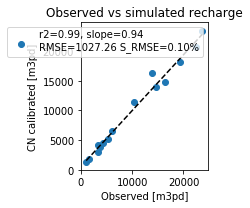


 RMSE is 1027.2620546797386
LU code 400, factored by 0.7490234375, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561072866990503, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7801419746647354, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8426876551246735, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.147235857814331, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230454982346501, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951228125949785, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 % 


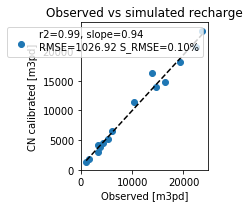


 RMSE is 1026.9205472501724
LU code 400, factored by 0.7490234375, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561072866990503, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7801419746647354, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8426876551246735, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.147235857814331, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230454982346501, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951228125949785, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 % 


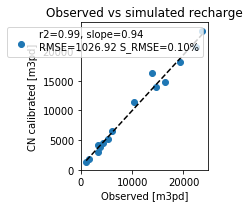


 RMSE is 1026.9205472501724
LU code 400, factored by 0.7590234375, trying CN set of [41 54 62 64] 
LU code 500, factored by 0.8561072866990503, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7801419746647354, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8426876551246735, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.147235857814331, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230454982346501, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951228125949785, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091685523678833 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090548733439086 % 


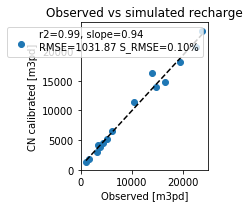


 RMSE is 1031.8748224637684
LU code 400, factored by 0.7490234375, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8661072866990503, trying CN set of [38 56 66 71] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7801419746647354, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8426876551246735, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.147235857814331, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230454982346501, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951228125949785, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091439233311195 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090308899376157 % 


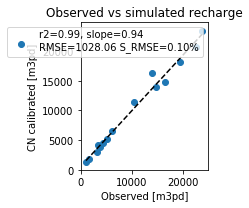


 RMSE is 1028.064491795231
LU code 400, factored by 0.7490234375, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561072866990503, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.84802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7801419746647354, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8426876551246735, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.147235857814331, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230454982346501, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951228125949785, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 % 


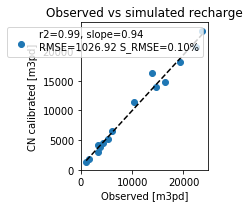


 RMSE is 1026.9205472501724
LU code 400, factored by 0.7490234375, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561072866990503, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7901419746647355, trying CN set of [47 59 66 68] 
LU code 1000, factored by 0.8426876551246735, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.147235857814331, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230454982346501, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951228125949785, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.00914774614923 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090347320788617 % 


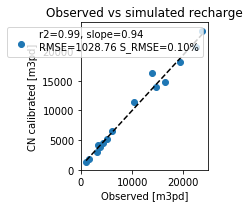


 RMSE is 1028.764278737172
LU code 400, factored by 0.7490234375, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561072866990503, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7801419746647354, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8526876551246735, trying CN set of [69 75 78 80] 
LU code 1600, factored by 1.147235857814331, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230454982346501, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951228125949785, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0092817675081371 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091671813510223 % 


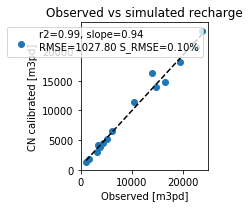


 RMSE is 1027.8024289533769
LU code 400, factored by 0.7490234375, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561072866990503, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7801419746647354, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8426876551246735, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.157235857814331, trying CN set of [32 63 81 87] 
LU code 1700, factored by 0.9230454982346501, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 70 85 91] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951228125949785, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0099217837216576 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.009795659265642 % 


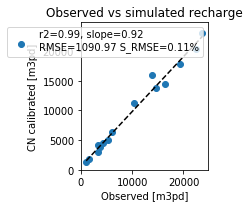


 RMSE is 1090.9708443111376
LU code 400, factored by 0.7490234375, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561072866990503, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7801419746647354, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8426876551246735, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.147235857814331, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9330454982346501, trying CN set of [33 55 69 73] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 62 72 77] 
LU code 2100, factored by 0.7951228125949785, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091416321197846 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090287853291455 % 


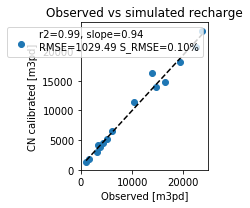


 RMSE is 1029.491078798967
LU code 400, factored by 0.7490234375, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561072866990503, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7801419746647354, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8426876551246735, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.147235857814331, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230454982346501, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.89, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951228125949785, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 % 


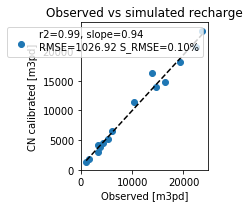


 RMSE is 1026.9205472501724
LU code 400, factored by 0.7490234375, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561072866990503, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7801419746647354, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8426876551246735, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.147235857814331, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230454982346501, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.9, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951228125949785, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 % 


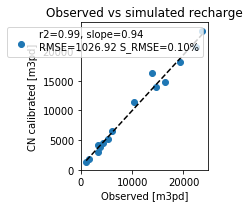


 RMSE is 1026.9205472501724
LU code 400, factored by 0.7490234375, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561072866990503, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7801419746647354, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8426876551246735, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.147235857814331, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230454982346501, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.8051228125949785, trying CN set of [25 44 56 61] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091328075190442 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090200922093802 % 


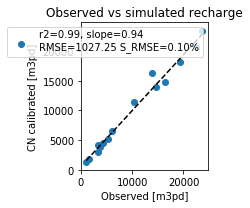


 RMSE is 1027.2461243871705
LU code 400, factored by 0.7491210937499999, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561922760291454, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802783081982618, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427541396122061, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1470494370328979, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230766634111851, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951471573354807, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 

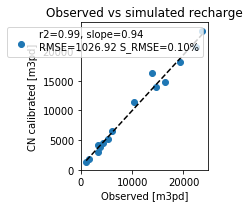


 RMSE is 1026.9205472501724
LU code 400, factored by 0.7491210937499999, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561922760291454, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802783081982618, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427541396122061, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1470494370328979, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230766634111851, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951471573354807, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 

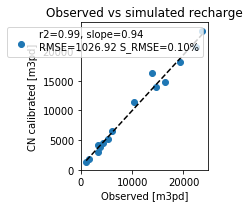


 RMSE is 1026.9205472501724
LU code 400, factored by 0.7591210937499999, trying CN set of [41 54 62 64] 
LU code 500, factored by 0.8561922760291454, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802783081982618, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427541396122061, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1470494370328979, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230766634111851, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951471573354807, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091685523678833 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090548733439086 

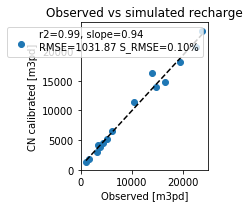


 RMSE is 1031.8748224637684
LU code 400, factored by 0.7491210937499999, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8661922760291454, trying CN set of [38 56 66 71] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802783081982618, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427541396122061, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1470494370328979, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230766634111851, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951471573354807, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091439233311195 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090308899376157 

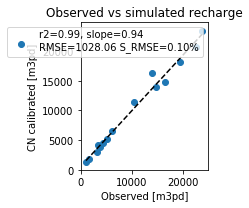


 RMSE is 1028.064491795231
LU code 400, factored by 0.7491210937499999, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561922760291454, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.84802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802783081982618, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427541396122061, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1470494370328979, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230766634111851, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951471573354807, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 %

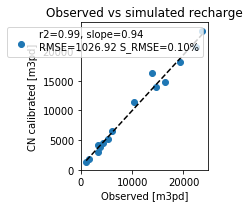


 RMSE is 1026.9205472501724
LU code 400, factored by 0.7491210937499999, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561922760291454, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7902783081982618, trying CN set of [47 59 66 68] 
LU code 1000, factored by 0.8427541396122061, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1470494370328979, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230766634111851, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951471573354807, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.00914774614923 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090347320788617 % 

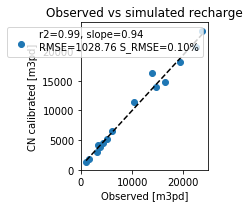


 RMSE is 1028.764278737172
LU code 400, factored by 0.7491210937499999, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561922760291454, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802783081982618, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8527541396122061, trying CN set of [69 75 78 80] 
LU code 1600, factored by 1.1470494370328979, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230766634111851, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951471573354807, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0092817675081371 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091671813510223 %

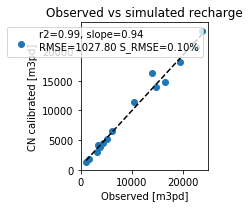


 RMSE is 1027.8024289533769
LU code 400, factored by 0.7491210937499999, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561922760291454, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802783081982618, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427541396122061, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1570494370328979, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230766634111851, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 70 85 91] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951471573354807, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091424103488387 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090294442468513 

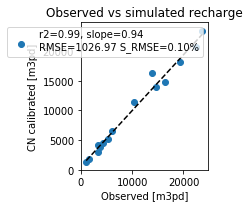


 RMSE is 1026.97413997257
LU code 400, factored by 0.7491210937499999, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561922760291454, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802783081982618, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427541396122061, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1470494370328979, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9330766634111851, trying CN set of [33 55 69 73] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 62 72 77] 
LU code 2100, factored by 0.7951471573354807, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091416321197846 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090287853291455 % 

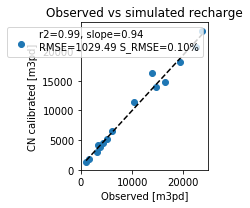


 RMSE is 1029.491078798967
LU code 400, factored by 0.7491210937499999, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561922760291454, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802783081982618, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427541396122061, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1470494370328979, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230766634111851, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.89, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951471573354807, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 %

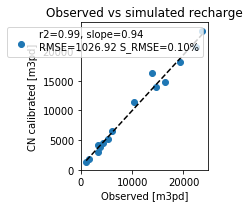


 RMSE is 1026.9205472501724
LU code 400, factored by 0.7491210937499999, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561922760291454, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802783081982618, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427541396122061, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1470494370328979, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230766634111851, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.9, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951471573354807, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 %

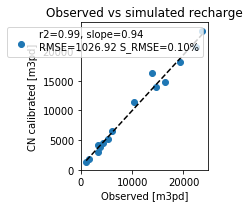


 RMSE is 1026.9205472501724
LU code 400, factored by 0.7491210937499999, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561922760291454, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802783081982618, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427541396122061, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1470494370328979, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230766634111851, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.8051471573354807, trying CN set of [25 44 56 61] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091328075190442 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090200922093802 

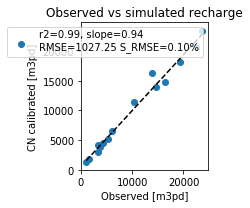


 RMSE is 1027.2461243871705
LU code 400, factored by 0.749072265625, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561497813640978, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802101414314987, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208973684398, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471426474236144, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610808229176, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349849652296, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 % 


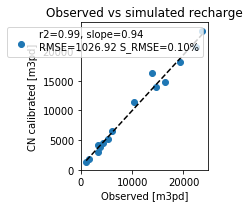


 RMSE is 1026.9205472501724
LU code 400, factored by 0.749072265625, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561497813640978, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802101414314987, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208973684398, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471426474236144, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610808229176, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349849652296, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 % 


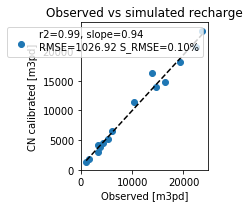


 RMSE is 1026.9205472501724
LU code 400, factored by 0.759072265625, trying CN set of [41 54 62 64] 
LU code 500, factored by 0.8561497813640978, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802101414314987, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208973684398, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471426474236144, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610808229176, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349849652296, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091685523678833 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090548733439086 % 


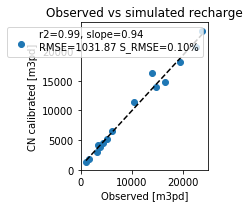


 RMSE is 1031.8748224637684
LU code 400, factored by 0.749072265625, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8661497813640978, trying CN set of [38 56 66 71] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802101414314987, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208973684398, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471426474236144, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610808229176, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349849652296, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091439233311195 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090308899376157 % 


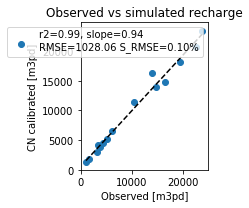


 RMSE is 1028.064491795231
LU code 400, factored by 0.749072265625, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561497813640978, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.84802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802101414314987, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208973684398, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471426474236144, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610808229176, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349849652296, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 % 


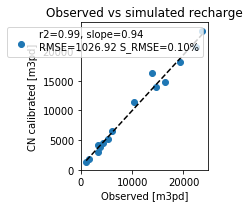


 RMSE is 1026.9205472501724
LU code 400, factored by 0.749072265625, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561497813640978, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7902101414314987, trying CN set of [47 59 66 68] 
LU code 1000, factored by 0.8427208973684398, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471426474236144, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610808229176, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349849652296, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.00914774614923 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090347320788617 % 


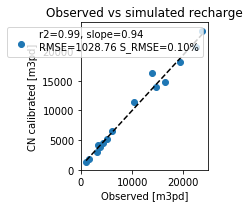


 RMSE is 1028.764278737172
LU code 400, factored by 0.749072265625, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561497813640978, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802101414314987, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8527208973684398, trying CN set of [69 75 78 80] 
LU code 1600, factored by 1.1471426474236144, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610808229176, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349849652296, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0092817675081371 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091671813510223 % 


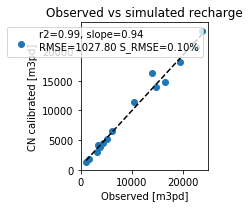


 RMSE is 1027.8024289533769
LU code 400, factored by 0.749072265625, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561497813640978, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802101414314987, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208973684398, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1571426474236144, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610808229176, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 70 85 91] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349849652296, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091424103488387 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090294442468513 % 


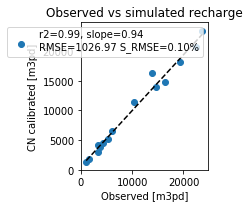


 RMSE is 1026.97413997257
LU code 400, factored by 0.749072265625, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561497813640978, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802101414314987, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208973684398, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471426474236144, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9330610808229176, trying CN set of [33 55 69 73] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 62 72 77] 
LU code 2100, factored by 0.7951349849652296, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091416321197846 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090287853291455 % 


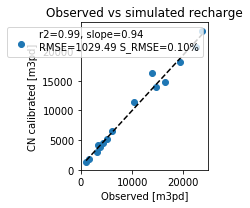


 RMSE is 1029.491078798967
LU code 400, factored by 0.749072265625, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561497813640978, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802101414314987, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208973684398, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471426474236144, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610808229176, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.89, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349849652296, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 % 


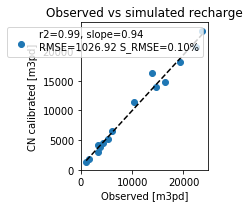


 RMSE is 1026.9205472501724
LU code 400, factored by 0.749072265625, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561497813640978, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802101414314987, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208973684398, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471426474236144, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610808229176, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.9, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349849652296, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 % 


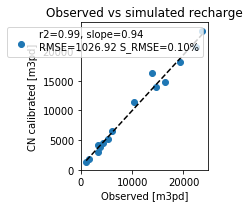


 RMSE is 1026.9205472501724
LU code 400, factored by 0.749072265625, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561497813640978, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802101414314987, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208973684398, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471426474236144, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610808229176, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.8051349849652296, trying CN set of [25 44 56 61] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091328075190442 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090200922093802 % 


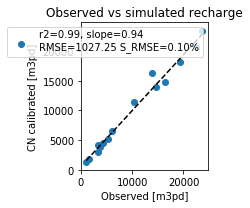


 RMSE is 1027.2461243871705
LU code 400, factored by 0.7490478515625, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561285340315741, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7801760580481171, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427042762465566, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471892526189726, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230532895287838, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.795128898780104, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 % 


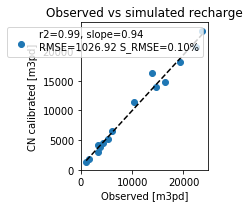


 RMSE is 1026.9205472501724
LU code 400, factored by 0.7490478515625, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561285340315741, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7801760580481171, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427042762465566, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471892526189726, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230532895287838, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.795128898780104, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 % 


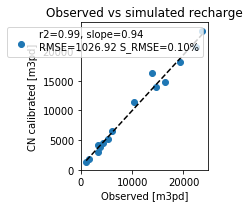


 RMSE is 1026.9205472501724
LU code 400, factored by 0.7590478515625, trying CN set of [41 54 62 64] 
LU code 500, factored by 0.8561285340315741, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7801760580481171, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427042762465566, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471892526189726, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230532895287838, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.795128898780104, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091685523678833 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090548733439086 % 


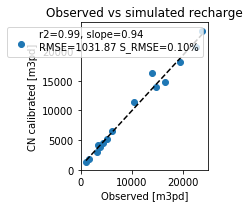


 RMSE is 1031.8748224637684
LU code 400, factored by 0.7490478515625, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8661285340315741, trying CN set of [38 56 66 71] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7801760580481171, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427042762465566, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471892526189726, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230532895287838, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.795128898780104, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091439233311195 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090308899376157 % 


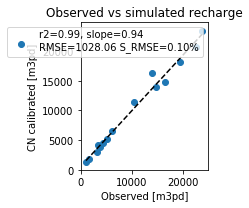


 RMSE is 1028.064491795231
LU code 400, factored by 0.7490478515625, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561285340315741, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.84802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7801760580481171, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427042762465566, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471892526189726, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230532895287838, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.795128898780104, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 % 


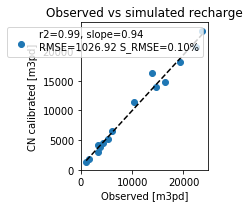


 RMSE is 1026.9205472501724
LU code 400, factored by 0.7490478515625, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561285340315741, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7901760580481171, trying CN set of [47 59 66 68] 
LU code 1000, factored by 0.8427042762465566, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471892526189726, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230532895287838, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.795128898780104, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.00914774614923 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090347320788617 % 


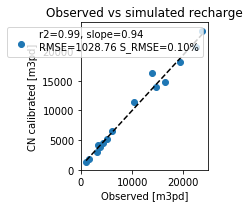


 RMSE is 1028.764278737172
LU code 400, factored by 0.7490478515625, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561285340315741, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7801760580481171, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8527042762465566, trying CN set of [69 75 78 80] 
LU code 1600, factored by 1.1471892526189726, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230532895287838, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.795128898780104, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0092817675081371 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091671813510223 % 


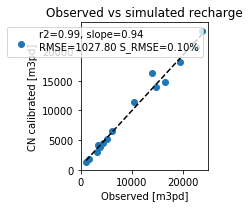


 RMSE is 1027.8024289533769
LU code 400, factored by 0.7490478515625, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561285340315741, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7801760580481171, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427042762465566, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1571892526189727, trying CN set of [32 63 81 87] 
LU code 1700, factored by 0.9230532895287838, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 70 85 91] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.795128898780104, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0099217837216576 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.009795659265642 % 


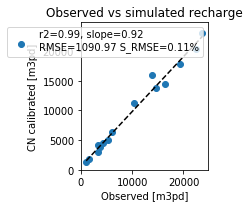


 RMSE is 1090.9708443111376
LU code 400, factored by 0.7490478515625, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561285340315741, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7801760580481171, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427042762465566, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471892526189726, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9330532895287839, trying CN set of [33 55 69 73] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 62 72 77] 
LU code 2100, factored by 0.795128898780104, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091416321197846 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090287853291455 % 


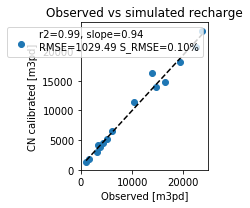


 RMSE is 1029.491078798967
LU code 400, factored by 0.7490478515625, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561285340315741, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7801760580481171, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427042762465566, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471892526189726, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230532895287838, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.89, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.795128898780104, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 % 


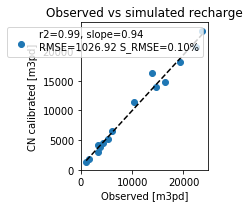


 RMSE is 1026.9205472501724
LU code 400, factored by 0.7490478515625, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561285340315741, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7801760580481171, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427042762465566, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471892526189726, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230532895287838, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.9, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.795128898780104, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 % 


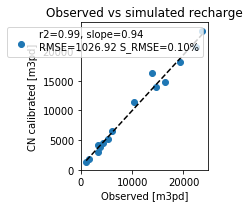


 RMSE is 1026.9205472501724
LU code 400, factored by 0.7490478515625, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561285340315741, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7801760580481171, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427042762465566, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471892526189726, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230532895287838, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.805128898780104, trying CN set of [25 44 56 61] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091328075190442 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090200922093802 % 


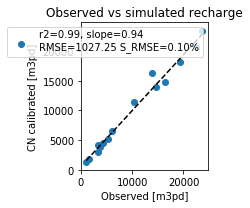


 RMSE is 1027.2461243871705
LU code 400, factored by 0.7490600585937499, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561391576978359, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7801930997398079, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427125868074983, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471659500212936, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230571851758508, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951319418726668, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 

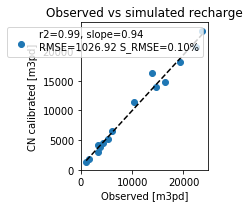


 RMSE is 1026.9205472501724
LU code 400, factored by 0.7490600585937499, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561391576978359, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7801930997398079, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427125868074983, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471659500212936, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230571851758508, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951319418726668, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 

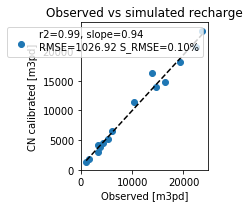


 RMSE is 1026.9205472501724
LU code 400, factored by 0.7590600585937499, trying CN set of [41 54 62 64] 
LU code 500, factored by 0.8561391576978359, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7801930997398079, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427125868074983, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471659500212936, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230571851758508, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951319418726668, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091685523678833 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090548733439086 

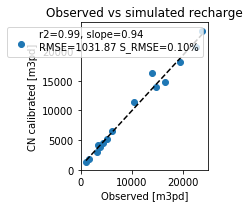


 RMSE is 1031.8748224637684
LU code 400, factored by 0.7490600585937499, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8661391576978359, trying CN set of [38 56 66 71] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7801930997398079, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427125868074983, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471659500212936, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230571851758508, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951319418726668, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091439233311195 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090308899376157 

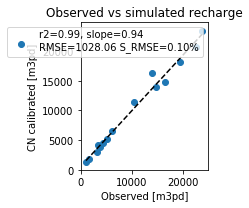


 RMSE is 1028.064491795231
LU code 400, factored by 0.7490600585937499, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561391576978359, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.84802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7801930997398079, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427125868074983, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471659500212936, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230571851758508, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951319418726668, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 %

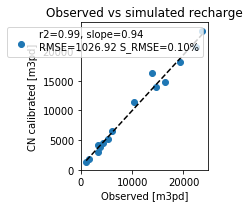


 RMSE is 1026.9205472501724
LU code 400, factored by 0.7490600585937499, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561391576978359, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7901930997398079, trying CN set of [47 59 66 68] 
LU code 1000, factored by 0.8427125868074983, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471659500212936, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230571851758508, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951319418726668, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.00914774614923 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090347320788617 % 

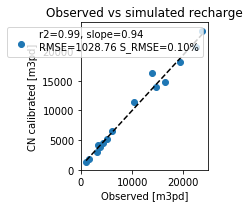


 RMSE is 1028.764278737172
LU code 400, factored by 0.7490600585937499, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561391576978359, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7801930997398079, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8527125868074983, trying CN set of [69 75 78 80] 
LU code 1600, factored by 1.1471659500212936, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230571851758508, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951319418726668, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0092817675081371 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091671813510223 %

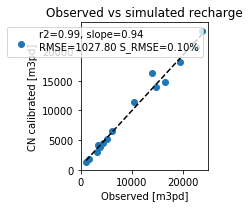


 RMSE is 1027.8024289533769
LU code 400, factored by 0.7490600585937499, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561391576978359, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7801930997398079, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427125868074983, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1571659500212936, trying CN set of [32 63 81 87] 
LU code 1700, factored by 0.9230571851758508, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 70 85 91] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951319418726668, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0099217837216576 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.009795659265642 %

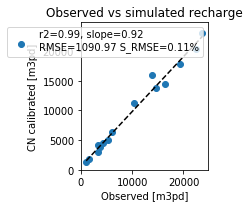


 RMSE is 1090.9708443111376
LU code 400, factored by 0.7490600585937499, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561391576978359, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7801930997398079, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427125868074983, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471659500212936, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9330571851758508, trying CN set of [33 55 69 73] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 62 72 77] 
LU code 2100, factored by 0.7951319418726668, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091416321197846 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090287853291455 

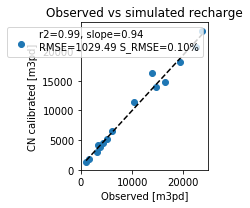


 RMSE is 1029.491078798967
LU code 400, factored by 0.7490600585937499, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561391576978359, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7801930997398079, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427125868074983, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471659500212936, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230571851758508, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.89, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951319418726668, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 %

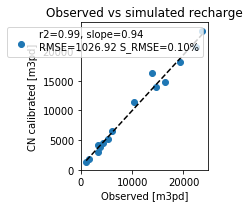


 RMSE is 1026.9205472501724
LU code 400, factored by 0.7490600585937499, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561391576978359, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7801930997398079, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427125868074983, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471659500212936, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230571851758508, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.9, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951319418726668, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 %

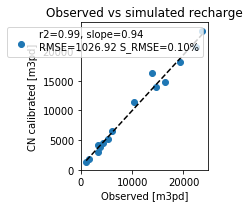


 RMSE is 1026.9205472501724
LU code 400, factored by 0.7490600585937499, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561391576978359, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7801930997398079, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427125868074983, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471659500212936, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230571851758508, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.8051319418726668, trying CN set of [25 44 56 61] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091328075190442 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090200922093802 

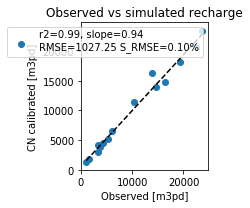


 RMSE is 1027.2461243871705
LU code 400, factored by 0.749066162109375, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561444695309669, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802016205856532, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.842716742087969, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.147154298722454, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230591329993841, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951334634189482, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 % 


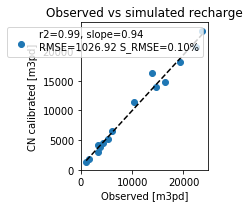


 RMSE is 1026.9205472501724
LU code 400, factored by 0.749066162109375, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561444695309669, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802016205856532, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.842716742087969, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.147154298722454, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230591329993841, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951334634189482, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 % 


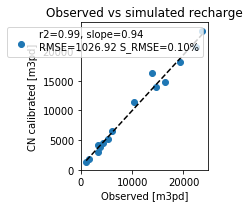


 RMSE is 1026.9205472501724
LU code 400, factored by 0.759066162109375, trying CN set of [41 54 62 64] 
LU code 500, factored by 0.8561444695309669, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802016205856532, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.842716742087969, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.147154298722454, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230591329993841, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951334634189482, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091685523678833 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090548733439086 % 


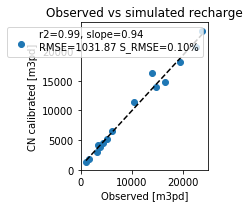


 RMSE is 1031.8748224637684
LU code 400, factored by 0.749066162109375, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8661444695309669, trying CN set of [38 56 66 71] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802016205856532, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.842716742087969, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.147154298722454, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230591329993841, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951334634189482, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091439233311195 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090308899376157 % 


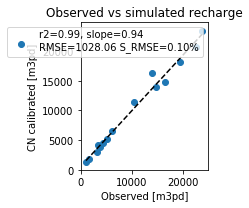


 RMSE is 1028.064491795231
LU code 400, factored by 0.749066162109375, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561444695309669, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.84802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802016205856532, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.842716742087969, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.147154298722454, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230591329993841, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951334634189482, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 % 


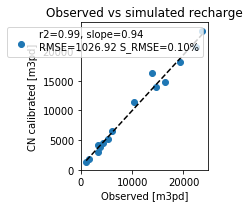


 RMSE is 1026.9205472501724
LU code 400, factored by 0.749066162109375, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561444695309669, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7902016205856532, trying CN set of [47 59 66 68] 
LU code 1000, factored by 0.842716742087969, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.147154298722454, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230591329993841, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951334634189482, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.00914774614923 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090347320788617 % 


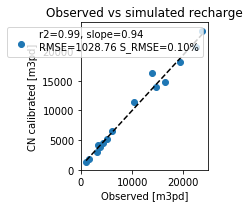


 RMSE is 1028.764278737172
LU code 400, factored by 0.749066162109375, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561444695309669, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802016205856532, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.852716742087969, trying CN set of [69 75 78 80] 
LU code 1600, factored by 1.147154298722454, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230591329993841, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951334634189482, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0092817675081371 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091671813510223 % 


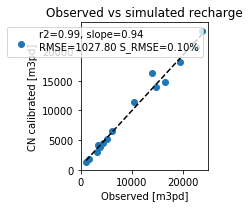


 RMSE is 1027.8024289533769
LU code 400, factored by 0.749066162109375, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561444695309669, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802016205856532, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.842716742087969, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.157154298722454, trying CN set of [32 63 81 87] 
LU code 1700, factored by 0.9230591329993841, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 70 85 91] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951334634189482, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0099217837216576 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.009795659265642 % 


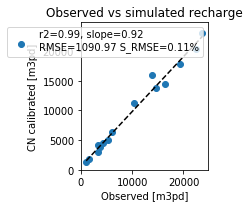


 RMSE is 1090.9708443111376
LU code 400, factored by 0.749066162109375, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561444695309669, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802016205856532, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.842716742087969, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.147154298722454, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9330591329993841, trying CN set of [33 55 69 73] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 62 72 77] 
LU code 2100, factored by 0.7951334634189482, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091416321197846 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090287853291455 % 


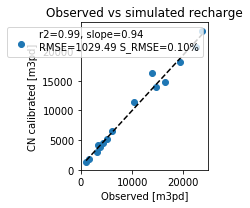


 RMSE is 1029.491078798967
LU code 400, factored by 0.749066162109375, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561444695309669, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802016205856532, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.842716742087969, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.147154298722454, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230591329993841, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.89, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951334634189482, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 % 


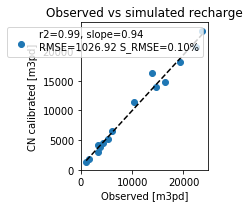


 RMSE is 1026.9205472501724
LU code 400, factored by 0.749066162109375, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561444695309669, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802016205856532, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.842716742087969, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.147154298722454, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230591329993841, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.9, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951334634189482, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 % 


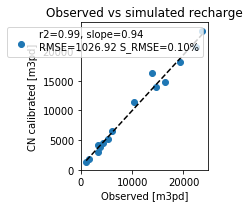


 RMSE is 1026.9205472501724
LU code 400, factored by 0.749066162109375, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561444695309669, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802016205856532, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.842716742087969, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.147154298722454, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230591329993841, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.8051334634189482, trying CN set of [25 44 56 61] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091328075190442 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090200922093802 % 


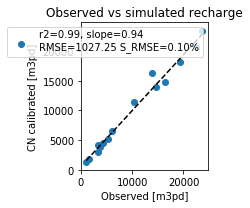


 RMSE is 1027.2461243871705
LU code 400, factored by 0.7490692138671875, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561471254475324, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802058810085759, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427188197282044, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471484730730341, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230601069111509, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951342241920889, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 

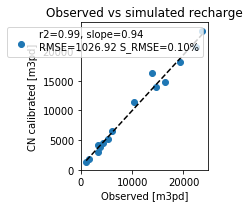


 RMSE is 1026.9205472501724
LU code 400, factored by 0.7490692138671875, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561471254475324, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802058810085759, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427188197282044, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471484730730341, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230601069111509, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951342241920889, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 

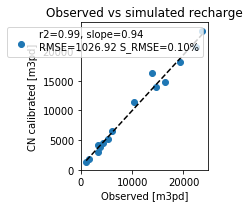


 RMSE is 1026.9205472501724
LU code 400, factored by 0.7590692138671875, trying CN set of [41 54 62 64] 
LU code 500, factored by 0.8561471254475324, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802058810085759, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427188197282044, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471484730730341, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230601069111509, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951342241920889, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091685523678833 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090548733439086 

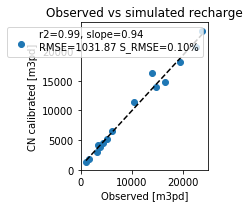


 RMSE is 1031.8748224637684
LU code 400, factored by 0.7490692138671875, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8661471254475324, trying CN set of [38 56 66 71] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802058810085759, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427188197282044, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471484730730341, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230601069111509, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951342241920889, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091439233311195 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090308899376157 

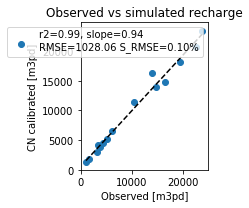


 RMSE is 1028.064491795231
LU code 400, factored by 0.7490692138671875, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561471254475324, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.84802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802058810085759, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427188197282044, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471484730730341, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230601069111509, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951342241920889, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 %

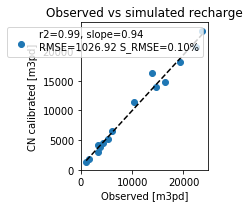


 RMSE is 1026.9205472501724
LU code 400, factored by 0.7490692138671875, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561471254475324, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7902058810085759, trying CN set of [47 59 66 68] 
LU code 1000, factored by 0.8427188197282044, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471484730730341, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230601069111509, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951342241920889, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.00914774614923 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090347320788617 % 

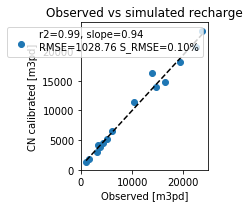


 RMSE is 1028.764278737172
LU code 400, factored by 0.7490692138671875, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561471254475324, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802058810085759, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8527188197282044, trying CN set of [69 75 78 80] 
LU code 1600, factored by 1.1471484730730341, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230601069111509, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951342241920889, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0092817675081371 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091671813510223 %

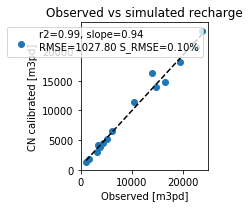


 RMSE is 1027.8024289533769
LU code 400, factored by 0.7490692138671875, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561471254475324, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802058810085759, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427188197282044, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1571484730730341, trying CN set of [32 63 81 87] 
LU code 1700, factored by 0.9230601069111509, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 70 85 91] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951342241920889, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0099217837216576 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.009795659265642 %

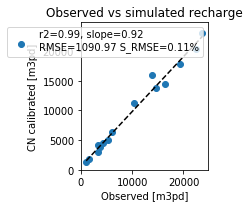


 RMSE is 1090.9708443111376
LU code 400, factored by 0.7490692138671875, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561471254475324, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802058810085759, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427188197282044, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471484730730341, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9330601069111509, trying CN set of [33 55 69 73] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 62 72 77] 
LU code 2100, factored by 0.7951342241920889, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091416321197846 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090287853291455 

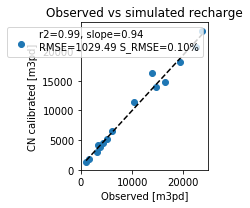


 RMSE is 1029.491078798967
LU code 400, factored by 0.7490692138671875, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561471254475324, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802058810085759, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427188197282044, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471484730730341, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230601069111509, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.89, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951342241920889, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 %

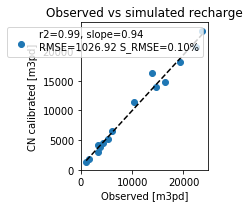


 RMSE is 1026.9205472501724
LU code 400, factored by 0.7490692138671875, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561471254475324, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802058810085759, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427188197282044, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471484730730341, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230601069111509, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.9, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951342241920889, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 %

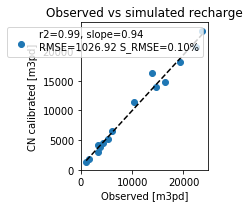


 RMSE is 1026.9205472501724
LU code 400, factored by 0.7490692138671875, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561471254475324, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802058810085759, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427188197282044, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471484730730341, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230601069111509, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.8051342241920889, trying CN set of [25 44 56 61] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091328075190442 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090200922093802 

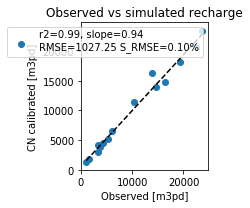


 RMSE is 1027.2461243871705
LU code 400, factored by 0.7490707397460937, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561484534058151, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802080112200374, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427198585483221, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471455602483243, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230605938670342, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951346045786593, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 

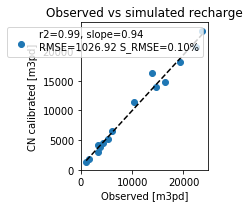


 RMSE is 1026.9205472501724
LU code 400, factored by 0.7490707397460937, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561484534058151, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802080112200374, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427198585483221, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471455602483243, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230605938670342, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951346045786593, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 

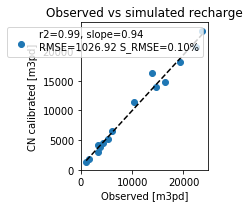


 RMSE is 1026.9205472501724
LU code 400, factored by 0.7590707397460937, trying CN set of [41 54 62 64] 
LU code 500, factored by 0.8561484534058151, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802080112200374, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427198585483221, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471455602483243, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230605938670342, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951346045786593, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091685523678833 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090548733439086 

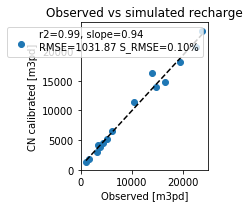


 RMSE is 1031.8748224637684
LU code 400, factored by 0.7490707397460937, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8661484534058151, trying CN set of [38 56 66 71] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802080112200374, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427198585483221, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471455602483243, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230605938670342, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951346045786593, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091439233311195 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090308899376157 

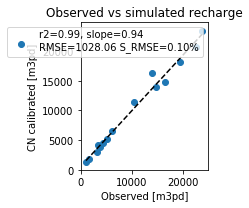


 RMSE is 1028.064491795231
LU code 400, factored by 0.7490707397460937, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561484534058151, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.84802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802080112200374, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427198585483221, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471455602483243, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230605938670342, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951346045786593, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 %

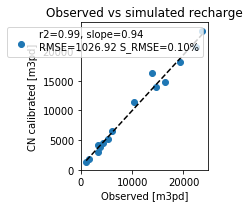


 RMSE is 1026.9205472501724
LU code 400, factored by 0.7490707397460937, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561484534058151, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7902080112200374, trying CN set of [47 59 66 68] 
LU code 1000, factored by 0.8427198585483221, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471455602483243, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230605938670342, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951346045786593, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.00914774614923 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090347320788617 % 

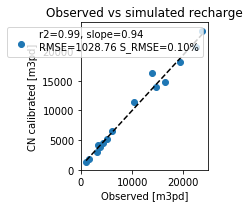


 RMSE is 1028.764278737172
LU code 400, factored by 0.7490707397460937, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561484534058151, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802080112200374, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8527198585483221, trying CN set of [69 75 78 80] 
LU code 1600, factored by 1.1471455602483243, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230605938670342, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951346045786593, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0092817675081371 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091671813510223 %

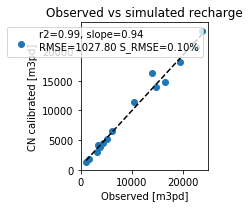


 RMSE is 1027.8024289533769
LU code 400, factored by 0.7490707397460937, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561484534058151, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802080112200374, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427198585483221, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1571455602483243, trying CN set of [32 63 81 87] 
LU code 1700, factored by 0.9230605938670342, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 70 85 91] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951346045786593, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0099217837216576 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.009795659265642 %

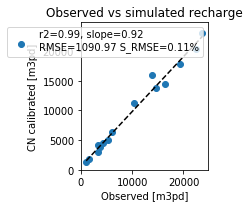


 RMSE is 1090.9708443111376
LU code 400, factored by 0.7490707397460937, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561484534058151, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802080112200374, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427198585483221, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471455602483243, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9330605938670342, trying CN set of [33 55 69 73] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 62 72 77] 
LU code 2100, factored by 0.7951346045786593, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091416321197846 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090287853291455 

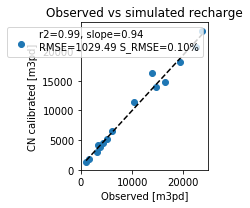


 RMSE is 1029.491078798967
LU code 400, factored by 0.7490707397460937, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561484534058151, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802080112200374, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427198585483221, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471455602483243, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230605938670342, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.89, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951346045786593, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 %

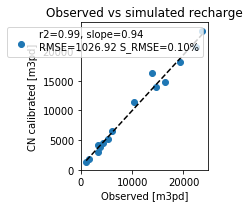


 RMSE is 1026.9205472501724
LU code 400, factored by 0.7490707397460937, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561484534058151, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802080112200374, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427198585483221, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471455602483243, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230605938670342, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.9, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951346045786593, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 %

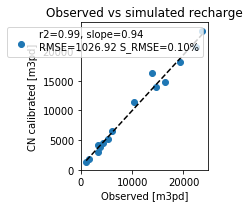


 RMSE is 1026.9205472501724
LU code 400, factored by 0.7490707397460937, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561484534058151, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802080112200374, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427198585483221, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471455602483243, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230605938670342, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.8051346045786593, trying CN set of [25 44 56 61] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091328075190442 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090200922093802 

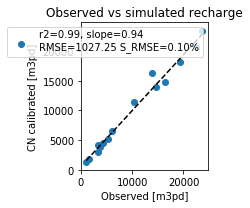


 RMSE is 1027.2461243871705
LU code 400, factored by 0.7490715026855468, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561491173849565, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.780209076325768, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.842720377958381, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471441038359693, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230608373449759, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951347947719444, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 % 

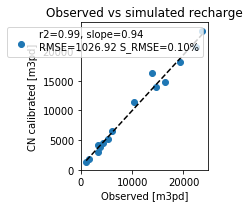


 RMSE is 1026.9205472501724
LU code 400, factored by 0.7490715026855468, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561491173849565, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.780209076325768, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.842720377958381, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471441038359693, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230608373449759, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951347947719444, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 % 

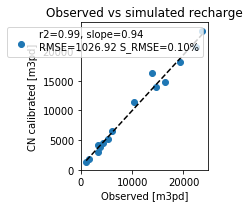


 RMSE is 1026.9205472501724
LU code 400, factored by 0.7590715026855468, trying CN set of [41 54 62 64] 
LU code 500, factored by 0.8561491173849565, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.780209076325768, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.842720377958381, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471441038359693, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230608373449759, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951347947719444, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091685523678833 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090548733439086 % 

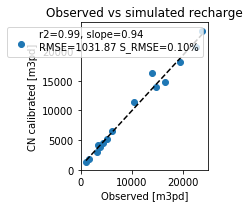


 RMSE is 1031.8748224637684
LU code 400, factored by 0.7490715026855468, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8661491173849565, trying CN set of [38 56 66 71] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.780209076325768, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.842720377958381, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471441038359693, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230608373449759, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951347947719444, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091439233311195 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090308899376157 % 

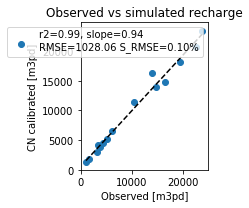


 RMSE is 1028.064491795231
LU code 400, factored by 0.7490715026855468, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561491173849565, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.84802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.780209076325768, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.842720377958381, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471441038359693, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230608373449759, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951347947719444, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 % 


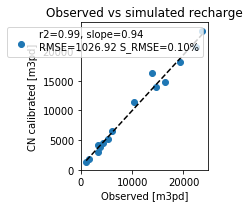


 RMSE is 1026.9205472501724
LU code 400, factored by 0.7490715026855468, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561491173849565, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.790209076325768, trying CN set of [47 59 66 68] 
LU code 1000, factored by 0.842720377958381, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471441038359693, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230608373449759, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951347947719444, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.00914774614923 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090347320788617 % 


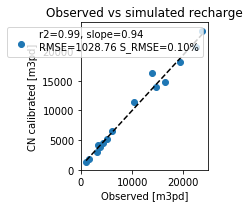


 RMSE is 1028.764278737172
LU code 400, factored by 0.7490715026855468, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561491173849565, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.780209076325768, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.852720377958381, trying CN set of [69 75 78 80] 
LU code 1600, factored by 1.1471441038359693, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230608373449759, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951347947719444, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0092817675081371 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091671813510223 % 


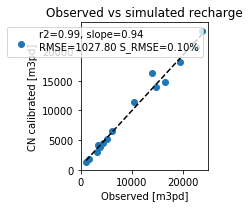


 RMSE is 1027.8024289533769
LU code 400, factored by 0.7490715026855468, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561491173849565, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.780209076325768, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.842720377958381, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1571441038359693, trying CN set of [32 63 81 87] 
LU code 1700, factored by 0.9230608373449759, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 70 85 91] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951347947719444, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0099217837216576 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.009795659265642 % 


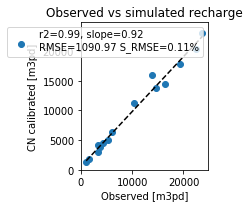


 RMSE is 1090.9708443111376
LU code 400, factored by 0.7490715026855468, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561491173849565, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.780209076325768, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.842720377958381, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471441038359693, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9330608373449759, trying CN set of [33 55 69 73] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 62 72 77] 
LU code 2100, factored by 0.7951347947719444, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091416321197846 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090287853291455 % 

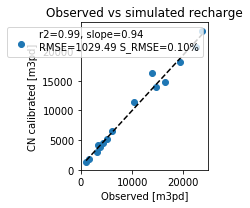


 RMSE is 1029.491078798967
LU code 400, factored by 0.7490715026855468, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561491173849565, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.780209076325768, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.842720377958381, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471441038359693, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230608373449759, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.89, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951347947719444, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 % 


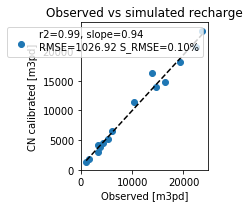


 RMSE is 1026.9205472501724
LU code 400, factored by 0.7490715026855468, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561491173849565, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.780209076325768, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.842720377958381, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471441038359693, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230608373449759, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.9, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951347947719444, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 % 


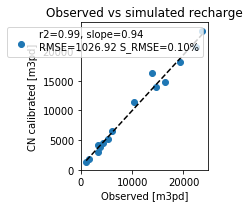


 RMSE is 1026.9205472501724
LU code 400, factored by 0.7490715026855468, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561491173849565, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.780209076325768, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.842720377958381, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471441038359693, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230608373449759, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.8051347947719444, trying CN set of [25 44 56 61] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091328075190442 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090200922093802 % 

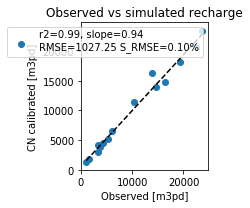


 RMSE is 1027.2461243871705
LU code 400, factored by 0.7490718841552735, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561494493745272, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802096088786333, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427206376634103, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.147143375629792, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230609590839468, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951348898685869, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 %

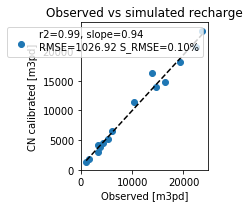


 RMSE is 1026.9205472501724
LU code 400, factored by 0.7490718841552735, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561494493745272, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802096088786333, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427206376634103, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.147143375629792, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230609590839468, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951348898685869, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 %

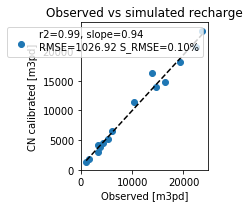


 RMSE is 1026.9205472501724
LU code 400, factored by 0.7590718841552735, trying CN set of [41 54 62 64] 
LU code 500, factored by 0.8561494493745272, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802096088786333, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427206376634103, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.147143375629792, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230609590839468, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951348898685869, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091685523678833 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090548733439086 %

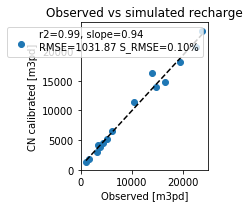


 RMSE is 1031.8748224637684
LU code 400, factored by 0.7490718841552735, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8661494493745272, trying CN set of [38 56 66 71] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802096088786333, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427206376634103, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.147143375629792, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230609590839468, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951348898685869, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091439233311195 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090308899376157 %

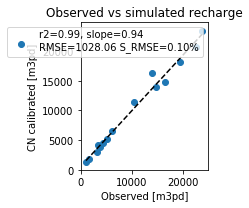


 RMSE is 1028.064491795231
LU code 400, factored by 0.7490718841552735, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561494493745272, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.84802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802096088786333, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427206376634103, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.147143375629792, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230609590839468, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951348898685869, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 % 

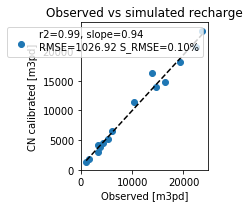


 RMSE is 1026.9205472501724
LU code 400, factored by 0.7490718841552735, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561494493745272, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7902096088786333, trying CN set of [47 59 66 68] 
LU code 1000, factored by 0.8427206376634103, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.147143375629792, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230609590839468, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951348898685869, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.00914774614923 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090347320788617 % 


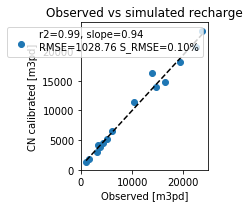


 RMSE is 1028.764278737172
LU code 400, factored by 0.7490718841552735, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561494493745272, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802096088786333, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8527206376634103, trying CN set of [69 75 78 80] 
LU code 1600, factored by 1.147143375629792, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230609590839468, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951348898685869, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0092817675081371 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091671813510223 % 

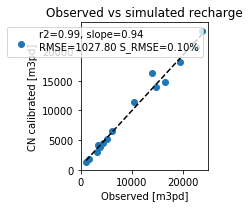


 RMSE is 1027.8024289533769
LU code 400, factored by 0.7490718841552735, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561494493745272, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802096088786333, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427206376634103, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.157143375629792, trying CN set of [32 63 81 87] 
LU code 1700, factored by 0.9230609590839468, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 70 85 91] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951348898685869, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0099217837216576 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.009795659265642 % 

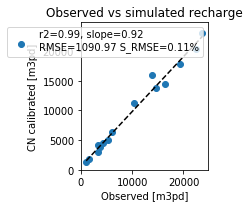


 RMSE is 1090.9708443111376
LU code 400, factored by 0.7490718841552735, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561494493745272, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802096088786333, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427206376634103, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.147143375629792, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9330609590839468, trying CN set of [33 55 69 73] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 62 72 77] 
LU code 2100, factored by 0.7951348898685869, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091416321197846 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090287853291455 %

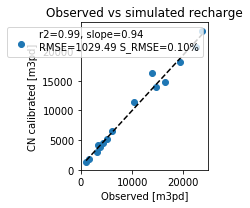


 RMSE is 1029.491078798967
LU code 400, factored by 0.7490718841552735, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561494493745272, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802096088786333, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427206376634103, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.147143375629792, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230609590839468, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.89, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951348898685869, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 % 

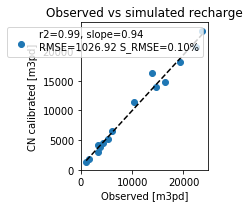


 RMSE is 1026.9205472501724
LU code 400, factored by 0.7490718841552735, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561494493745272, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802096088786333, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427206376634103, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.147143375629792, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230609590839468, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.9, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951348898685869, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 % 

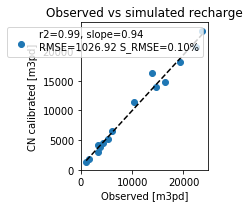


 RMSE is 1026.9205472501724
LU code 400, factored by 0.7490718841552735, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561494493745272, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802096088786333, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427206376634103, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.147143375629792, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230609590839468, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.805134889868587, trying CN set of [25 44 56 61] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091328075190442 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090200922093802 % 

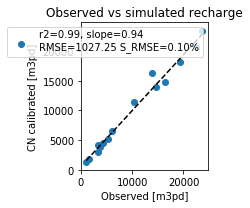


 RMSE is 1027.2461243871705
LU code 400, factored by 0.7490720748901367, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496153693124, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.780209875155066, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427207675159251, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471430115267032, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610199534321, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349374169083, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 %

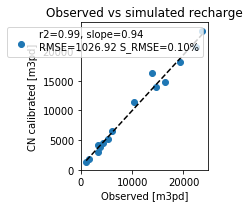


 RMSE is 1026.9205472501724
LU code 400, factored by 0.7490720748901367, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496153693124, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.780209875155066, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427207675159251, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471430115267032, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610199534321, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349374169083, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 %

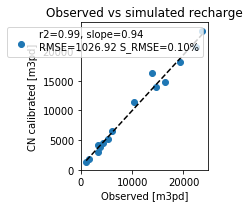


 RMSE is 1026.9205472501724
LU code 400, factored by 0.7590720748901367, trying CN set of [41 54 62 64] 
LU code 500, factored by 0.8561496153693124, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.780209875155066, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427207675159251, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471430115267032, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610199534321, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349374169083, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091685523678833 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090548733439086 %

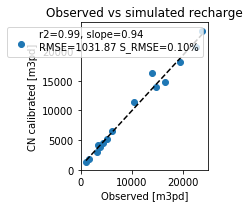


 RMSE is 1031.8748224637684
LU code 400, factored by 0.7490720748901367, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8661496153693125, trying CN set of [38 56 66 71] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.780209875155066, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427207675159251, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471430115267032, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610199534321, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349374169083, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091439233311195 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090308899376157 %

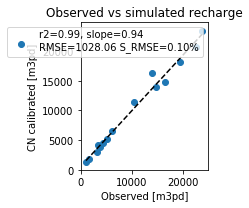


 RMSE is 1028.064491795231
LU code 400, factored by 0.7490720748901367, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496153693124, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.84802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.780209875155066, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427207675159251, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471430115267032, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610199534321, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349374169083, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 % 

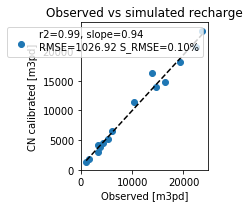


 RMSE is 1026.9205472501724
LU code 400, factored by 0.7490720748901367, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496153693124, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.790209875155066, trying CN set of [47 59 66 68] 
LU code 1000, factored by 0.8427207675159251, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471430115267032, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610199534321, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349374169083, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.00914774614923 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090347320788617 % 


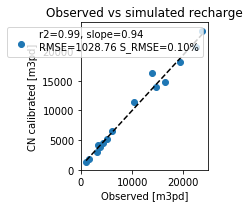


 RMSE is 1028.764278737172
LU code 400, factored by 0.7490720748901367, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496153693124, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.780209875155066, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8527207675159251, trying CN set of [69 75 78 80] 
LU code 1600, factored by 1.1471430115267032, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610199534321, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349374169083, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0092817675081371 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091671813510223 % 

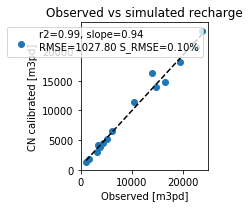


 RMSE is 1027.8024289533769
LU code 400, factored by 0.7490720748901367, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496153693124, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.780209875155066, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427207675159251, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1571430115267032, trying CN set of [32 63 81 87] 
LU code 1700, factored by 0.9230610199534321, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 70 85 91] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349374169083, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0099217837216576 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.009795659265642 % 

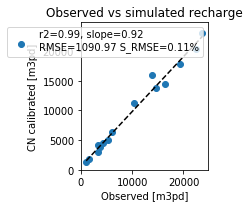


 RMSE is 1090.9708443111376
LU code 400, factored by 0.7490720748901367, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496153693124, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.780209875155066, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427207675159251, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471430115267032, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9330610199534322, trying CN set of [33 55 69 73] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 62 72 77] 
LU code 2100, factored by 0.7951349374169083, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091416321197846 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090287853291455 %

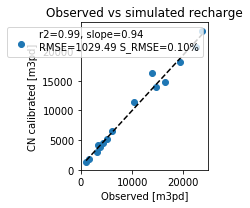


 RMSE is 1029.491078798967
LU code 400, factored by 0.7490720748901367, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496153693124, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.780209875155066, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427207675159251, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471430115267032, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610199534321, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.89, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349374169083, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 % 

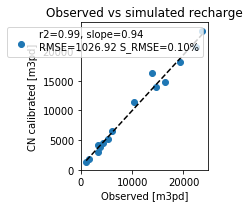


 RMSE is 1026.9205472501724
LU code 400, factored by 0.7490720748901367, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496153693124, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.780209875155066, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427207675159251, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471430115267032, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610199534321, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.9, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349374169083, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 % 

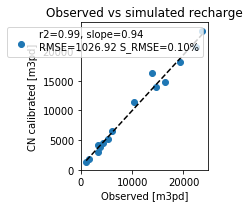


 RMSE is 1026.9205472501724
LU code 400, factored by 0.7490720748901367, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496153693124, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.780209875155066, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427207675159251, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471430115267032, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610199534321, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.8051349374169083, trying CN set of [25 44 56 61] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091328075190442 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090200922093802 %

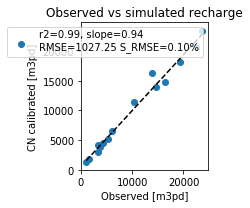


 RMSE is 1027.2461243871705
LU code 400, factored by 0.7490721702575683, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496983667052, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802100082932824, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208324421824, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471428294751589, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610503881749, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.795134961191069, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 %

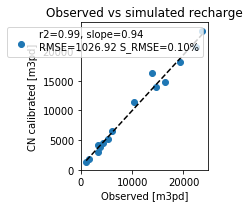


 RMSE is 1026.9205472501724
LU code 400, factored by 0.7490721702575683, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496983667052, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802100082932824, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208324421824, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471428294751589, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610503881749, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.795134961191069, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 %

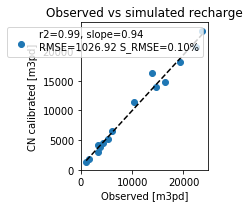


 RMSE is 1026.9205472501724
LU code 400, factored by 0.7590721702575683, trying CN set of [41 54 62 64] 
LU code 500, factored by 0.8561496983667052, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802100082932824, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208324421824, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471428294751589, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610503881749, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.795134961191069, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091685523678833 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090548733439086 %

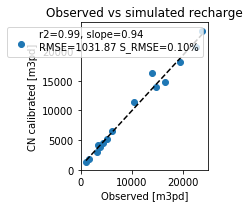


 RMSE is 1031.8748224637684
LU code 400, factored by 0.7490721702575683, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8661496983667052, trying CN set of [38 56 66 71] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802100082932824, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208324421824, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471428294751589, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610503881749, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.795134961191069, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091439233311195 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090308899376157 %

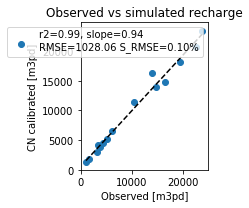


 RMSE is 1028.064491795231
LU code 400, factored by 0.7490721702575683, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496983667052, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.84802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802100082932824, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208324421824, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471428294751589, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610503881749, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.795134961191069, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 % 

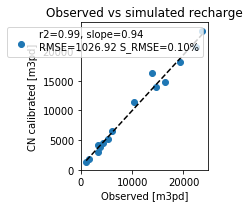


 RMSE is 1026.9205472501724
LU code 400, factored by 0.7490721702575683, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496983667052, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7902100082932824, trying CN set of [47 59 66 68] 
LU code 1000, factored by 0.8427208324421824, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471428294751589, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610503881749, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.795134961191069, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.00914774614923 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090347320788617 % 


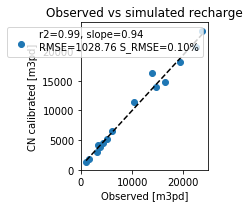


 RMSE is 1028.764278737172
LU code 400, factored by 0.7490721702575683, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496983667052, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802100082932824, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8527208324421824, trying CN set of [69 75 78 80] 
LU code 1600, factored by 1.1471428294751589, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610503881749, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.795134961191069, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0092817675081371 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091671813510223 % 

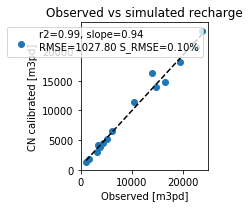


 RMSE is 1027.8024289533769
LU code 400, factored by 0.7490721702575683, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496983667052, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802100082932824, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208324421824, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.157142829475159, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610503881749, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 70 85 91] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.795134961191069, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091424103488387 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090294442468513 % 

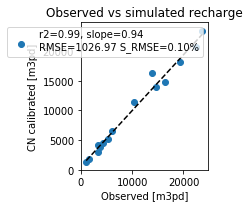


 RMSE is 1026.97413997257
LU code 400, factored by 0.7490721702575683, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496983667052, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802100082932824, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208324421824, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471428294751589, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9330610503881749, trying CN set of [33 55 69 73] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 62 72 77] 
LU code 2100, factored by 0.795134961191069, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091416321197846 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090287853291455 % 


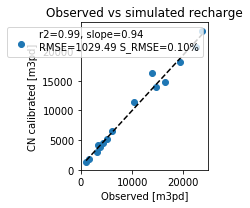


 RMSE is 1029.491078798967
LU code 400, factored by 0.7490721702575683, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496983667052, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802100082932824, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208324421824, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471428294751589, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610503881749, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.89, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.795134961191069, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 % 

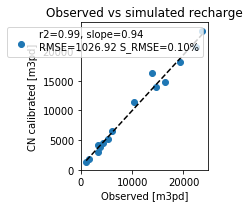


 RMSE is 1026.9205472501724
LU code 400, factored by 0.7490721702575683, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496983667052, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802100082932824, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208324421824, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471428294751589, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610503881749, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.9, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.795134961191069, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 % 

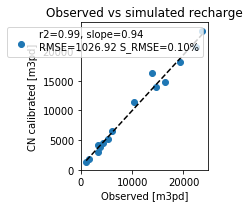


 RMSE is 1026.9205472501724
LU code 400, factored by 0.7490721702575683, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496983667052, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802100082932824, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208324421824, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471428294751589, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610503881749, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.805134961191069, trying CN set of [25 44 56 61] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091328075190442 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090200922093802 %

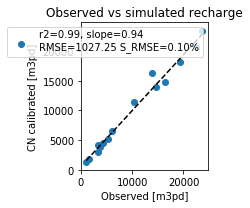


 RMSE is 1027.2461243871705
LU code 400, factored by 0.7490721225738526, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496568680088, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099417241741, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427207999790538, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.147142920500931, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610351708035, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349493039885, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 %

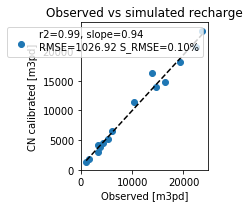


 RMSE is 1026.9205472501724
LU code 400, factored by 0.7490721225738526, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496568680088, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099417241741, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427207999790538, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.147142920500931, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610351708035, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349493039885, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 %

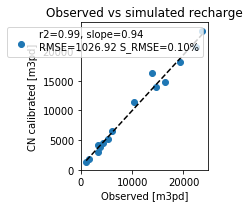


 RMSE is 1026.9205472501724
LU code 400, factored by 0.7590721225738526, trying CN set of [41 54 62 64] 
LU code 500, factored by 0.8561496568680088, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099417241741, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427207999790538, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.147142920500931, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610351708035, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349493039885, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091685523678833 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090548733439086 %

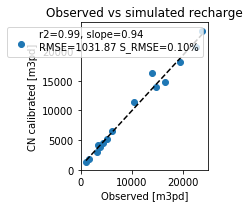


 RMSE is 1031.8748224637684
LU code 400, factored by 0.7490721225738526, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8661496568680088, trying CN set of [38 56 66 71] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099417241741, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427207999790538, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.147142920500931, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610351708035, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349493039885, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091439233311195 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090308899376157 %

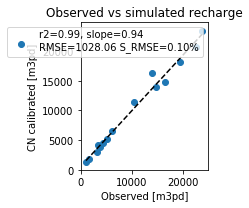


 RMSE is 1028.064491795231
LU code 400, factored by 0.7490721225738526, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496568680088, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.84802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099417241741, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427207999790538, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.147142920500931, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610351708035, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349493039885, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 % 

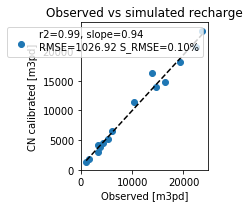


 RMSE is 1026.9205472501724
LU code 400, factored by 0.7490721225738526, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496568680088, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7902099417241741, trying CN set of [47 59 66 68] 
LU code 1000, factored by 0.8427207999790538, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.147142920500931, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610351708035, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349493039885, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.00914774614923 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090347320788617 % 


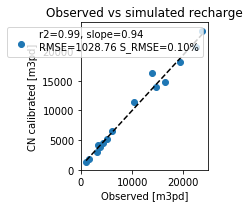


 RMSE is 1028.764278737172
LU code 400, factored by 0.7490721225738526, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496568680088, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099417241741, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8527207999790538, trying CN set of [69 75 78 80] 
LU code 1600, factored by 1.147142920500931, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610351708035, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349493039885, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0092817675081371 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091671813510223 % 

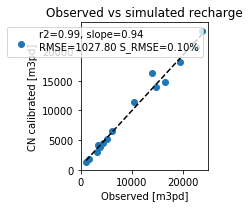


 RMSE is 1027.8024289533769
LU code 400, factored by 0.7490721225738526, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496568680088, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099417241741, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427207999790538, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.157142920500931, trying CN set of [32 63 81 87] 
LU code 1700, factored by 0.9230610351708035, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 70 85 91] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349493039885, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0099217837216576 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.009795659265642 % 

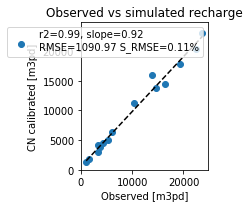


 RMSE is 1090.9708443111376
LU code 400, factored by 0.7490721225738526, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496568680088, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099417241741, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427207999790538, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.147142920500931, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9330610351708035, trying CN set of [33 55 69 73] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 62 72 77] 
LU code 2100, factored by 0.7951349493039885, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091416321197846 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090287853291455 %

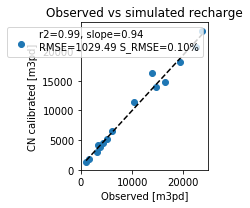


 RMSE is 1029.491078798967
LU code 400, factored by 0.7490721225738526, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496568680088, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099417241741, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427207999790538, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.147142920500931, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610351708035, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.89, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349493039885, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 % 

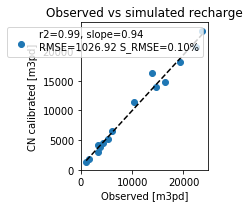


 RMSE is 1026.9205472501724
LU code 400, factored by 0.7490721225738526, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496568680088, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099417241741, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427207999790538, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.147142920500931, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610351708035, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.9, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349493039885, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 % 

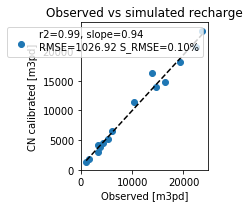


 RMSE is 1026.9205472501724
LU code 400, factored by 0.7490721225738526, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496568680088, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099417241741, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427207999790538, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.147142920500931, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610351708035, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.8051349493039885, trying CN set of [25 44 56 61] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091328075190442 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090200922093802 %

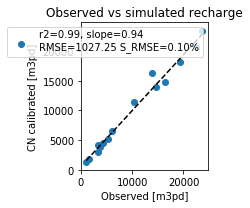


 RMSE is 1027.2461243871705
LU code 400, factored by 0.7490721464157104, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496776173569, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099750087282, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208162106181, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471428749880448, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610427794892, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349552475288, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 

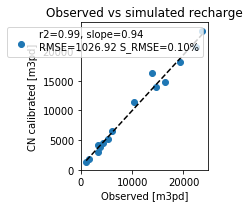


 RMSE is 1026.9205472501724
LU code 400, factored by 0.7490721464157104, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496776173569, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099750087282, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208162106181, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471428749880448, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610427794892, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349552475288, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 

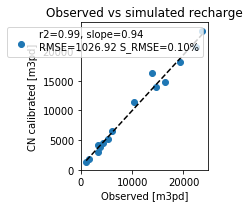


 RMSE is 1026.9205472501724
LU code 400, factored by 0.7590721464157104, trying CN set of [41 54 62 64] 
LU code 500, factored by 0.8561496776173569, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099750087282, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208162106181, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471428749880448, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610427794892, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349552475288, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091685523678833 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090548733439086 

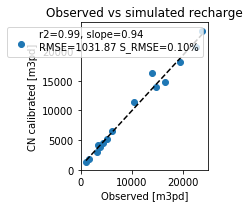


 RMSE is 1031.8748224637684
LU code 400, factored by 0.7490721464157104, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.866149677617357, trying CN set of [38 56 66 71] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099750087282, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208162106181, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471428749880448, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610427794892, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349552475288, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091439233311195 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090308899376157 %

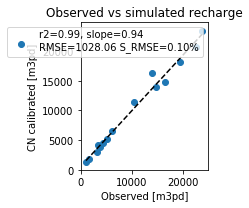


 RMSE is 1028.064491795231
LU code 400, factored by 0.7490721464157104, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496776173569, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.84802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099750087282, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208162106181, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471428749880448, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610427794892, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349552475288, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 %

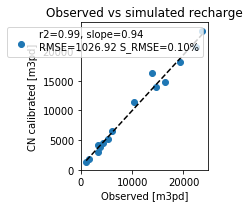


 RMSE is 1026.9205472501724
LU code 400, factored by 0.7490721464157104, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496776173569, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7902099750087282, trying CN set of [47 59 66 68] 
LU code 1000, factored by 0.8427208162106181, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471428749880448, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610427794892, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349552475288, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.00914774614923 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090347320788617 % 

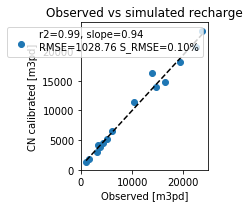


 RMSE is 1028.764278737172
LU code 400, factored by 0.7490721464157104, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496776173569, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099750087282, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8527208162106181, trying CN set of [69 75 78 80] 
LU code 1600, factored by 1.1471428749880448, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610427794892, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349552475288, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0092817675081371 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091671813510223 %

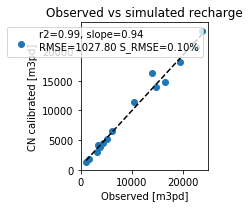


 RMSE is 1027.8024289533769
LU code 400, factored by 0.7490721464157104, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496776173569, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099750087282, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208162106181, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1571428749880448, trying CN set of [32 63 81 87] 
LU code 1700, factored by 0.9230610427794892, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 70 85 91] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349552475288, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0099217837216576 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.009795659265642 %

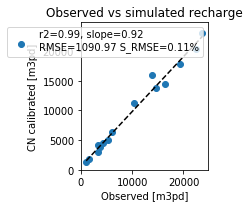


 RMSE is 1090.9708443111376
LU code 400, factored by 0.7490721464157104, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496776173569, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099750087282, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208162106181, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471428749880448, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9330610427794892, trying CN set of [33 55 69 73] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 62 72 77] 
LU code 2100, factored by 0.7951349552475288, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091416321197846 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090287853291455 

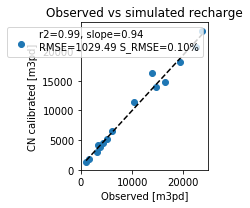


 RMSE is 1029.491078798967
LU code 400, factored by 0.7490721464157104, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496776173569, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099750087282, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208162106181, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471428749880448, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610427794892, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.89, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349552475288, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 %

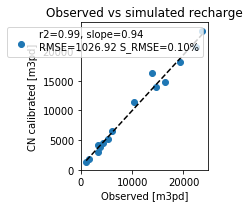


 RMSE is 1026.9205472501724
LU code 400, factored by 0.7490721464157104, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496776173569, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099750087282, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208162106181, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471428749880448, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610427794892, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.9, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349552475288, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 %

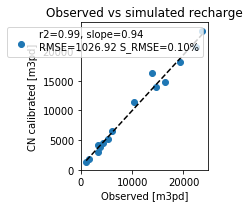


 RMSE is 1026.9205472501724
LU code 400, factored by 0.7490721464157104, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496776173569, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099750087282, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208162106181, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471428749880448, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610427794892, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.8051349552475288, trying CN set of [25 44 56 61] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091328075190442 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090200922093802 

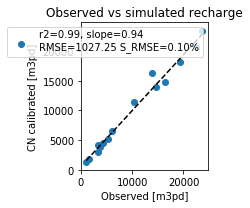


 RMSE is 1027.2461243871705
LU code 400, factored by 0.7490721583366394, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496879920311, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099916510052, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208243264003, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471428522316018, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.923061046583832, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349582192988, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 %

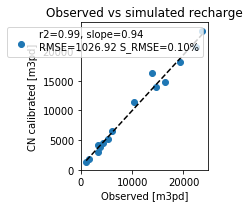


 RMSE is 1026.9205472501724
LU code 400, factored by 0.7490721583366394, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496879920311, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099916510052, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208243264003, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471428522316018, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.923061046583832, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349582192988, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 %

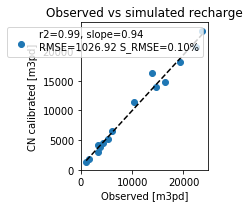


 RMSE is 1026.9205472501724
LU code 400, factored by 0.7590721583366394, trying CN set of [41 54 62 64] 
LU code 500, factored by 0.8561496879920311, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099916510052, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208243264003, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471428522316018, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.923061046583832, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349582192988, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091685523678833 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090548733439086 %

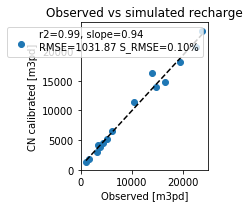


 RMSE is 1031.8748224637684
LU code 400, factored by 0.7490721583366394, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8661496879920311, trying CN set of [38 56 66 71] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099916510052, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208243264003, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471428522316018, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.923061046583832, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349582192988, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091439233311195 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090308899376157 %

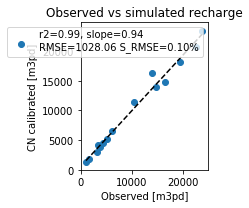


 RMSE is 1028.064491795231
LU code 400, factored by 0.7490721583366394, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496879920311, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.84802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099916510052, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208243264003, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471428522316018, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.923061046583832, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349582192988, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 % 

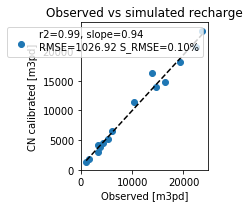


 RMSE is 1026.9205472501724
LU code 400, factored by 0.7490721583366394, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496879920311, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7902099916510053, trying CN set of [47 59 66 68] 
LU code 1000, factored by 0.8427208243264003, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471428522316018, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.923061046583832, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349582192988, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.00914774614923 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090347320788617 % 


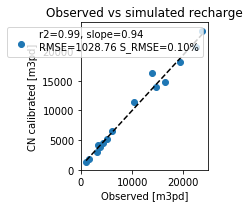


 RMSE is 1028.764278737172
LU code 400, factored by 0.7490721583366394, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496879920311, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099916510052, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8527208243264003, trying CN set of [69 75 78 80] 
LU code 1600, factored by 1.1471428522316018, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.923061046583832, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349582192988, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0092817675081371 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091671813510223 % 

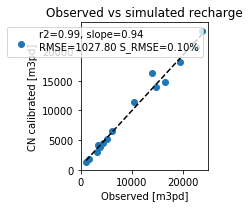


 RMSE is 1027.8024289533769
LU code 400, factored by 0.7490721583366394, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496879920311, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099916510052, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208243264003, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1571428522316018, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.923061046583832, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 70 85 91] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349582192988, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091424103488387 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090294442468513 %

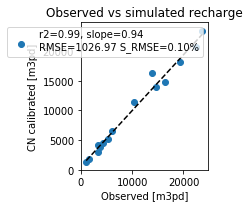


 RMSE is 1026.97413997257
LU code 400, factored by 0.7490721583366394, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496879920311, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099916510052, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208243264003, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471428522316018, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.933061046583832, trying CN set of [33 55 69 73] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 62 72 77] 
LU code 2100, factored by 0.7951349582192988, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091416321197846 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090287853291455 % 


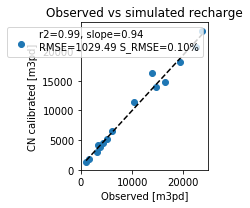


 RMSE is 1029.491078798967
LU code 400, factored by 0.7490721583366394, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496879920311, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099916510052, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208243264003, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471428522316018, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.923061046583832, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.89, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349582192988, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 % 

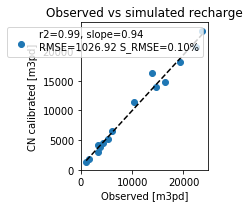


 RMSE is 1026.9205472501724
LU code 400, factored by 0.7490721583366394, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496879920311, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099916510052, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208243264003, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471428522316018, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.923061046583832, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.9, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349582192988, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 % 

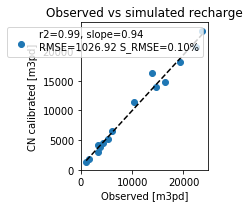


 RMSE is 1026.9205472501724
LU code 400, factored by 0.7490721583366394, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496879920311, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099916510052, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208243264003, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471428522316018, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.923061046583832, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.8051349582192988, trying CN set of [25 44 56 61] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091328075190442 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090200922093802 %

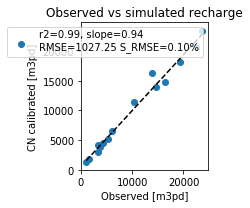


 RMSE is 1027.2461243871705
LU code 400, factored by 0.749072152376175, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496828046941, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099833298668, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208202685091, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471428636098233, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610446816606, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349567334138, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 %

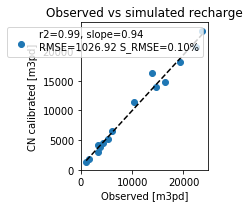


 RMSE is 1026.9205472501724
LU code 400, factored by 0.749072152376175, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496828046941, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099833298668, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208202685091, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471428636098233, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610446816606, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349567334138, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 %

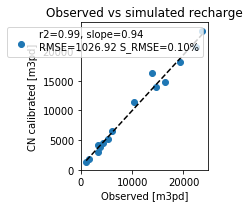


 RMSE is 1026.9205472501724
LU code 400, factored by 0.759072152376175, trying CN set of [41 54 62 64] 
LU code 500, factored by 0.8561496828046941, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099833298668, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208202685091, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471428636098233, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610446816606, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349567334138, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091685523678833 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090548733439086 %

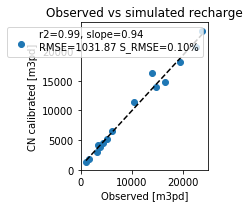


 RMSE is 1031.8748224637684
LU code 400, factored by 0.749072152376175, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8661496828046941, trying CN set of [38 56 66 71] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099833298668, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208202685091, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471428636098233, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610446816606, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349567334138, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091439233311195 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090308899376157 %

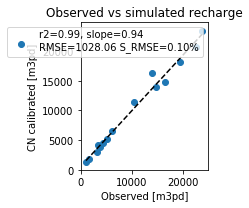


 RMSE is 1028.064491795231
LU code 400, factored by 0.749072152376175, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496828046941, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.84802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099833298668, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208202685091, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471428636098233, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610446816606, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349567334138, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 % 

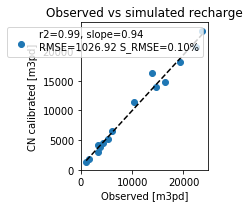


 RMSE is 1026.9205472501724
LU code 400, factored by 0.749072152376175, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496828046941, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7902099833298668, trying CN set of [47 59 66 68] 
LU code 1000, factored by 0.8427208202685091, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471428636098233, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610446816606, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349567334138, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.00914774614923 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090347320788617 % 


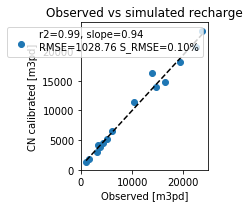


 RMSE is 1028.764278737172
LU code 400, factored by 0.749072152376175, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496828046941, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099833298668, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8527208202685091, trying CN set of [69 75 78 80] 
LU code 1600, factored by 1.1471428636098233, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610446816606, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349567334138, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0092817675081371 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091671813510223 % 

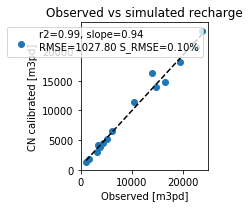


 RMSE is 1027.8024289533769
LU code 400, factored by 0.749072152376175, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496828046941, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099833298668, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208202685091, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1571428636098233, trying CN set of [32 63 81 87] 
LU code 1700, factored by 0.9230610446816606, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 70 85 91] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349567334138, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0099217837216576 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.009795659265642 % 

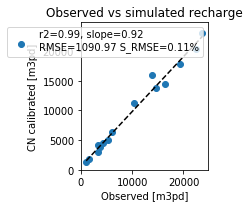


 RMSE is 1090.9708443111376
LU code 400, factored by 0.749072152376175, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496828046941, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099833298668, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208202685091, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471428636098233, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9330610446816606, trying CN set of [33 55 69 73] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 62 72 77] 
LU code 2100, factored by 0.7951349567334138, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091416321197846 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090287853291455 %

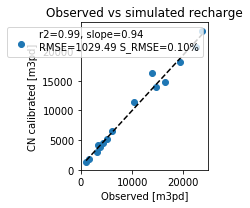


 RMSE is 1029.491078798967
LU code 400, factored by 0.749072152376175, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496828046941, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099833298668, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208202685091, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471428636098233, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610446816606, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.89, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349567334138, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 % 

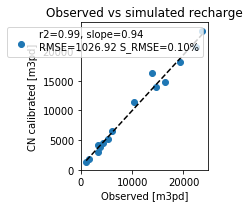


 RMSE is 1026.9205472501724
LU code 400, factored by 0.749072152376175, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496828046941, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099833298668, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208202685091, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471428636098233, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610446816606, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.9, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349567334138, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 % 

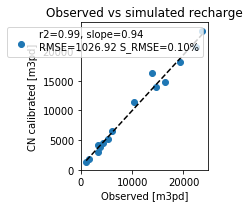


 RMSE is 1026.9205472501724
LU code 400, factored by 0.749072152376175, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496828046941, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099833298668, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208202685091, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471428636098233, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610446816606, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.8051349567334138, trying CN set of [25 44 56 61] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091328075190442 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090200922093802 %

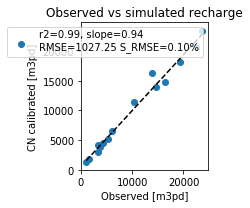


 RMSE is 1027.2461243871705
LU code 400, factored by 0.7490721553564071, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496853983626, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.780209987490436, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208222974547, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471428579207126, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610456327464, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349574763563, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 %

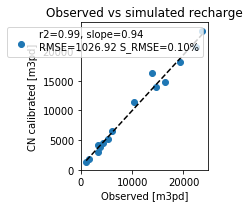


 RMSE is 1026.9205472501724
LU code 400, factored by 0.7490721553564071, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496853983626, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.780209987490436, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208222974547, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471428579207126, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610456327464, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349574763563, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 %

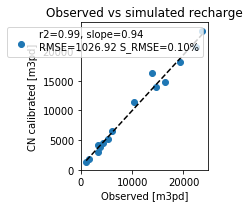


 RMSE is 1026.9205472501724
LU code 400, factored by 0.7590721553564072, trying CN set of [41 54 62 64] 
LU code 500, factored by 0.8561496853983626, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.780209987490436, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208222974547, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471428579207126, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610456327464, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349574763563, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091685523678833 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090548733439086 %

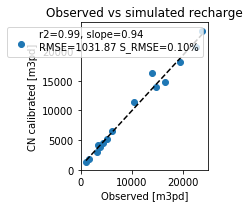


 RMSE is 1031.8748224637684
LU code 400, factored by 0.7490721553564071, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8661496853983626, trying CN set of [38 56 66 71] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.780209987490436, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208222974547, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471428579207126, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610456327464, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349574763563, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091439233311195 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090308899376157 %

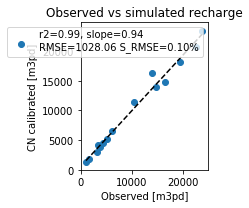


 RMSE is 1028.064491795231
LU code 400, factored by 0.7490721553564071, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496853983626, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.84802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.780209987490436, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208222974547, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471428579207126, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610456327464, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349574763563, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 % 

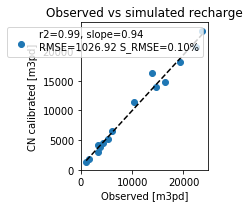


 RMSE is 1026.9205472501724
LU code 400, factored by 0.7490721553564071, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496853983626, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.790209987490436, trying CN set of [47 59 66 68] 
LU code 1000, factored by 0.8427208222974547, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471428579207126, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610456327464, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349574763563, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.00914774614923 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090347320788617 % 


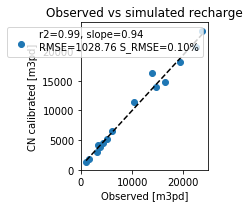


 RMSE is 1028.764278737172
LU code 400, factored by 0.7490721553564071, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496853983626, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.780209987490436, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8527208222974547, trying CN set of [69 75 78 80] 
LU code 1600, factored by 1.1471428579207126, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610456327464, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349574763563, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0092817675081371 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091671813510223 % 

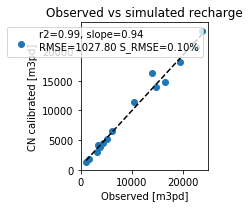


 RMSE is 1027.8024289533769
LU code 400, factored by 0.7490721553564071, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496853983626, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.780209987490436, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208222974547, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1571428579207126, trying CN set of [32 63 81 87] 
LU code 1700, factored by 0.9230610456327464, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 70 85 91] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349574763563, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0099217837216576 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.009795659265642 % 

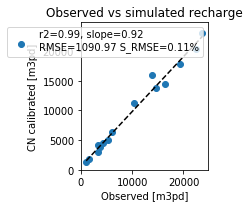


 RMSE is 1090.9708443111376
LU code 400, factored by 0.7490721553564071, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496853983626, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.780209987490436, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208222974547, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471428579207126, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9330610456327464, trying CN set of [33 55 69 73] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 62 72 77] 
LU code 2100, factored by 0.7951349574763563, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091416321197846 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090287853291455 %

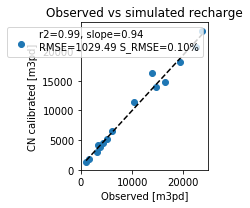


 RMSE is 1029.491078798967
LU code 400, factored by 0.7490721553564071, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496853983626, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.780209987490436, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208222974547, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471428579207126, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610456327464, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.89, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349574763563, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 % 

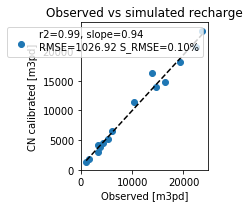


 RMSE is 1026.9205472501724
LU code 400, factored by 0.7490721553564071, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496853983626, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.780209987490436, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208222974547, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471428579207126, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610456327464, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.9, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349574763563, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 % 

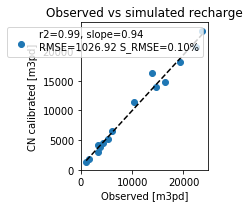


 RMSE is 1026.9205472501724
LU code 400, factored by 0.7490721553564071, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496853983626, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.780209987490436, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208222974547, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471428579207126, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610456327464, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.8051349574763563, trying CN set of [25 44 56 61] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091328075190442 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090200922093802 %

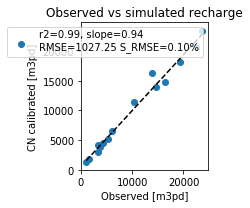


 RMSE is 1027.2461243871705
LU code 400, factored by 0.7490721568465233, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496866951968, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099895707206, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208233119274, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471428550761573, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610461082892, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349578478275, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 

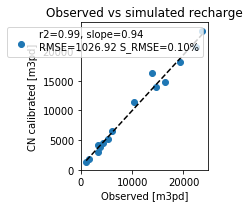


 RMSE is 1026.9205472501724
LU code 400, factored by 0.7490721568465233, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496866951968, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099895707206, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208233119274, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471428550761573, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610461082892, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349578478275, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 

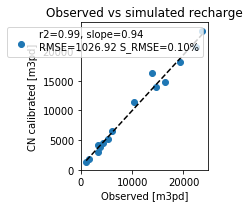


 RMSE is 1026.9205472501724
LU code 400, factored by 0.7590721568465233, trying CN set of [41 54 62 64] 
LU code 500, factored by 0.8561496866951968, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099895707206, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208233119274, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471428550761573, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610461082892, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349578478275, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091685523678833 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090548733439086 

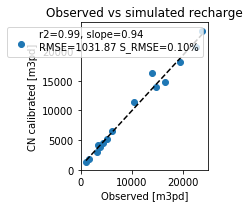


 RMSE is 1031.8748224637684
LU code 400, factored by 0.7490721568465233, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8661496866951968, trying CN set of [38 56 66 71] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099895707206, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208233119274, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471428550761573, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610461082892, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349578478275, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091439233311195 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090308899376157 

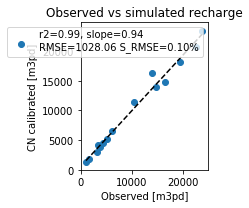


 RMSE is 1028.064491795231
LU code 400, factored by 0.7490721568465233, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496866951968, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.84802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099895707206, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208233119274, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471428550761573, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610461082892, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349578478275, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 %

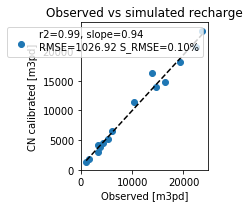


 RMSE is 1026.9205472501724
LU code 400, factored by 0.7490721568465233, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496866951968, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7902099895707206, trying CN set of [47 59 66 68] 
LU code 1000, factored by 0.8427208233119274, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471428550761573, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610461082892, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349578478275, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.00914774614923 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090347320788617 % 

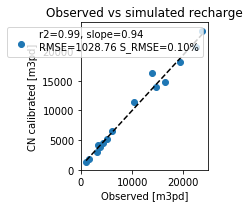


 RMSE is 1028.764278737172
LU code 400, factored by 0.7490721568465233, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496866951968, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099895707206, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8527208233119274, trying CN set of [69 75 78 80] 
LU code 1600, factored by 1.1471428550761573, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610461082892, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349578478275, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0092817675081371 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091671813510223 %

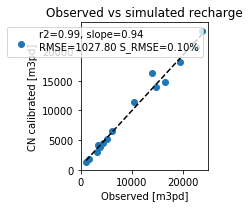


 RMSE is 1027.8024289533769
LU code 400, factored by 0.7490721568465233, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496866951968, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099895707206, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208233119274, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1571428550761573, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610461082892, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 70 85 91] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349578478275, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091424103488387 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090294442468513 

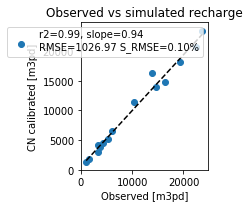


 RMSE is 1026.97413997257
LU code 400, factored by 0.7490721568465233, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496866951968, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099895707206, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208233119274, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471428550761573, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9330610461082892, trying CN set of [33 55 69 73] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 62 72 77] 
LU code 2100, factored by 0.7951349578478275, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091416321197846 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090287853291455 % 

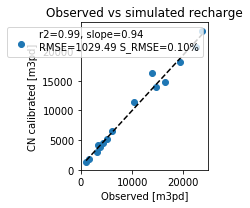


 RMSE is 1029.491078798967
LU code 400, factored by 0.7490721568465233, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496866951968, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099895707206, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208233119274, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471428550761573, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610461082892, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.89, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349578478275, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 %

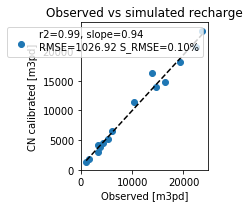


 RMSE is 1026.9205472501724
LU code 400, factored by 0.7490721568465233, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496866951968, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099895707206, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208233119274, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471428550761573, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610461082892, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.9, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349578478275, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 %

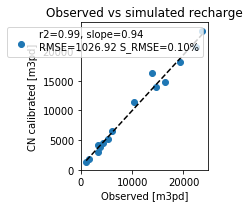


 RMSE is 1026.9205472501724
LU code 400, factored by 0.7490721568465233, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496866951968, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099895707206, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208233119274, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471428550761573, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610461082892, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.8051349578478275, trying CN set of [25 44 56 61] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091328075190442 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090200922093802 

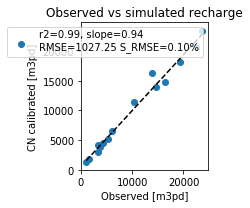


 RMSE is 1027.2461243871705
LU code 400, factored by 0.7490721561014653, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496860467797, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099885305783, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208228046911, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.147142856498435, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610458705177, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.795134957662092, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 % 

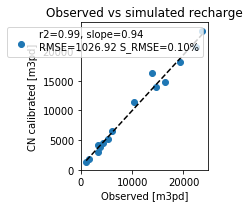


 RMSE is 1026.9205472501724
LU code 400, factored by 0.7490721561014653, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496860467797, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099885305783, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208228046911, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.147142856498435, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610458705177, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.795134957662092, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 % 

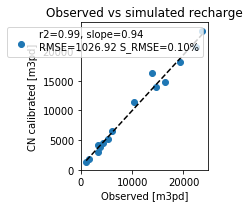


 RMSE is 1026.9205472501724
LU code 400, factored by 0.7590721561014653, trying CN set of [41 54 62 64] 
LU code 500, factored by 0.8561496860467797, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099885305783, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208228046911, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.147142856498435, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610458705177, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.795134957662092, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091685523678833 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090548733439086 % 

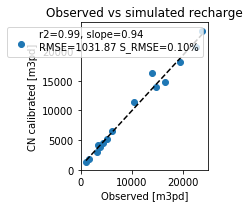


 RMSE is 1031.8748224637684
LU code 400, factored by 0.7490721561014653, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8661496860467797, trying CN set of [38 56 66 71] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099885305783, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208228046911, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.147142856498435, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610458705177, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.795134957662092, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091439233311195 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090308899376157 % 

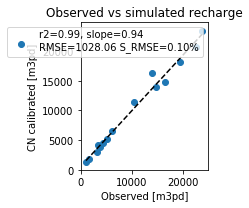


 RMSE is 1028.064491795231
LU code 400, factored by 0.7490721561014653, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496860467797, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.84802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099885305783, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208228046911, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.147142856498435, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610458705177, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.795134957662092, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 % 


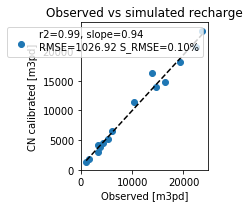


 RMSE is 1026.9205472501724
LU code 400, factored by 0.7490721561014653, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496860467797, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7902099885305783, trying CN set of [47 59 66 68] 
LU code 1000, factored by 0.8427208228046911, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.147142856498435, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610458705177, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.795134957662092, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.00914774614923 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090347320788617 % 


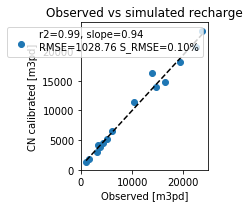


 RMSE is 1028.764278737172
LU code 400, factored by 0.7490721561014653, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496860467797, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099885305783, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8527208228046911, trying CN set of [69 75 78 80] 
LU code 1600, factored by 1.147142856498435, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610458705177, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.795134957662092, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0092817675081371 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091671813510223 % 


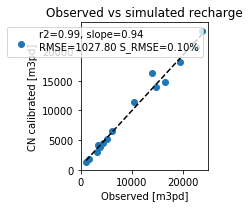


 RMSE is 1027.8024289533769
LU code 400, factored by 0.7490721561014653, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496860467797, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099885305783, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208228046911, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.157142856498435, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610458705177, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 70 85 91] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.795134957662092, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091424103488387 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090294442468513 % 

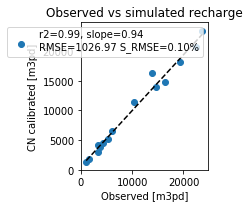


 RMSE is 1026.97413997257
LU code 400, factored by 0.7490721561014653, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496860467797, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099885305783, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208228046911, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.147142856498435, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9330610458705177, trying CN set of [33 55 69 73] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 62 72 77] 
LU code 2100, factored by 0.795134957662092, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091416321197846 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090287853291455 % 


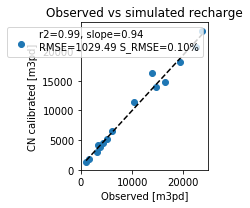


 RMSE is 1029.491078798967
LU code 400, factored by 0.7490721561014653, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496860467797, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099885305783, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208228046911, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.147142856498435, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610458705177, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.89, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.795134957662092, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 % 


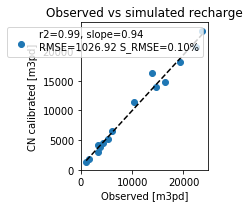


 RMSE is 1026.9205472501724
LU code 400, factored by 0.7490721561014653, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496860467797, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099885305783, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208228046911, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.147142856498435, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610458705177, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.9, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.795134957662092, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 % 


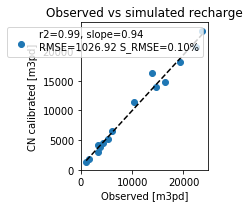


 RMSE is 1026.9205472501724
LU code 400, factored by 0.7490721561014653, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496860467797, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099885305783, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208228046911, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.147142856498435, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610458705177, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.805134957662092, trying CN set of [25 44 56 61] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091328075190442 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090200922093802 % 

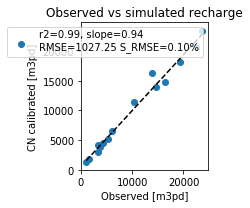


 RMSE is 1027.2461243871705
LU code 400, factored by 0.7490721557289362, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496857225711, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099880105072, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.842720822551073, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471428572095737, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610457516321, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349575692241, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 %

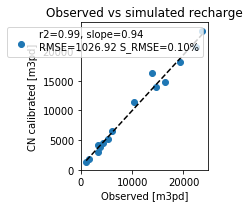


 RMSE is 1026.9205472501724
LU code 400, factored by 0.7490721557289362, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496857225711, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099880105072, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.842720822551073, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471428572095737, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610457516321, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349575692241, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 %

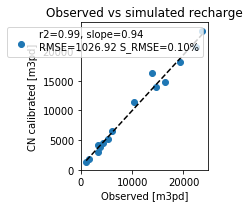


 RMSE is 1026.9205472501724
LU code 400, factored by 0.7590721557289362, trying CN set of [41 54 62 64] 
LU code 500, factored by 0.8561496857225711, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099880105072, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.842720822551073, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471428572095737, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610457516321, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349575692241, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091685523678833 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090548733439086 %

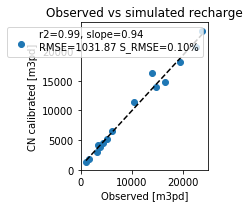


 RMSE is 1031.8748224637684
LU code 400, factored by 0.7490721557289362, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8661496857225711, trying CN set of [38 56 66 71] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099880105072, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.842720822551073, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471428572095737, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610457516321, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349575692241, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091439233311195 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090308899376157 %

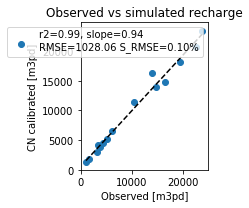


 RMSE is 1028.064491795231
LU code 400, factored by 0.7490721557289362, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496857225711, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.84802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099880105072, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.842720822551073, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471428572095737, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610457516321, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349575692241, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 % 

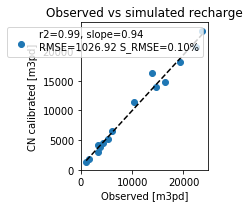


 RMSE is 1026.9205472501724
LU code 400, factored by 0.7490721557289362, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496857225711, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7902099880105072, trying CN set of [47 59 66 68] 
LU code 1000, factored by 0.842720822551073, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471428572095737, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610457516321, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349575692241, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.00914774614923 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090347320788617 % 


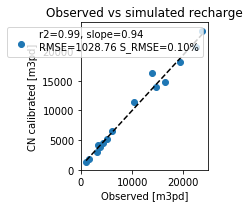


 RMSE is 1028.764278737172
LU code 400, factored by 0.7490721557289362, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496857225711, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099880105072, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.852720822551073, trying CN set of [69 75 78 80] 
LU code 1600, factored by 1.1471428572095737, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610457516321, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349575692241, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0092817675081371 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091671813510223 % 

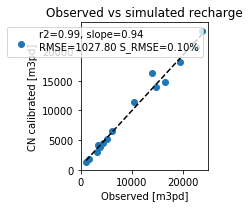


 RMSE is 1027.8024289533769
LU code 400, factored by 0.7490721557289362, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496857225711, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099880105072, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.842720822551073, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1571428572095737, trying CN set of [32 63 81 87] 
LU code 1700, factored by 0.9230610457516321, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 70 85 91] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349575692241, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0099217837216576 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.009795659265642 % 

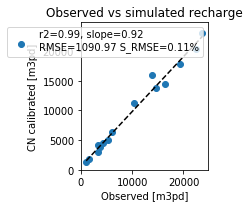


 RMSE is 1090.9708443111376
LU code 400, factored by 0.7490721557289362, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496857225711, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099880105072, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.842720822551073, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471428572095737, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9330610457516321, trying CN set of [33 55 69 73] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 62 72 77] 
LU code 2100, factored by 0.7951349575692241, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091416321197846 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090287853291455 %

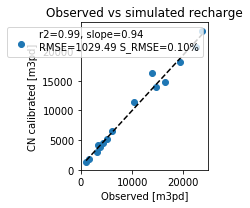


 RMSE is 1029.491078798967
LU code 400, factored by 0.7490721557289362, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496857225711, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099880105072, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.842720822551073, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471428572095737, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610457516321, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.89, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349575692241, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 % 

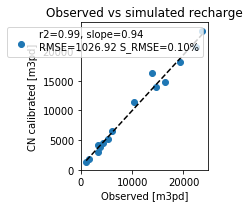


 RMSE is 1026.9205472501724
LU code 400, factored by 0.7490721557289362, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496857225711, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099880105072, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.842720822551073, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471428572095737, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610457516321, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.9, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349575692241, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 % 

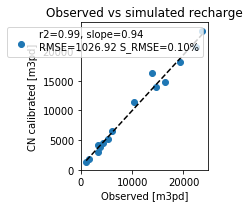


 RMSE is 1026.9205472501724
LU code 400, factored by 0.7490721557289362, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496857225711, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099880105072, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.842720822551073, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471428572095737, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610457516321, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.8051349575692242, trying CN set of [25 44 56 61] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091328075190442 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090200922093802 %

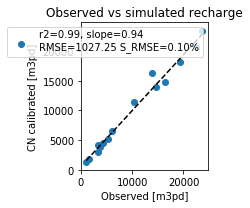


 RMSE is 1027.2461243871705
LU code 400, factored by 0.7490721559152007, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496858846754, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099882705428, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.842720822677882, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471428568540043, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.923061045811075, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349576156581, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 % 

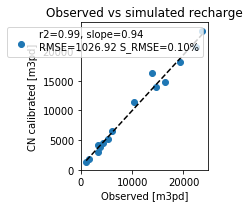


 RMSE is 1026.9205472501724
LU code 400, factored by 0.7490721559152007, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496858846754, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099882705428, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.842720822677882, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471428568540043, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.923061045811075, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349576156581, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 % 

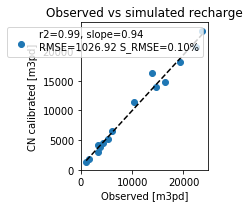


 RMSE is 1026.9205472501724
LU code 400, factored by 0.7590721559152007, trying CN set of [41 54 62 64] 
LU code 500, factored by 0.8561496858846754, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099882705428, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.842720822677882, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471428568540043, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.923061045811075, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349576156581, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091685523678833 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090548733439086 % 

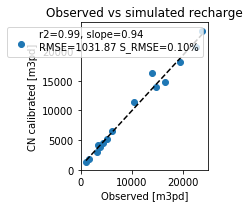


 RMSE is 1031.8748224637684
LU code 400, factored by 0.7490721559152007, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8661496858846754, trying CN set of [38 56 66 71] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099882705428, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.842720822677882, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471428568540043, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.923061045811075, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349576156581, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091439233311195 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090308899376157 % 

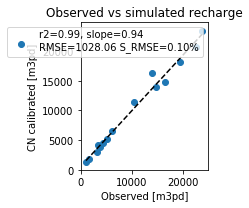


 RMSE is 1028.064491795231
LU code 400, factored by 0.7490721559152007, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496858846754, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.84802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099882705428, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.842720822677882, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471428568540043, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.923061045811075, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349576156581, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 % 


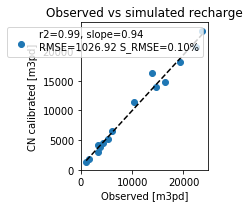


 RMSE is 1026.9205472501724
LU code 400, factored by 0.7490721559152007, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496858846754, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7902099882705428, trying CN set of [47 59 66 68] 
LU code 1000, factored by 0.842720822677882, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471428568540043, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.923061045811075, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349576156581, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.00914774614923 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090347320788617 % 


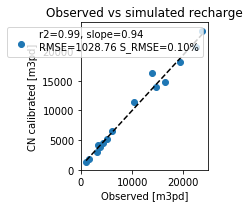


 RMSE is 1028.764278737172
LU code 400, factored by 0.7490721559152007, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496858846754, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099882705428, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.852720822677882, trying CN set of [69 75 78 80] 
LU code 1600, factored by 1.1471428568540043, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.923061045811075, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349576156581, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0092817675081371 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091671813510223 % 


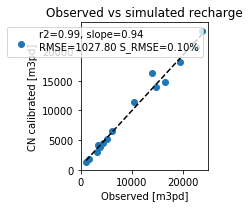


 RMSE is 1027.8024289533769
LU code 400, factored by 0.7490721559152007, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496858846754, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099882705428, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.842720822677882, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1571428568540043, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.923061045811075, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 70 85 91] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349576156581, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091424103488387 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090294442468513 % 

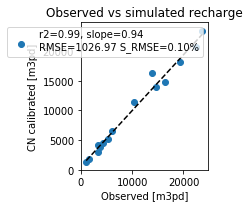


 RMSE is 1026.97413997257
LU code 400, factored by 0.7490721559152007, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496858846754, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099882705428, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.842720822677882, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471428568540043, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.933061045811075, trying CN set of [33 55 69 73] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 62 72 77] 
LU code 2100, factored by 0.7951349576156581, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091416321197846 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090287853291455 % 


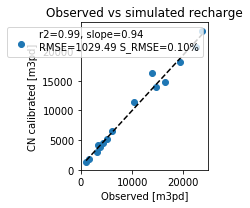


 RMSE is 1029.491078798967
LU code 400, factored by 0.7490721559152007, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496858846754, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099882705428, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.842720822677882, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471428568540043, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.923061045811075, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.89, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349576156581, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 % 


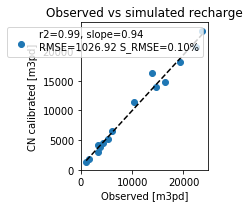


 RMSE is 1026.9205472501724
LU code 400, factored by 0.7490721559152007, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496858846754, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099882705428, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.842720822677882, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471428568540043, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.923061045811075, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.9, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349576156581, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 % 


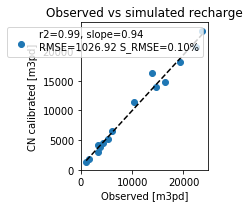


 RMSE is 1026.9205472501724
LU code 400, factored by 0.7490721559152007, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496858846754, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099882705428, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.842720822677882, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471428568540043, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.923061045811075, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.8051349576156581, trying CN set of [25 44 56 61] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091328075190442 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090200922093802 % 

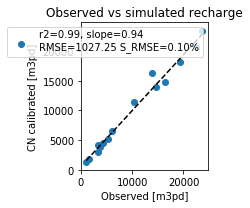


 RMSE is 1027.2461243871705
LU code 400, factored by 0.7490721558220684, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496858036233, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099881405249, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208226144774, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.147142857031789, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610457813535, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349575924411, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 %

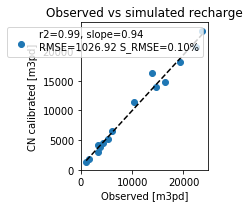


 RMSE is 1026.9205472501724
LU code 400, factored by 0.7490721558220684, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496858036233, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099881405249, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208226144774, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.147142857031789, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610457813535, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349575924411, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 %

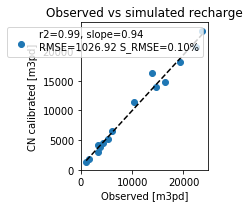


 RMSE is 1026.9205472501724
LU code 400, factored by 0.7590721558220684, trying CN set of [41 54 62 64] 
LU code 500, factored by 0.8561496858036233, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099881405249, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208226144774, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.147142857031789, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610457813535, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349575924411, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091685523678833 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090548733439086 %

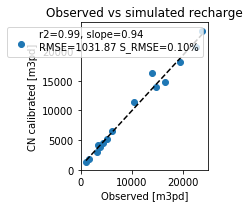


 RMSE is 1031.8748224637684
LU code 400, factored by 0.7490721558220684, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8661496858036233, trying CN set of [38 56 66 71] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099881405249, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208226144774, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.147142857031789, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610457813535, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349575924411, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091439233311195 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090308899376157 %

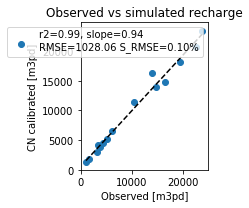


 RMSE is 1028.064491795231
LU code 400, factored by 0.7490721558220684, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496858036233, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.84802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099881405249, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208226144774, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.147142857031789, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610457813535, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349575924411, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 % 

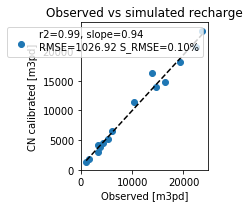


 RMSE is 1026.9205472501724
LU code 400, factored by 0.7490721558220684, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496858036233, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7902099881405249, trying CN set of [47 59 66 68] 
LU code 1000, factored by 0.8427208226144774, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.147142857031789, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610457813535, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349575924411, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.00914774614923 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090347320788617 % 


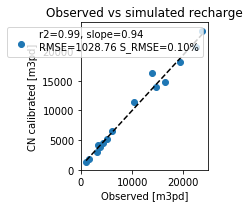


 RMSE is 1028.764278737172
LU code 400, factored by 0.7490721558220684, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496858036233, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099881405249, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8527208226144775, trying CN set of [69 75 78 80] 
LU code 1600, factored by 1.147142857031789, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610457813535, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349575924411, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0092817675081371 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091671813510223 % 

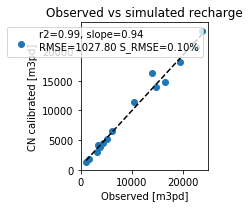


 RMSE is 1027.8024289533769
LU code 400, factored by 0.7490721558220684, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496858036233, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099881405249, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208226144774, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.157142857031789, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610457813535, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 70 85 91] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349575924411, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091424103488387 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090294442468513 %

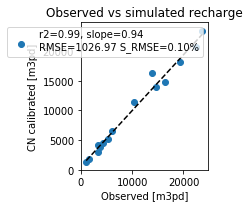


 RMSE is 1026.97413997257
LU code 400, factored by 0.7490721558220684, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496858036233, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099881405249, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208226144774, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.147142857031789, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9330610457813535, trying CN set of [33 55 69 73] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 62 72 77] 
LU code 2100, factored by 0.7951349575924411, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091416321197846 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090287853291455 % 


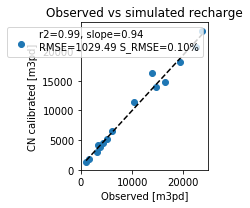


 RMSE is 1029.491078798967
LU code 400, factored by 0.7490721558220684, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496858036233, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099881405249, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208226144774, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.147142857031789, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610457813535, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.89, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349575924411, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 % 

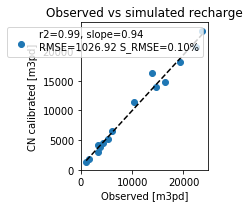


 RMSE is 1026.9205472501724
LU code 400, factored by 0.7490721558220684, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496858036233, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099881405249, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208226144774, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.147142857031789, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610457813535, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.9, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349575924411, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 % 

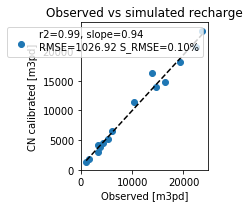


 RMSE is 1026.9205472501724
LU code 400, factored by 0.7490721558220684, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496858036233, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099881405249, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208226144774, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.147142857031789, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610457813535, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.8051349575924411, trying CN set of [25 44 56 61] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091328075190442 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090200922093802 %

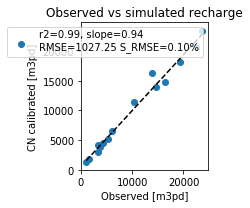


 RMSE is 1027.2461243871705
LU code 400, factored by 0.7490721557755022, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496857630972, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099880755161, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208225827751, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471428571206814, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610457664927, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349575808326, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 

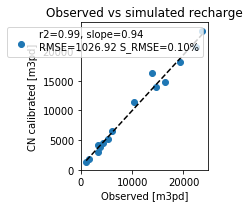


 RMSE is 1026.9205472501724
LU code 400, factored by 0.7490721557755022, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496857630972, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099880755161, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208225827751, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471428571206814, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610457664927, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349575808326, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 

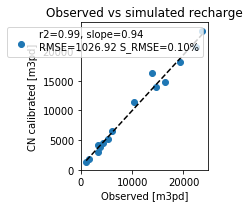


 RMSE is 1026.9205472501724
LU code 400, factored by 0.7590721557755022, trying CN set of [41 54 62 64] 
LU code 500, factored by 0.8561496857630972, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099880755161, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208225827751, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471428571206814, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610457664927, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349575808326, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091685523678833 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090548733439086 

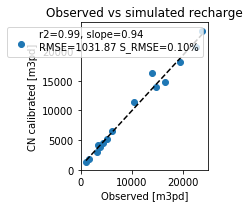


 RMSE is 1031.8748224637684
LU code 400, factored by 0.7490721557755022, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8661496857630973, trying CN set of [38 56 66 71] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099880755161, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208225827751, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471428571206814, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610457664927, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349575808326, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091439233311195 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090308899376157 

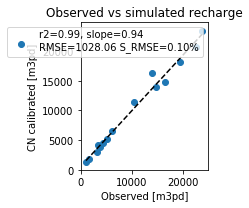


 RMSE is 1028.064491795231
LU code 400, factored by 0.7490721557755022, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496857630972, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.84802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099880755161, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208225827751, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471428571206814, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610457664927, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349575808326, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 %

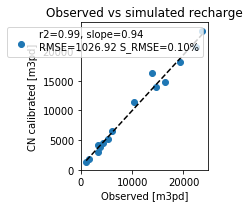


 RMSE is 1026.9205472501724
LU code 400, factored by 0.7490721557755022, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496857630972, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7902099880755161, trying CN set of [47 59 66 68] 
LU code 1000, factored by 0.8427208225827751, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471428571206814, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610457664927, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349575808326, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.00914774614923 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090347320788617 % 

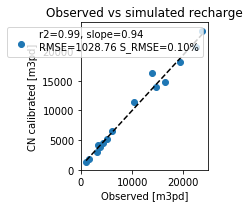


 RMSE is 1028.764278737172
LU code 400, factored by 0.7490721557755022, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496857630972, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099880755161, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8527208225827752, trying CN set of [69 75 78 80] 
LU code 1600, factored by 1.1471428571206814, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610457664927, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349575808326, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0092817675081371 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091671813510223 %

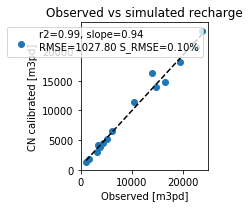


 RMSE is 1027.8024289533769
LU code 400, factored by 0.7490721557755022, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496857630972, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099880755161, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208225827751, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1571428571206814, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610457664927, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 70 85 91] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349575808326, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091424103488387 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090294442468513 

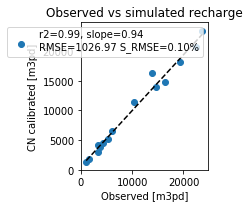


 RMSE is 1026.97413997257
LU code 400, factored by 0.7490721557755022, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496857630972, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099880755161, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208225827751, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471428571206814, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9330610457664927, trying CN set of [33 55 69 73] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 62 72 77] 
LU code 2100, factored by 0.7951349575808326, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091416321197846 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090287853291455 % 

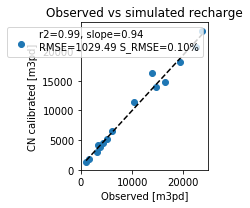


 RMSE is 1029.491078798967
LU code 400, factored by 0.7490721557755022, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496857630972, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099880755161, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208225827751, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471428571206814, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610457664927, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.89, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349575808326, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 %

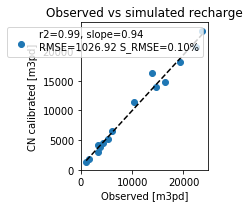


 RMSE is 1026.9205472501724
LU code 400, factored by 0.7490721557755022, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496857630972, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099880755161, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208225827751, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471428571206814, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610457664927, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.9, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349575808326, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 %

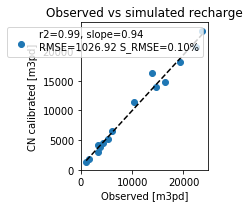


 RMSE is 1026.9205472501724
LU code 400, factored by 0.7490721557755022, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496857630972, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099880755161, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208225827751, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471428571206814, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610457664927, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.8051349575808326, trying CN set of [25 44 56 61] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091328075190442 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090200922093802 

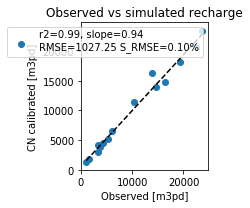


 RMSE is 1027.2461243871705
LU code 400, factored by 0.7490721557755022, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496857630972, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099880755161, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208225827751, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471428571206814, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610457664927, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349575808326, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 

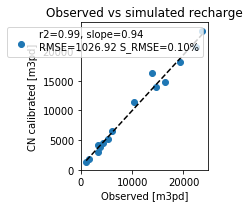


 RMSE is 1026.9205472501724
LU code 400, factored by 0.7490721557755022, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496857630972, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099880755161, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208225827751, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471428571206814, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610457664927, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349575808326, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 

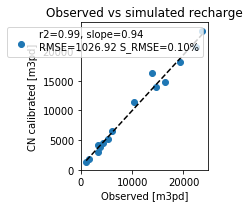


 RMSE is 1026.9205472501724
LU code 400, factored by 0.7590721557755022, trying CN set of [41 54 62 64] 
LU code 500, factored by 0.8561496857630972, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099880755161, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208225827751, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471428571206814, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610457664927, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349575808326, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091685523678833 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090548733439086 

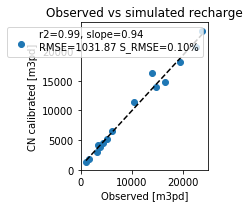


 RMSE is 1031.8748224637684
LU code 400, factored by 0.7490721557755022, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8661496857630973, trying CN set of [38 56 66 71] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099880755161, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208225827751, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471428571206814, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610457664927, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349575808326, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091439233311195 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090308899376157 

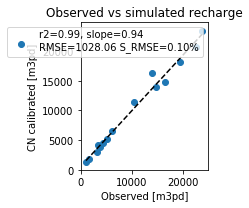


 RMSE is 1028.064491795231
LU code 400, factored by 0.7490721557755022, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496857630972, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.84802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099880755161, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208225827751, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471428571206814, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610457664927, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349575808326, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 %

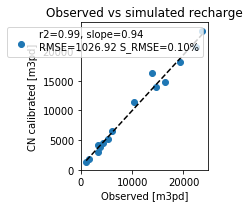


 RMSE is 1026.9205472501724
LU code 400, factored by 0.7490721557755022, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496857630972, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7902099880755161, trying CN set of [47 59 66 68] 
LU code 1000, factored by 0.8427208225827751, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471428571206814, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610457664927, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349575808326, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.00914774614923 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090347320788617 % 

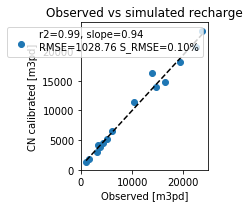


 RMSE is 1028.764278737172
LU code 400, factored by 0.7490721557755022, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496857630972, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099880755161, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8527208225827752, trying CN set of [69 75 78 80] 
LU code 1600, factored by 1.1471428571206814, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610457664927, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349575808326, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0092817675081371 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091671813510223 %

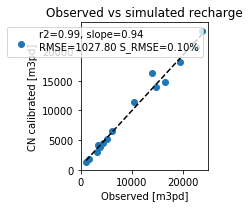


 RMSE is 1027.8024289533769
LU code 400, factored by 0.7490721557755022, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496857630972, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099880755161, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208225827751, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1571428571206814, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610457664927, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 70 85 91] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349575808326, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091424103488387 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090294442468513 

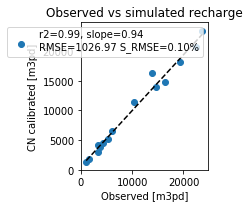


 RMSE is 1026.97413997257
LU code 400, factored by 0.7490721557755022, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496857630972, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099880755161, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208225827751, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471428571206814, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9330610457664927, trying CN set of [33 55 69 73] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 62 72 77] 
LU code 2100, factored by 0.7951349575808326, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091416321197846 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090287853291455 % 

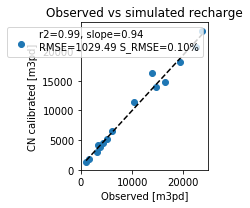


 RMSE is 1029.491078798967
LU code 400, factored by 0.7490721557755022, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496857630972, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099880755161, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208225827751, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471428571206814, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610457664927, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.89, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349575808326, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 %

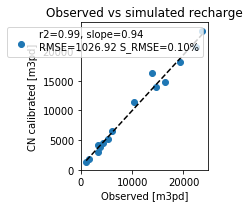


 RMSE is 1026.9205472501724
LU code 400, factored by 0.7490721557755022, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496857630972, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099880755161, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208225827751, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471428571206814, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610457664927, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.9, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.7951349575808326, trying CN set of [25 43 55 60] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091312861492305 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090185914392893 %

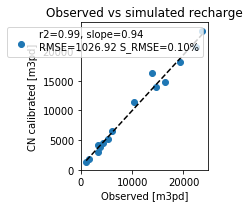


 RMSE is 1026.9205472501724
LU code 400, factored by 0.7490721557755022, trying CN set of [41 53 61 63] 
LU code 500, factored by 0.8561496857630972, trying CN set of [37 55 65 70] 
LU code 700, factored by 0.83802449, trying CN set of [31 51 62 66] 
LU code 800, factored by 0.7802099880755161, trying CN set of [46 58 65 67] 
LU code 1000, factored by 0.8427208225827751, trying CN set of [68 74 77 79] 
LU code 1600, factored by 1.1471428571206814, trying CN set of [32 63 80 87] 
LU code 1700, factored by 0.9230610457664927, trying CN set of [33 55 68 72] 
LU code 1400, factored by 0.88, trying CN set of [42 69 84 90] 
LU code 1500, factored by 0.89, trying CN set of [43 61 71 76] 
LU code 2100, factored by 0.8051349575808326, trying CN set of [25 44 56 61] 
Go baby go
Run model 1, no MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0091328075190442 % 
Caclculating MFR
Run model 2, with MFR
WATER BALANCE ratio: outs over ins water budget balanece =  1.0090200922093802 

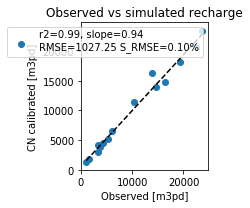


 RMSE is 1027.2461243871705


     fun: 1026.9205472501724
     jac: array([ 495.42752136,  114.39445451,    0.        ,  184.3731487 ,
         88.18817032,    5.35927224,  257.05315488,    0.        ,
          0.        ,   32.5577137 ])
 message: 'Converged (|x_n-x_(n-1)| ~= 0)'
    nfev: 33
     nit: 1
  status: 2
 success: True
       x: array([ 0.74907216,  0.85614969,  0.83802449,  0.78020999,  0.84272082,
        1.14714286,  0.92306105,  0.88      ,  0.89      ,  0.79513496])

In [7]:
#TESTING # 3 

params_list =[]; rmse_list = []; slope_list=[]


def optimize_model(params):
    
    try:
    
        # Read Landuselookup
        Original_table = pd.read_csv('Landuse_lookup_maui_mod5_original.txt', sep='\t')
        New_table = Original_table.copy()

        ### MOdify CN values
        # 400:'Cultivated_Land'
        New_table.iloc[3,4:8] = Original_table.iloc[3,4:8].apply(changeo, args=[params[0]])
        # 500:'Agroforest', 
        New_table.iloc[4,4:8] = Original_table.iloc[4,4:8].apply(changeo, args=[params[1]])
        # 700:'Open_Space',
        New_table.iloc[6,4:8] = Original_table.iloc[6,4:8].apply(changeo, args=[params[2]])
        # 800:'Developed_Woodlands', 
        New_table.iloc[7,4:8] = Original_table.iloc[7,4:8].apply(changeo, args=[params[3]])
        # 1000:'Buildings', 
        New_table.iloc[9,4:8] = Original_table.iloc[9,4:8].apply(changeo, args=[params[4]])
        # 1600:'Lowland_Rainforest',
        New_table.iloc[15,4:8] = Original_table.iloc[15,4:8].apply(changeo, args=[params[5]])
        # 1700:'Successional_Scrub', 
        New_table.iloc[16,4:8] = Original_table.iloc[16,4:8].apply(changeo, args=[params[6]])
        
        # less key parameters
        # 1400:'Grassland', 
        New_table.iloc[13,4:8] = Original_table.iloc[13,4:8].apply(changeo, args=[params[5]])
        # 1500:'Upland_Scrub', 
        New_table.iloc[14,4:8] = Original_table.iloc[14,4:8].apply(changeo, args=[params[6]])
        # 2100:'Montane_Rainforest', 
        New_table.iloc[20,4:8] = Original_table.iloc[20,4:8].apply(changeo, args=[params[9]])

        print("LU code {}, factored by {}, trying CN set of {} ".format(New_table.iloc[3,0], params[0], New_table.iloc[3,4:8].values))
        print("LU code {}, factored by {}, trying CN set of {} ".format(New_table.iloc[4,0], params[1], New_table.iloc[4,4:8].values))
        print("LU code {}, factored by {}, trying CN set of {} ".format(New_table.iloc[6,0], params[2], New_table.iloc[6,4:8].values))
        print("LU code {}, factored by {}, trying CN set of {} ".format(New_table.iloc[7,0], params[3], New_table.iloc[7,4:8].values))
        print("LU code {}, factored by {}, trying CN set of {} ".format(New_table.iloc[9,0], params[4], New_table.iloc[9,4:8].values))
        print("LU code {}, factored by {}, trying CN set of {} ".format(New_table.iloc[15,0], params[5], New_table.iloc[15,4:8].values))
        print("LU code {}, factored by {}, trying CN set of {} ".format(New_table.iloc[16,0], params[6], New_table.iloc[16,4:8].values))
        
        print("LU code {}, factored by {}, trying CN set of {} ".format(New_table.iloc[13,0], params[7], New_table.iloc[13,4:8].values))
        print("LU code {}, factored by {}, trying CN set of {} ".format(New_table.iloc[14,0], params[8], New_table.iloc[14,4:8].values))
        print("LU code {}, factored by {}, trying CN set of {} ".format(New_table.iloc[20,0], params[9], New_table.iloc[20,4:8].values))


        # Write the new changed dataframe into a new lookup table txt
        New_table.to_csv("Landuse_lookup_cal.txt", index=False, sep='\t')

        # run model
        CN_Computerd_vals_frame = run_model("Go baby go", x_dim, y_dim)


        # compare results and plot printout
        Compare_frame = Observed_Vals.merge(CN_Computerd_vals_frame, how='outer', on='gage_name')

        fig, ax = plt.subplots(figsize = (3,3))

        xval = Compare_frame['obsnet_infiltration_annual_m3pd']
        yval = Compare_frame['net_infiltration_annual_m3pd']

        slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(xval, yval)                              # get stats on regression
        mea = np.mean(np.abs(xval-yval))
        rmse = np.sqrt(np.mean(np.abs(xval-yval)**2))                                     # couple more basic stats on the residuals, Mean absolute errir and root RMSE root mean squared error
        Std_RMSE = rmse/((np.mean(xval)+np.mean(yval))/2)                                 # standardize the RMSE as a % of the mean
        ax.plot(np.unique(xval), np.poly1d(np.polyfit(xval, yval, 1))(np.unique(xval)),  color = 'k', linestyle = "--")    # plot the linear regresion line 
        ax.scatter(xval, yval, label="r2={0:1.2f}, slope={1:1.2f}\nRMSE={2:1.2f} S_RMSE={3:1.2f}%".format(r_value, slope, rmse, Std_RMSE))   
        ax.set_title('Observed vs simulated recharge')
        axLims = max([yval.max(), xval.max()])
        ax.set_ylim([0,axLims+axLims*.05]); ax.set_xlim([0,axLims+axLims*.05])
        plt.xlabel("Observed [m3pd]"); plt.ylabel("CN calibrated [m3pd]")
        ax.legend()
        plt.tight_layout() 
        plt.show()
        
        # record metrics 
        print("\n RMSE is {}".format(rmse))
        params_list.append(params)
        rmse_list.append(rmse)
        slope_list.append(slope)
        results_frame = pd.DataFrame({"Parameters":params_list, "RMSE":rmse_list, "Slope":slope_list})
        results_frame.to_csv("Progress_COPY_no_open_wRunning.csv")

    
        return rmse
    
    except: 
        print("................................................ \n")
        print("Some ESRI trash bug threw an error")
        print("................................................ \n")
        
        if len(rmse_list)>0: 
            rmse_broke = rmse_list[-1]
        else: 
            rmse_broke = 1200
        
        return rmse_broke
        

    
##### RUN IT ########
bounds =[(.7, 1.3), (.7, 1.3),(.7, 1.3),(.7, 1.3),(.7, 1.3),(.7, 1.3),(.7, 1.3),(.7, 1.3),(.7, 1.3),(.7, 1.3),] 

startingarray =  [ 0.75      ,  0.85695718,  0.83802449,  0.78150531,  0.8433525 , 1.14537165,  0.92335715,  0.88      ,  0.89      ,  0.79536626]

results = opt.minimize(optimize_model, x0= startingarray, method="TNC", bounds=bounds, tol = .1, options={"eps":0.01,  "maxiter":100})
results

### Just for refrerence 

In [ ]:
Lukeys = {400:'Cultivated_Land', 
500:'Agroforest', 
700:'Open_Space', 
800:'Developed_Woodlands', 
1000:'Buildings', 
1000:'Impervious_Surfaces', 
1200:'Mangroves', 
1300:'Exposed_Rock', 
1400:'Grassland', 
1500:'Upland_Scrub', 
1600:'Lowland_Rainforest', 
1700:'Successional_Scrub', 
2100:'Montane_Rainforest', 
-999:"no Data",0:"no Data"}

In [ ]:
Results 

# starting conditions
bounds =[(.75, 1.25), (.75, 1.25), (.75, 1.25), (.75, 1.25), (.75, 1.25), (.75, 1.25), (.75, 1.25)] 
startingarray = [0.8042500319429772, 0.9382227564009152, 0.985179295466248, 0.9450925635645809, 0.9299869465052502, 1.15717406986712, 0.9734036667051799]
results = opt.minimize(optimize_model, x0= startingarray, method="TNC", bounds=bounds, tol = .1, options={"eps":0.05,  "maxiter":100})

# End array
[ 0.79410959,  0.93560806,  0.98530035,  0.93645584,  0.92647589,  1.09717419,  0.97332582]
LU code 400, factored by 0.7941095864560616, trying CN set of [43 57 65 67] 
LU code 500, factored by 0.9356080556318607, trying CN set of [41 60 72 76] 
LU code 700, factored by 0.9853003472790658, trying CN set of [36 60 72 77] 
LU code 800, factored by 0.9364558350419141, trying CN set of [56 70 78 81] 
LU code 1000, factored by 0.9264758891258318, trying CN set of [75 81 85 87] 
LU code 1600, factored by 1.0971741875768382, trying CN set of [30 60 76 83] 
LU code 1700, factored by 1.023325823138396, trying CN set of [36 61 75 80] 

In [ ]:
# ERRORS THROWN

ExecuteError: ERROR 010067: Error in executing grid expression. 
Failed to execute (RasterToASCII).


TypeError: unsupported operand type(s) for -: 'NoneType' and 'float'

Methods:
Runoff calculation and curve number calibration.

The SWB2 model is set up to calculate surface runoff with two different methods, the curve number method (Cronshey et al., 1986) and an externally supplied runoff ratio method for individual watersheds. The curve number method calculates surface runoff as a function of precitattion and abstraction, which itself is a function of
 processes that reduce runoff, including interception, soil moisture storage, and infiltration (Woodward et al., 2003) 
    
    
See page 20 of 

https://pubs.usgs.gov/tm/06/a59/tm6a59.pdf
    
    and make the equation in my paper. 
    
    


In [ ]:
# Simple how to use the optimixzation function 

bongolist = []


CN1 = 100
CN2 = 200
CN3 = 300

def testmodel(params): 
    model = CN1*params[0] + CN2*params[1]  +CN3*params[2] 
    observed = 690
    
    MAE = abs(observed -  model)
    
    print("params are {} MAE is {}".format(params, MAE))
    
    bongolist.append(MAE)
    
    return MAE 
    


bounds =[(.8, 1.2), (.8, 1.2), (.8, 1.2)] 
results = opt.minimize(testmodel, x0= [1, 1, 1], method="TNC", bounds=bounds, tol = 1, options={"eps":0.05})
results